## Ecosystem Light Response


In [2]:
# Specify inline plots for notebook
%matplotlib inline

import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os, datetime

### First lets create a quick set of import and formatting functions
The basic tasks we have to handle are reading in the site files, creating site specific data frames, and handling some sort of time stamp generation. Because of the format of the flux files, its easiest to skip the rows that include information like units and metadata, and then re-append the column headers all in the same import step.

In [5]:
# Column headers are different for gapfilled or with_gaps files
colNames = ['TIMESTAMP_START','TIMESTAMP_END','YEAR','DTIME','NIGHT',
'TA','RH','P','NETRAD','VPD','SW_IN','LW_IN','SW_OUT','LW_OUT',
'USTAR','WD','WS','PA','PPFD_IN','SUN_FLAG','FC','LE','H','CO2','H2O',
'GPP','RECO']

colNames_gf = ['TIMESTAMP_START','TIMESTAMP_END','YEAR','DTIME','NIGHT_F',
'TA_F','TA_F_FLAG','RH_F','RH_F_FLAG','P_F','P_F_FLAG','NETRAD_F',
'NETRAD_F_FLAG','VPD_F','VPD_F_FLAG','SW_IN_F','SW_IN_F_FLAG',
'LW_IN_F','LW_IN_F_FLAG','SW_OUT','LW_OUT','USTAR','WD','WS','PA',
'PPFD_IN','FC_F','FC_F_FLAG','LE_F','LE_F_FLAG','H_F','H_F_FLAG',
'CO2','H2O','GPP','RECO']


In [3]:
def indexFluxFile(fluxFile, gaps):
    if gaps == 'yes':
        fluxDF = pd.read_csv(fluxFile, skiprows=8, names = colNames_gf)
    else:
        fluxDF = pd.read_csv(fluxFile, skiprows=8, names = colNames)

    fluxDF.index = pd.to_datetime(fluxDF.TIMESTAMP_START,  format='%Y%m%d%H%M')
    fluxDF['SiteName'] = site
    fluxDF['year'] =  fluxDF.index.year
    fluxDF['month'] = fluxDF.index.month
    fluxDF['doy'] =   fluxDF.index.dayofyear

    fluxDF[fluxDF == -9999] = np.nan
    return fluxDF

def genSiteFile(fluxFileList, gaps):
    yearidx = 0
    for fluxFile in fluxFileList:
        amfluxFile = thisSite + fluxFile
        indexedFlux = indexFluxFile(amfluxFile, gaps)

        if yearidx == 0:
            siteFile = indexedFlux
        if yearidx >= 0:
            siteFile = pd.concat([siteFile, indexedFlux])
        yearidx += 1
    return siteFile


### Now we can iterate over the list of site directories
and produce a single CSV for each site, with all the years of data, and timestamps that we can leverage in our analysis.

In [71]:
fluxDir = '/home/nikko/Research/NMEG_Amflux/NMEG/'
siteNames = next(os.walk(fluxDir))[1]

for site in siteNames:
    thisSite = fluxDir + site + '/'
    fluxList = next(os.walk(thisSite))[2]
    allSite = genSiteFile(fluxList, 'yes')
    allSite.to_csv(site + '_all_flux.csv')

### Finally lets read in each CSV
handling the import this way will let us loop through a list of dataframes for doing things like curve fitting, filtering, plotting, etc. Its an extra step up front but makes reading the code and thinking through various analyses a little simpler. I'll also specify the order of the list of site names by elevation, so that plotting and color selection in the future follows a logical progression.

In [4]:
siteNames = ['US-Seg', 'US-Ses', 'US-Wjs', 'US-Mpg', 'US-Mpj', 'US-Vcp', 'US-Vcs', 'US-Vcm']
allFluxDir = '/home/nikko/Research/NMEG_Amflux/NMEG_allFlux/'

seg_df = pd.read_csv(allFluxDir + siteNames[0] + '_all_flux.csv', index_col=0)
ses_df = pd.read_csv(allFluxDir + siteNames[1] + '_all_flux.csv', index_col=0)
wjs_df = pd.read_csv(allFluxDir + siteNames[2] + '_all_flux.csv', index_col=0)
mpg_df = pd.read_csv(allFluxDir + siteNames[3] + '_all_flux.csv', index_col=0)
mpj_df = pd.read_csv(allFluxDir + siteNames[4] + '_all_flux.csv', index_col=0)
vcp_df = pd.read_csv(allFluxDir + siteNames[5] + '_all_flux.csv', index_col=0)
vcs_df = pd.read_csv(allFluxDir + siteNames[6] + '_all_flux.csv', index_col=0)
vcm_df = pd.read_csv(allFluxDir + siteNames[7] + '_all_flux.csv', index_col=0)

siteDFs = [seg_df,ses_df,wjs_df,mpg_df,mpj_df,vcp_df,vcs_df,vcm_df]

### Now we can start looking at ecosystem light response
There are a variety of ways to calculate the Light Use Efficiency (LUE) of an ecosystem. To start however, it makes the most sense to start with a sort of binning approach to understanding the mean and variance of some functional parameter to an abiotic driver. In this case we're going to focus on GPP in response to PAR, or PPFD.

We can write a couple helper functions to keep the process clean and manageable, and start by looking at how ecosystem light response changes from month to month for a given year. Picking months in this case is really arbitrary, but it will allow us to look at some measure of seasonable variability for the light response curves.

In [15]:
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution

def getBin(df, xvar, yvar, xbin_start, xbin_stop):
    thisBin = df[(df[xvar] >= xbin_start) & (df[xvar] < xbin_stop)]
    binned_x = xbin_start
    binned_y = np.nanmean(thisBin[yvar])
    std_y    =  2 * np.nanstd(thisBin[yvar]) / np.sqrt(len(thisBin[yvar]))
    return binned_x, binned_y, std_y

def doBinning(df, xvar, yvar, bin_range):
    xvals = []
    yvals = []
    ystds = []

    num_bins = len(bin_range)
    for idx in np.arange(0,num_bins-2):
        X, Y, E= getBin(df, xvar, yvar, bin_range[idx], bin_range[idx+1])
        xvals.append(X)
        yvals.append(Y)
        ystds.append(E)
    return xvals, yvals, ystds

monthLabs = ['jan','feb','mar','apr',
             'may','jun','jul','aug',
             'sep','oct','nov','dec']

def eLRC(par, a, b, Offset): # Sigmoid A With Offset from zunzun.com
    return  (a * b * par) / (b + a * par) + Offset

# function for genetic algorithm to minimize (sum of squared error)
def sumOfSquaredError(parameterTuple):
    #warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    val = eLRC(fitx, *parameterTuple)
    return np.sum((fity - val) ** 2.0)

def generate_Initial_Parameters(x_measured, y_measured):
    # min and max used for bounds
    maxX = max(x_measured)
    minX = min(x_measured)
    maxY = max(y_measured)
    minY = min(y_measured)

    parameterBounds = []
    parameterBounds.append([0, 1]) # seach bounds for a
    parameterBounds.append([0, maxX]) # seach bounds for b
    parameterBounds.append([0.0, 1]) # seach bounds for Offset

    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sumOfSquaredError, parameterBounds)
    return result.x


def doCurveFitting(fitx, fity):              
    # generate initial parameter values
    geneticParameters = generate_Initial_Parameters(fitx, fity)
    fittedParameters, pcov = curve_fit(eLRC, fitx, fity, geneticParameters)
    modelPredictions = eLRC(fitx, *fittedParameters) 
    absError = modelPredictions - fity
    SE = np.square(absError) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(absError) / np.var(fity))

    # create the modeled line
    yModel = eLRC(fitx, *fittedParameters)
    return yModel, RMSE, Rsquared, fittedParameters    

### The example curves below illustrate how much ecosystem light response changes
over the course of a single year. We could imagine that it would also change over the course of multiple years, since really whats changing the shape of this relationship is a complex assemblage of abiotic and biotic drivers. Anything that reduces the potential of the ecosystem to use light is essentially down-regulating ecosystem scale photosynthesis. Note however that not only the initial slope of this curve changes, but also the maximum value. 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/optimize/minpack.py:779: OptimizeWarning

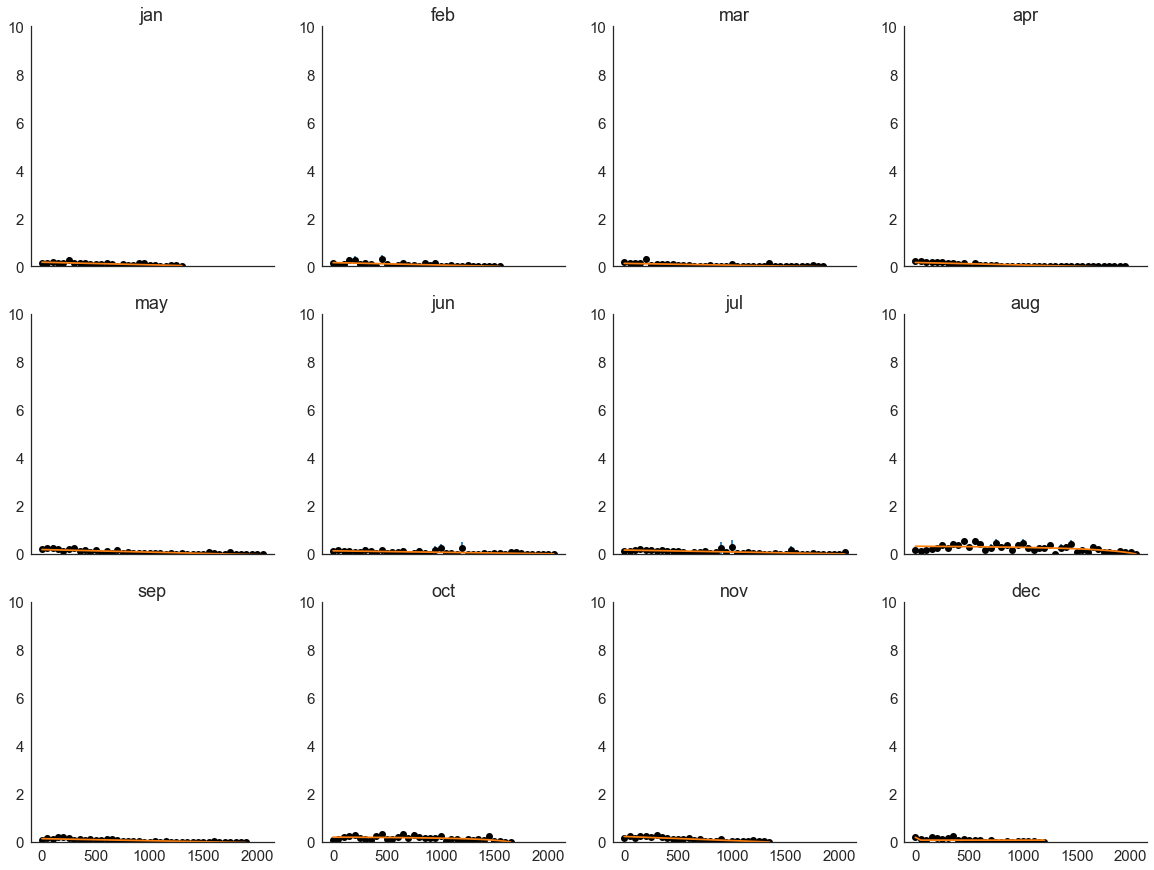

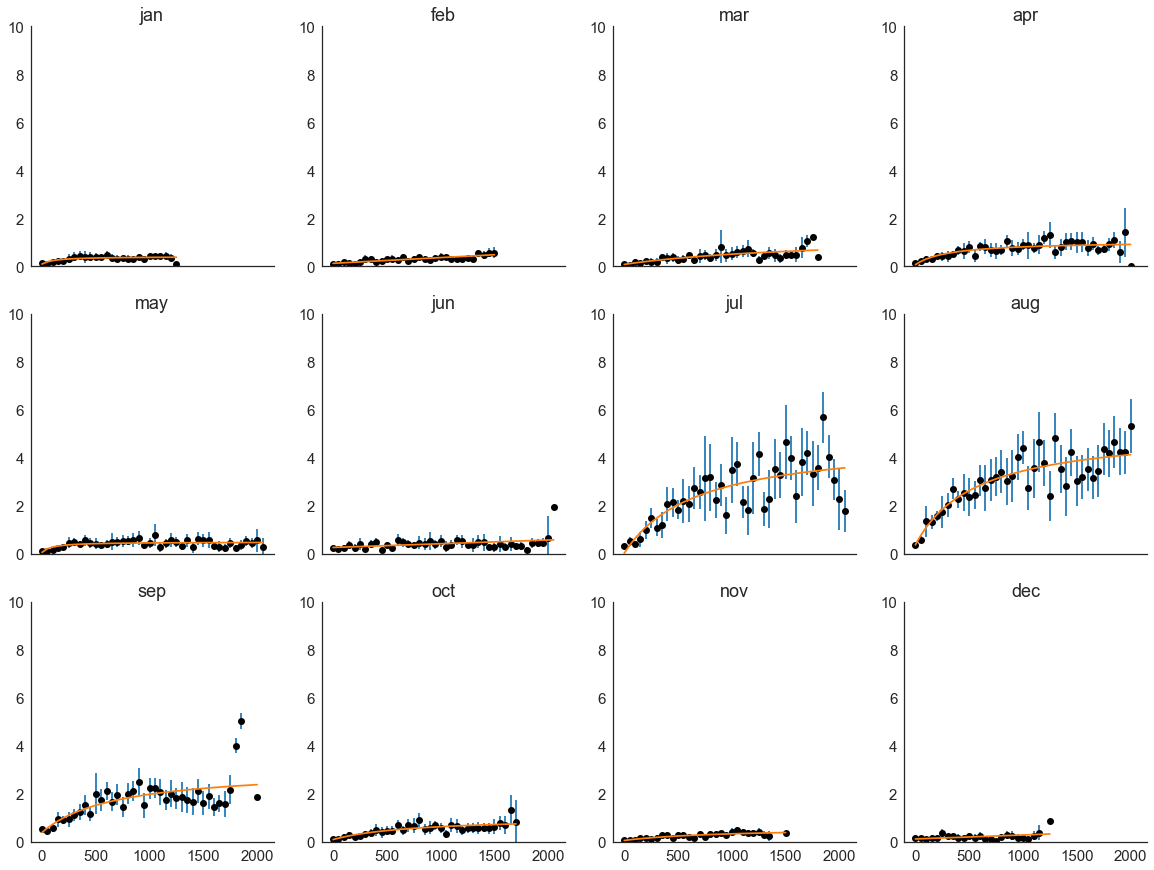

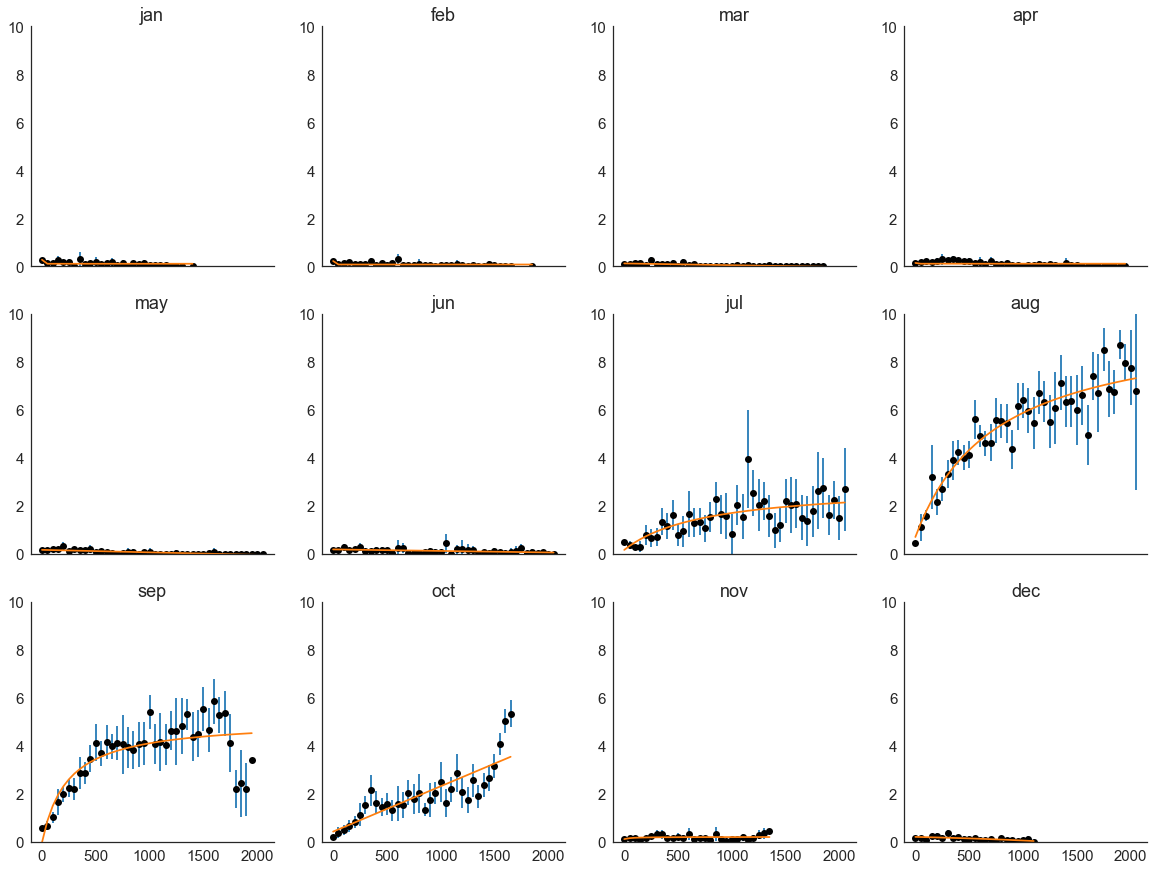

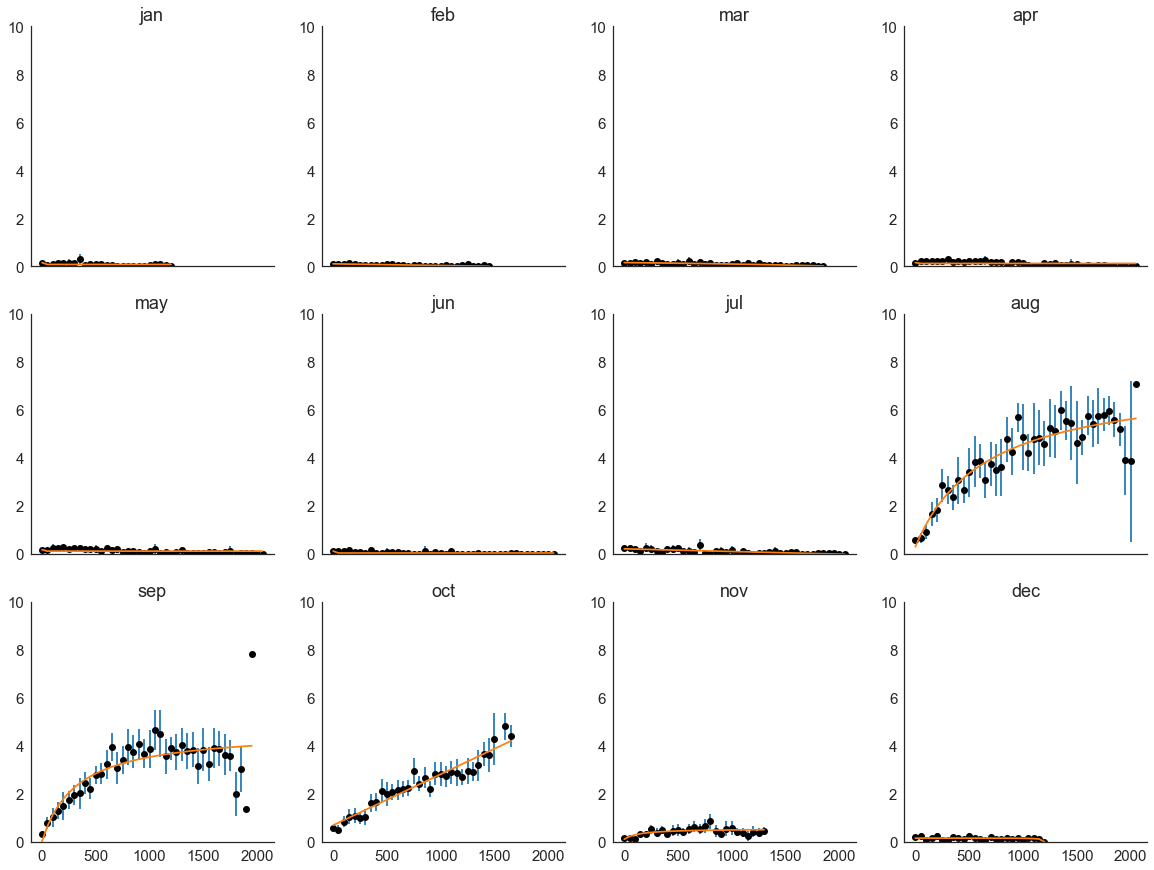

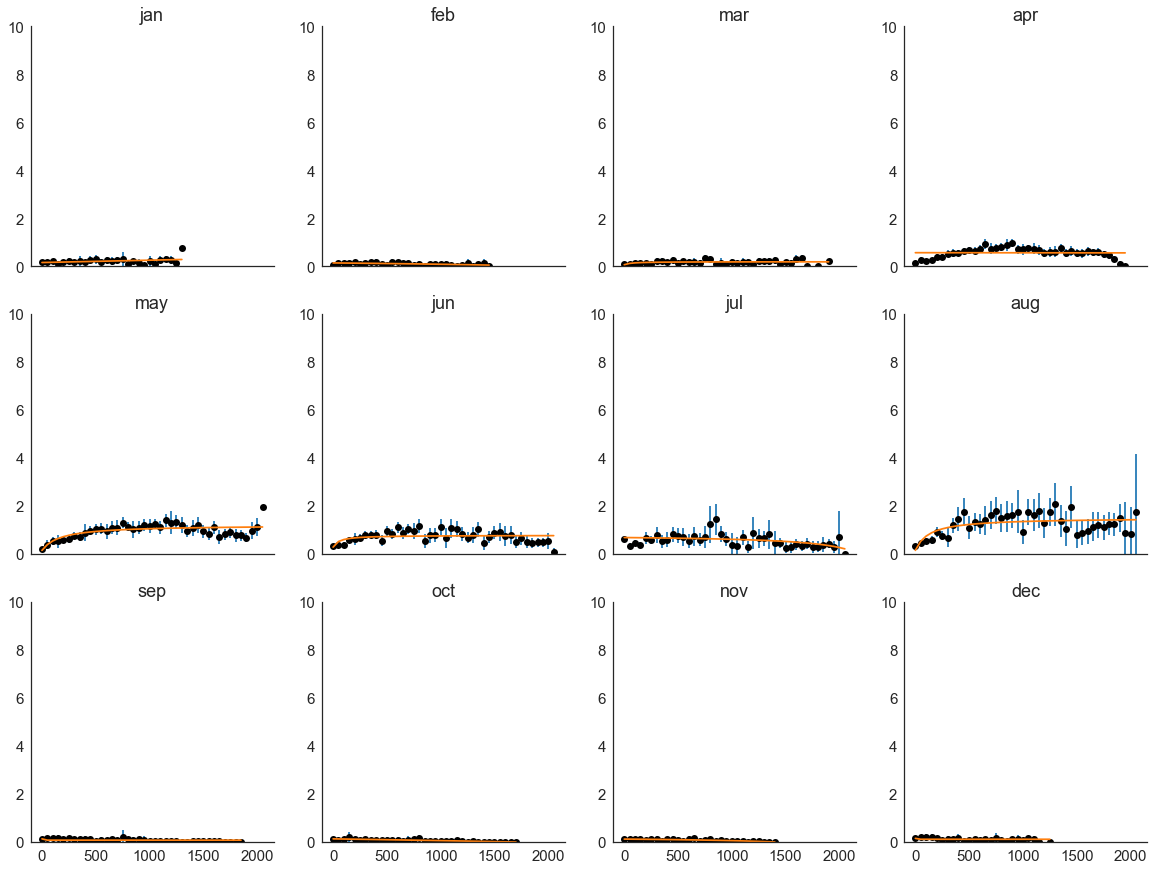

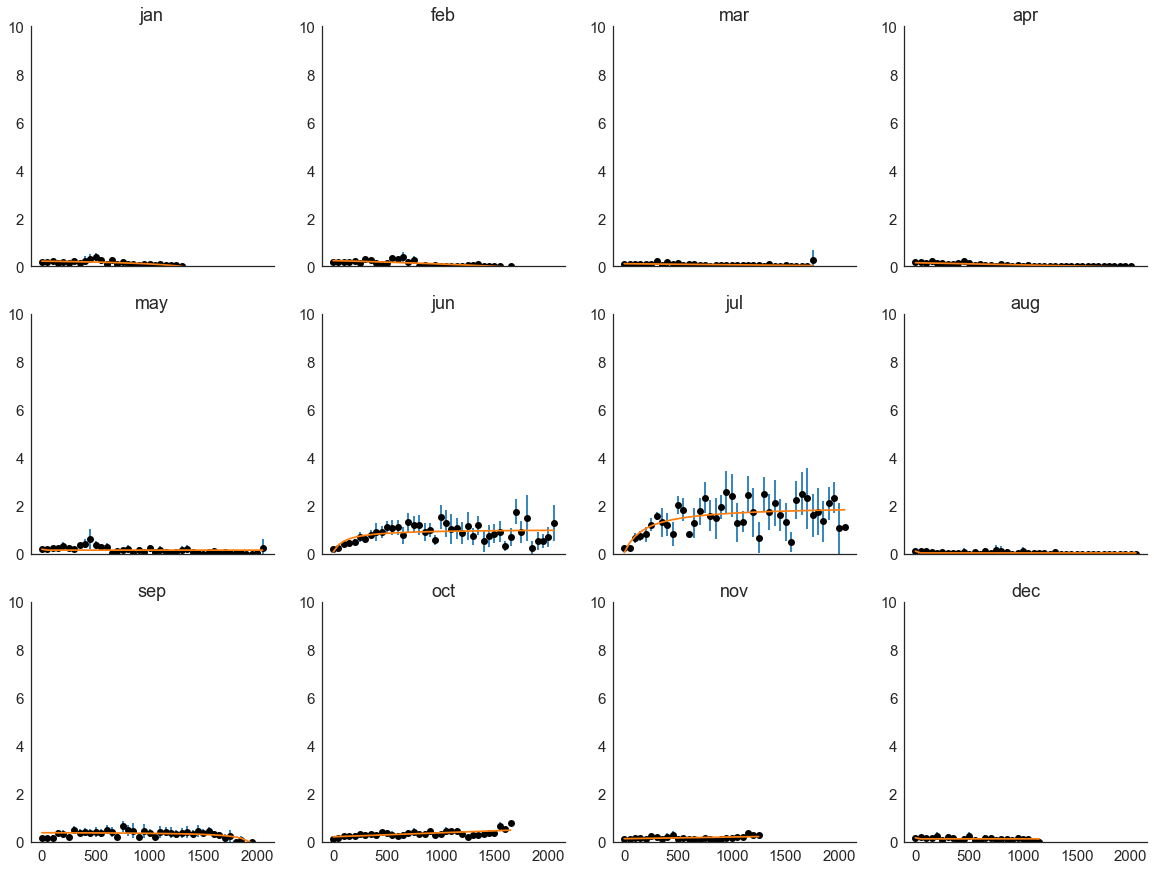

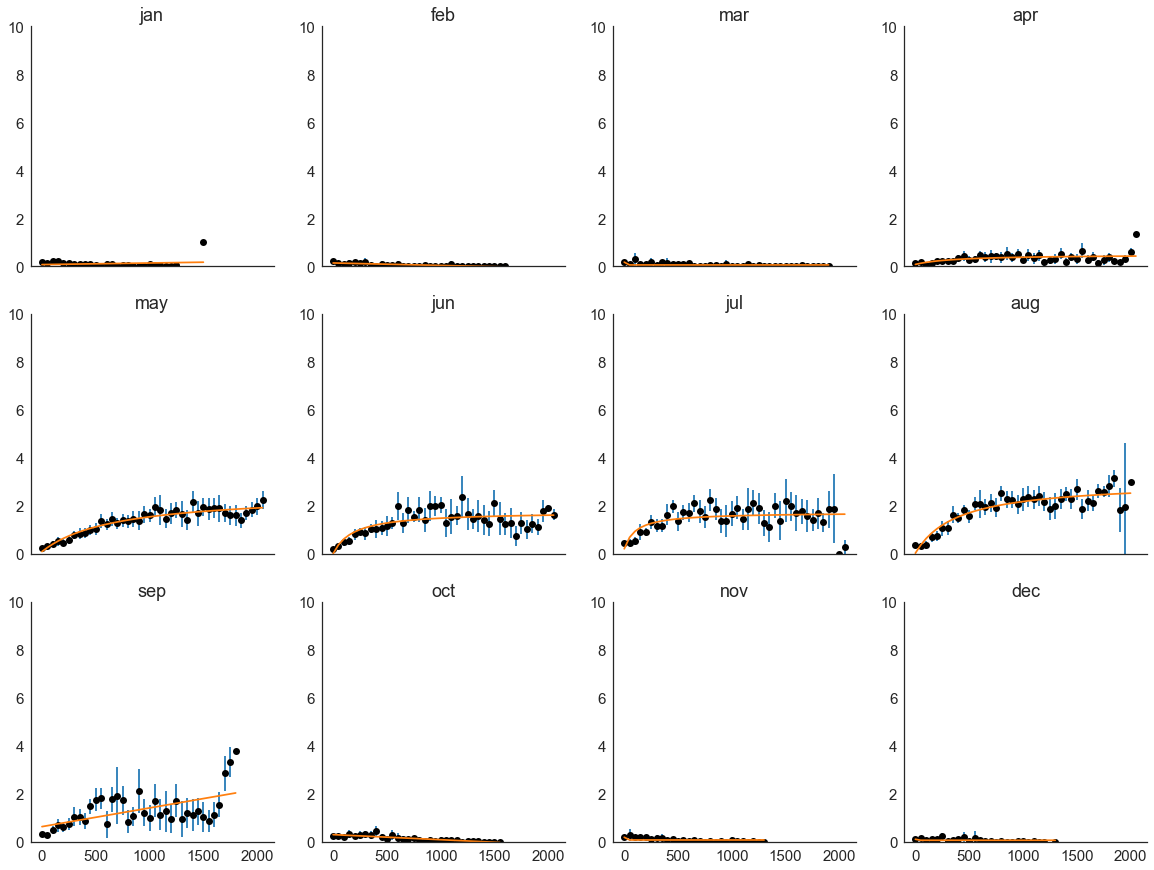

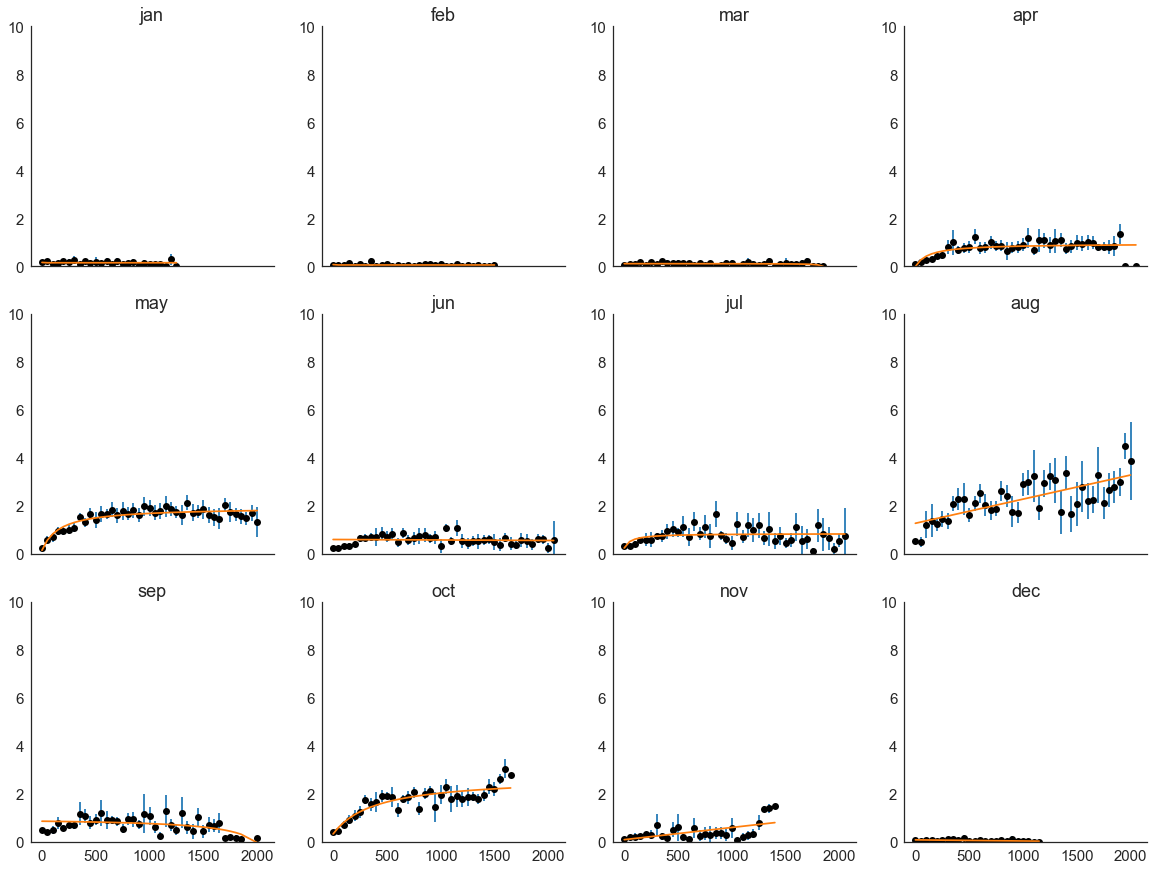

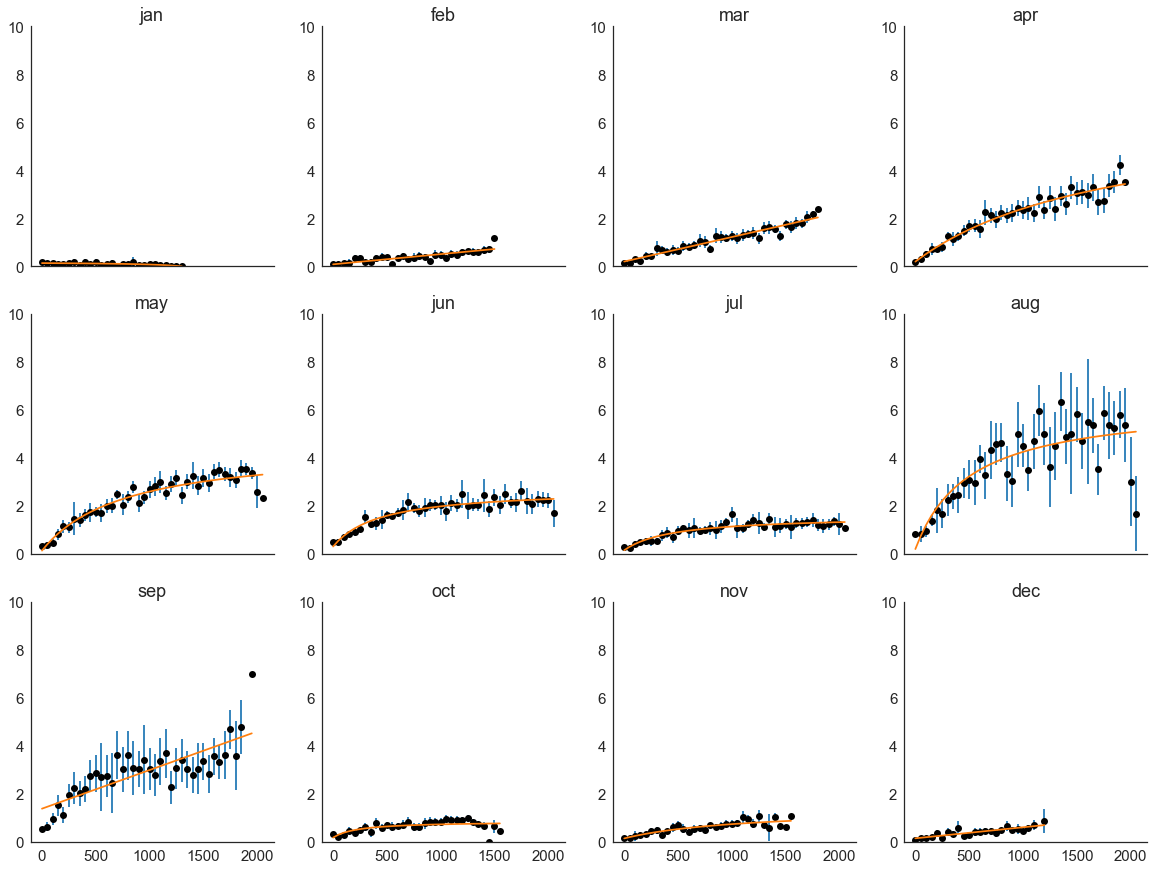

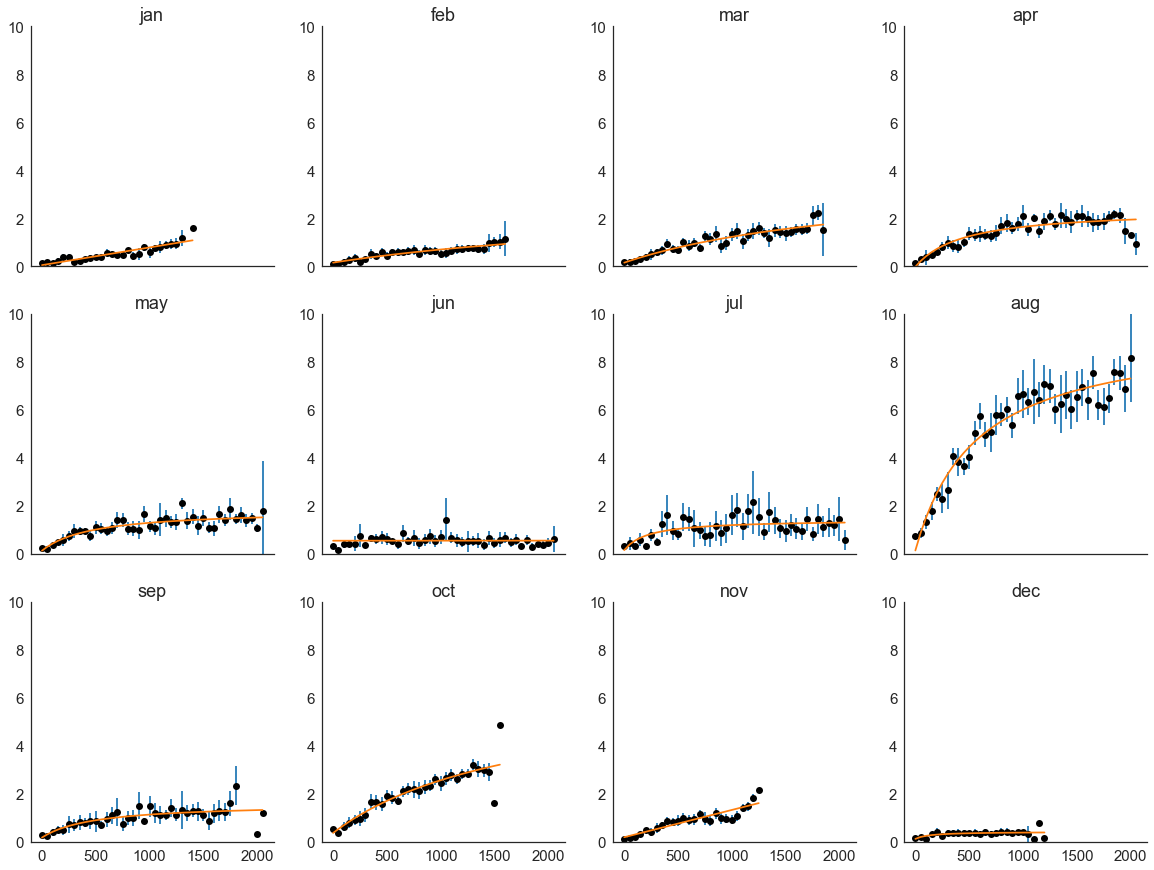

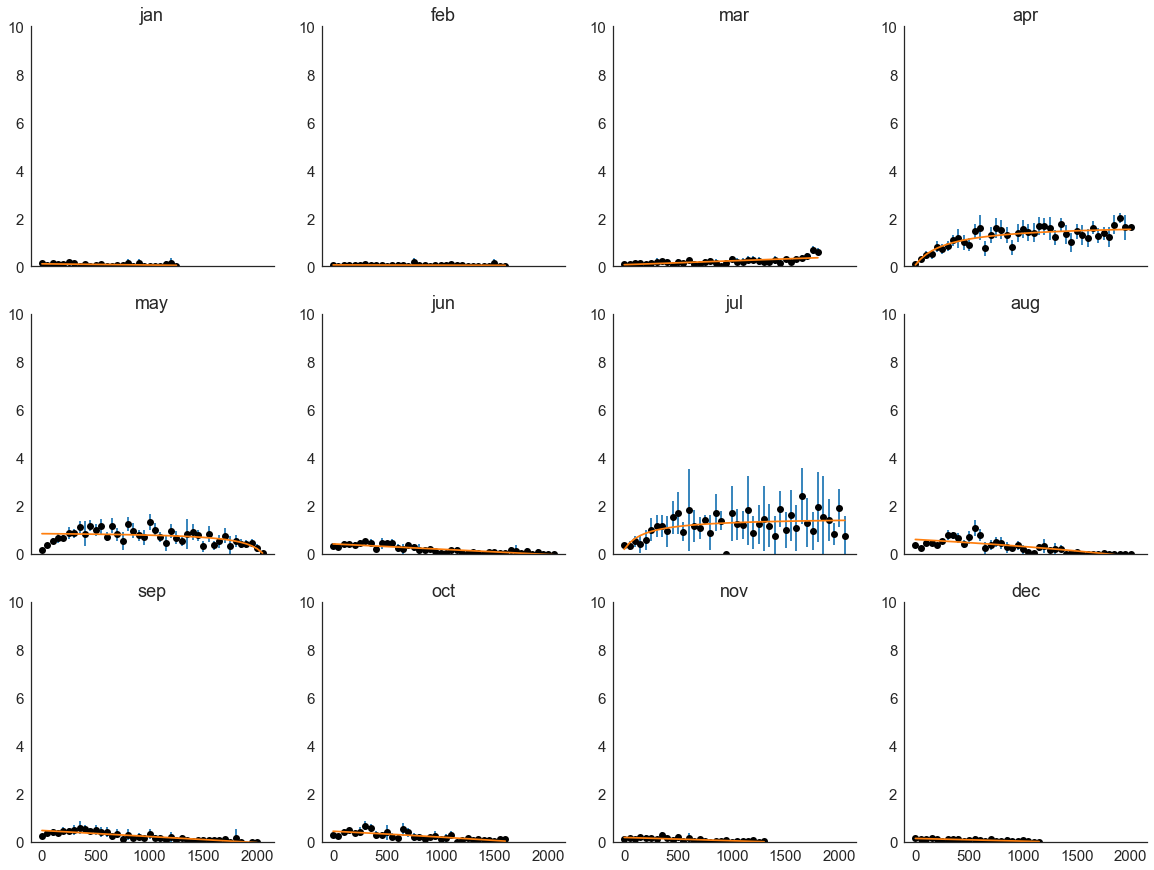

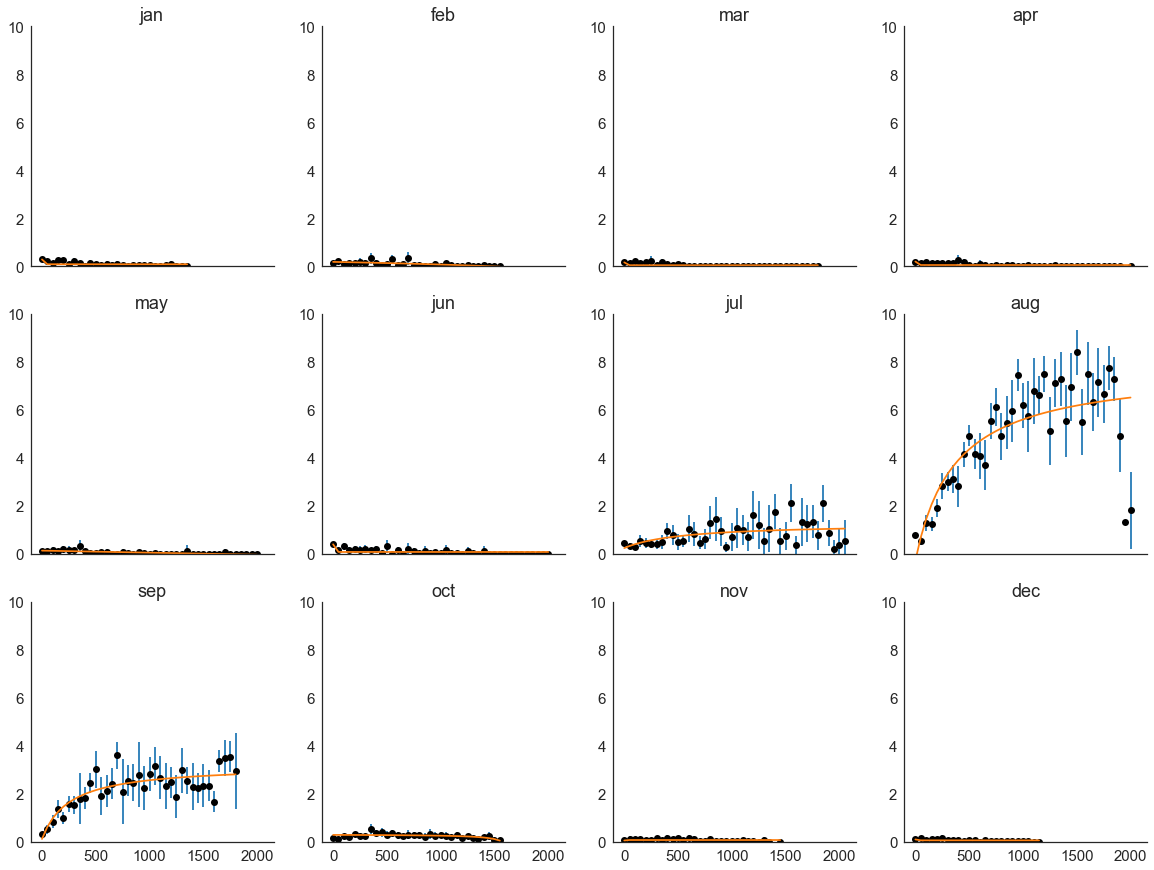

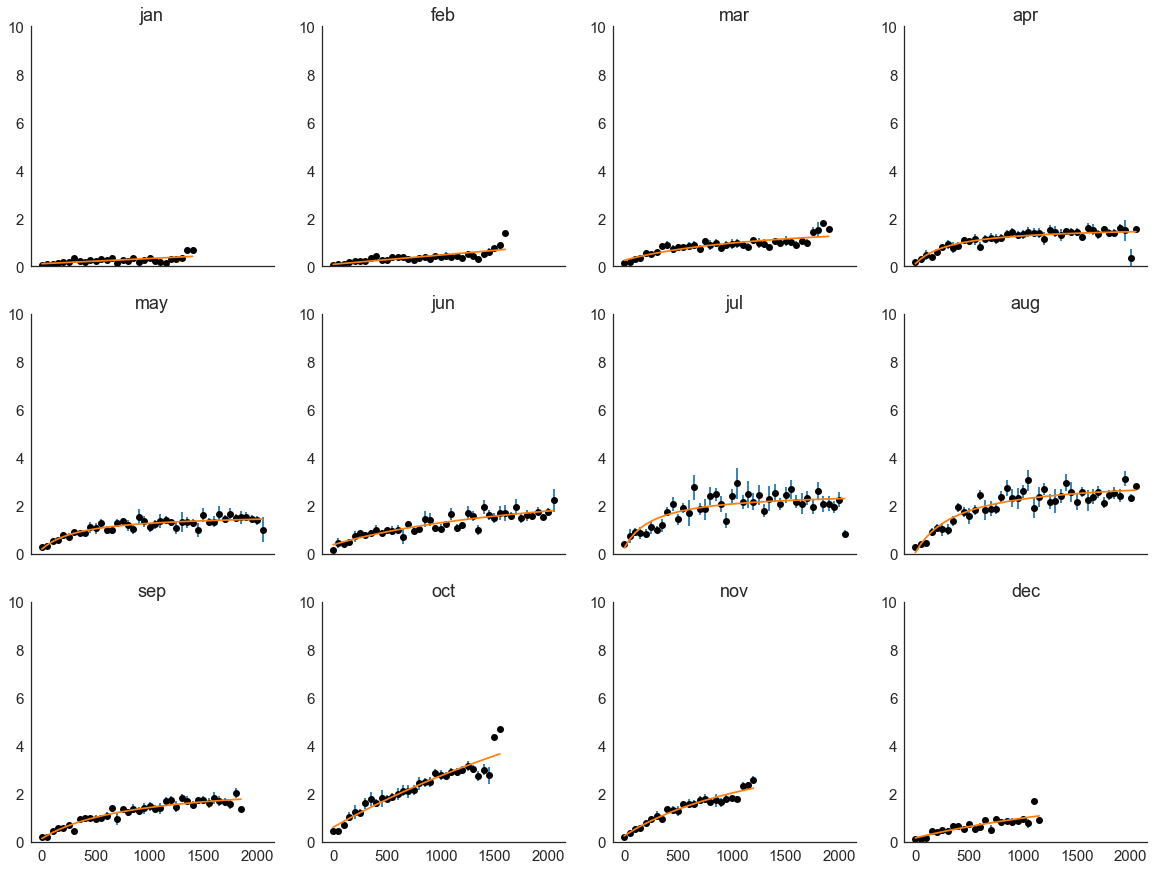

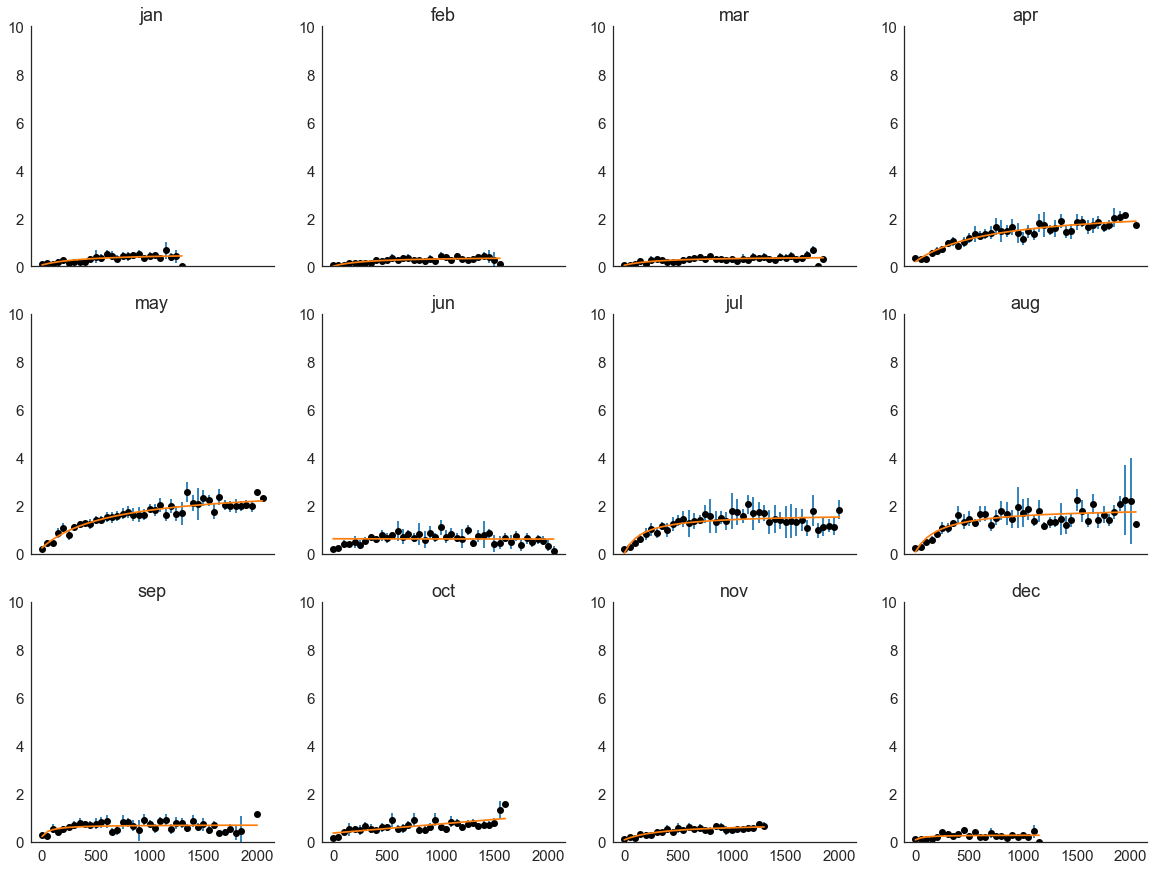

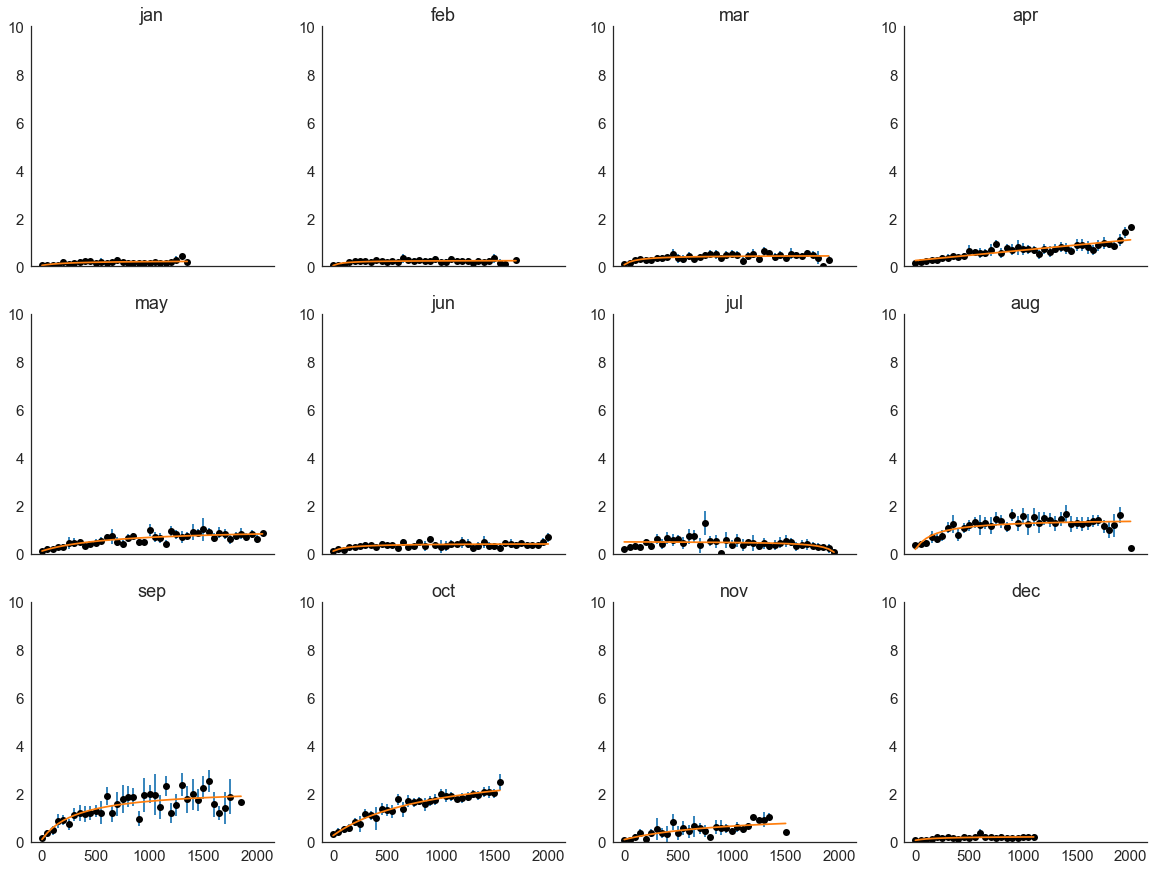

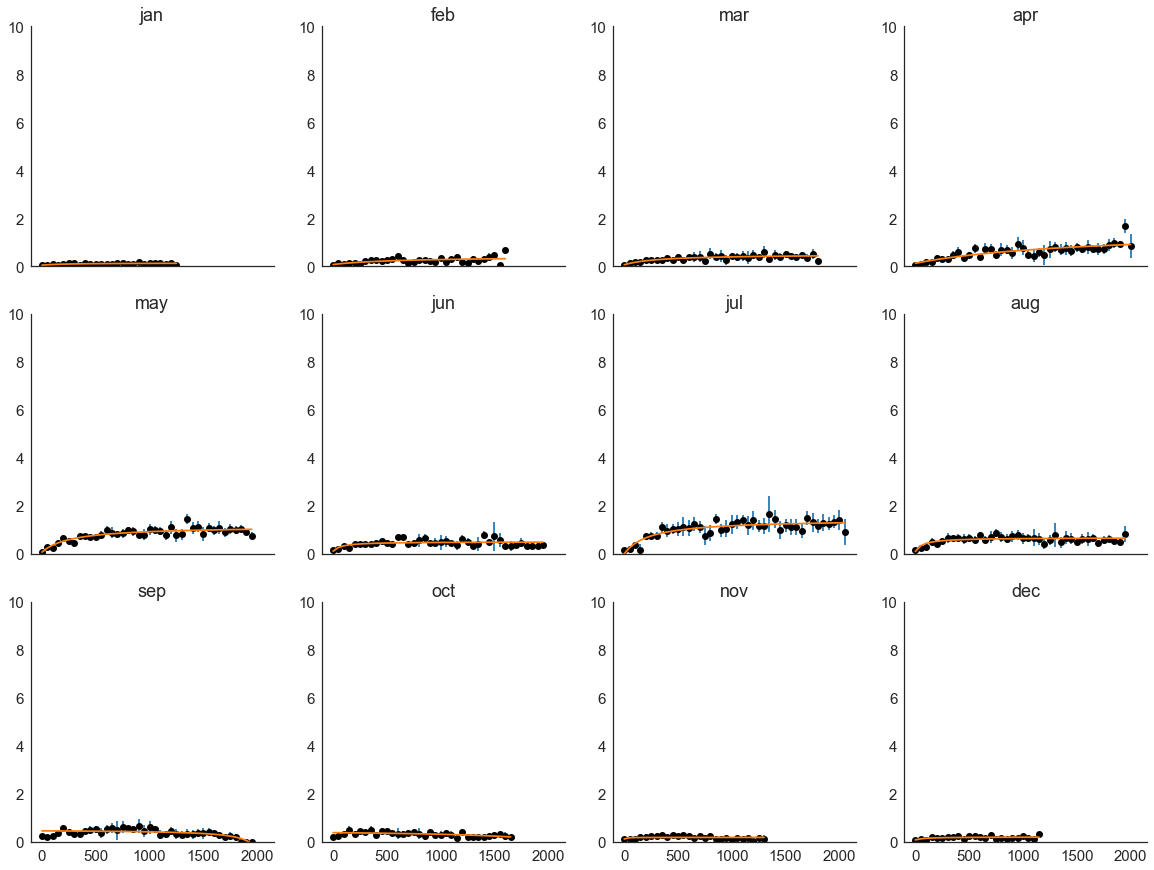

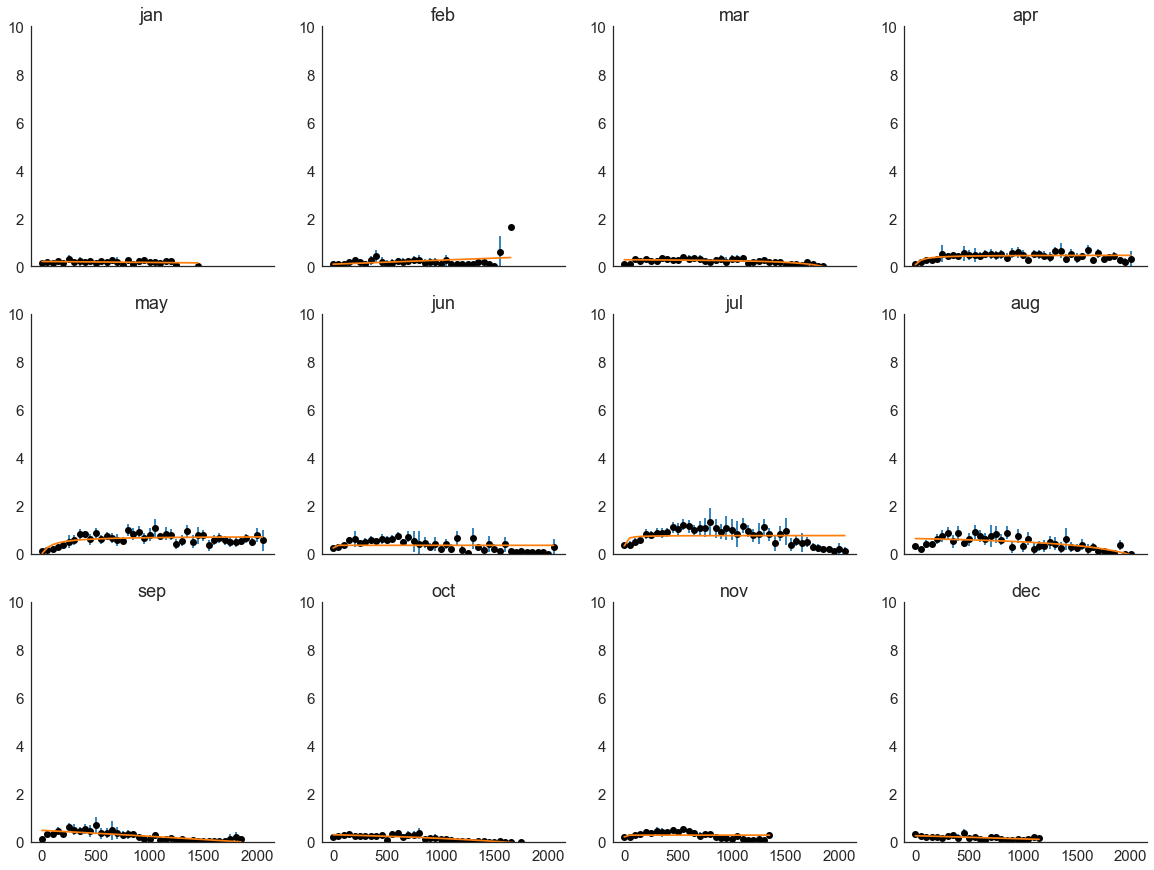

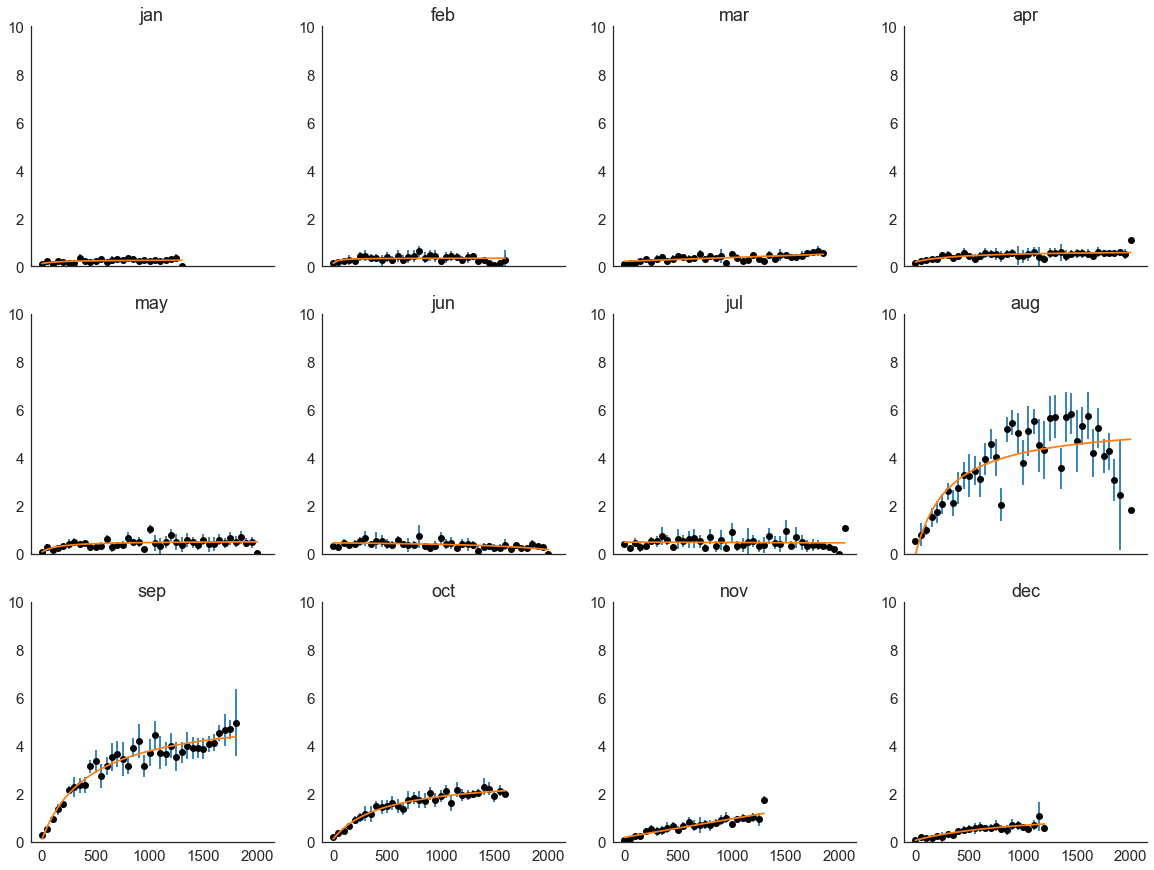

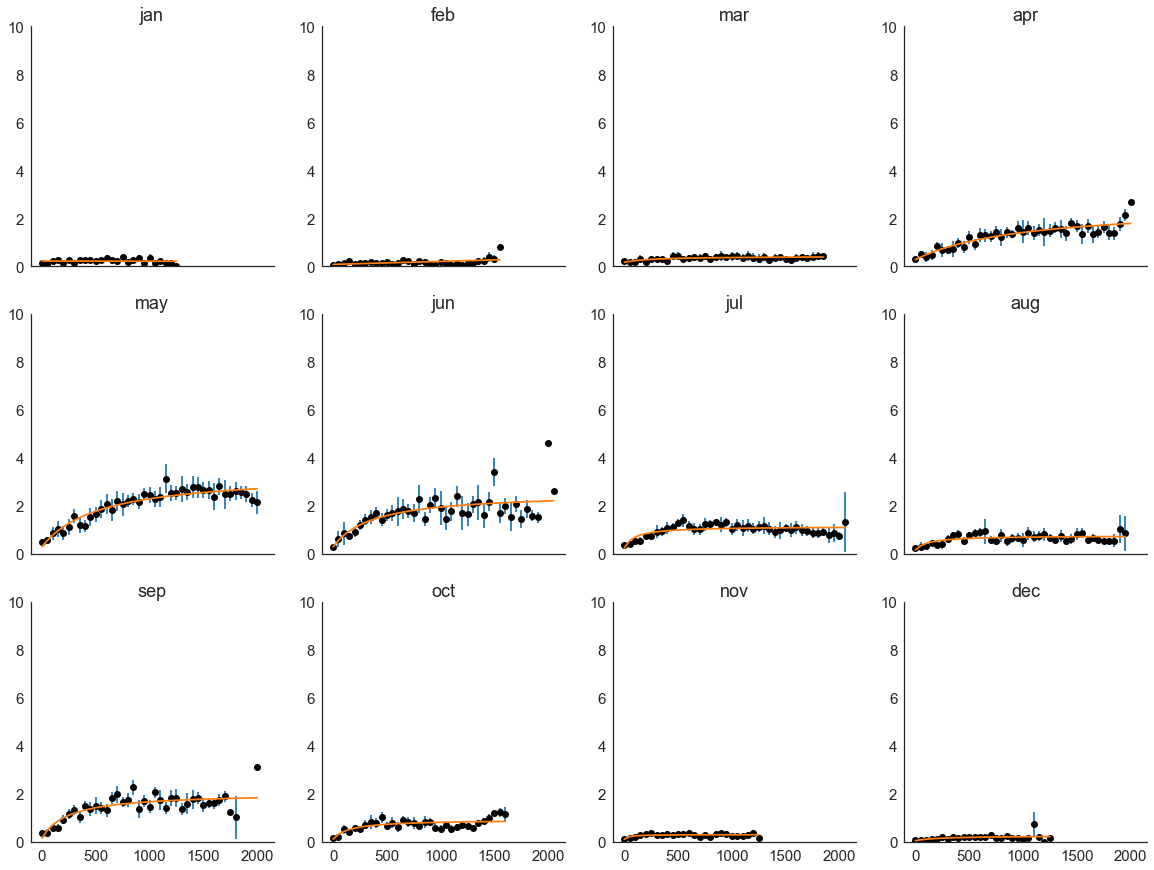

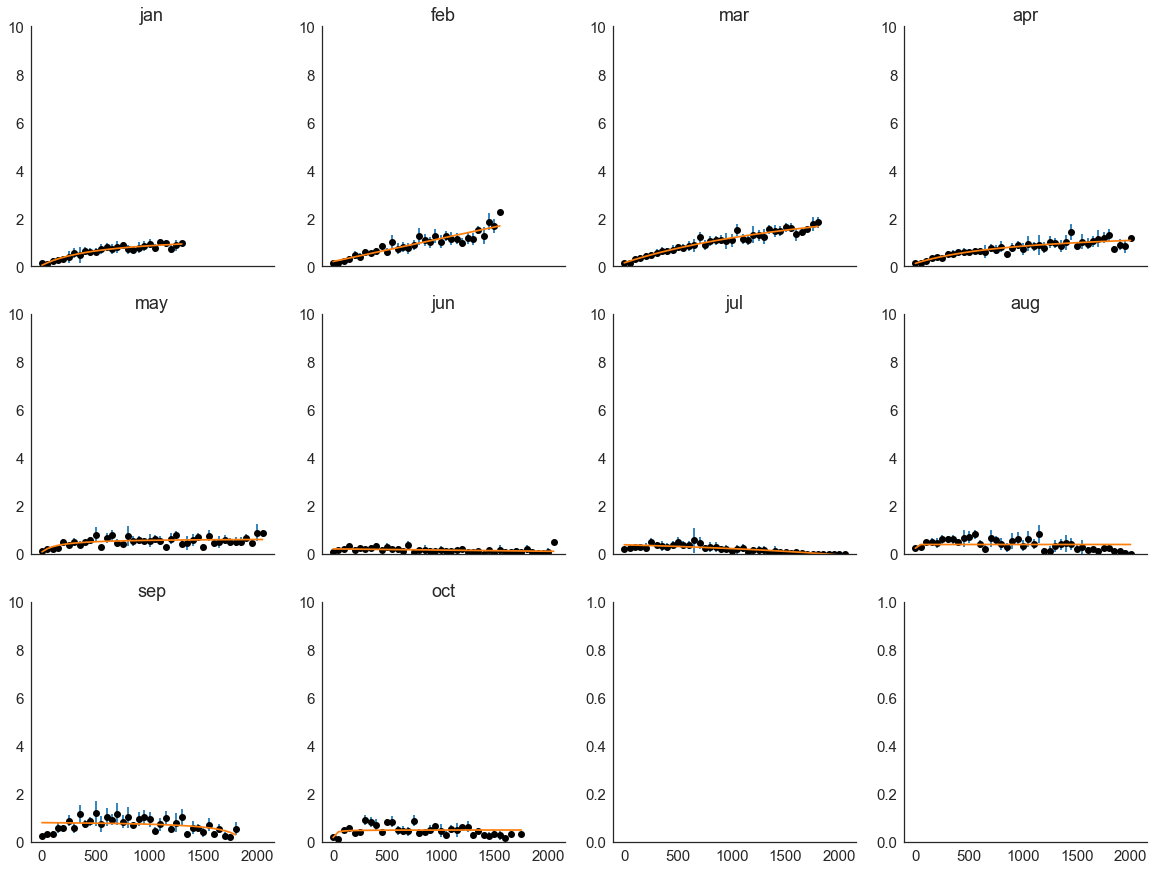

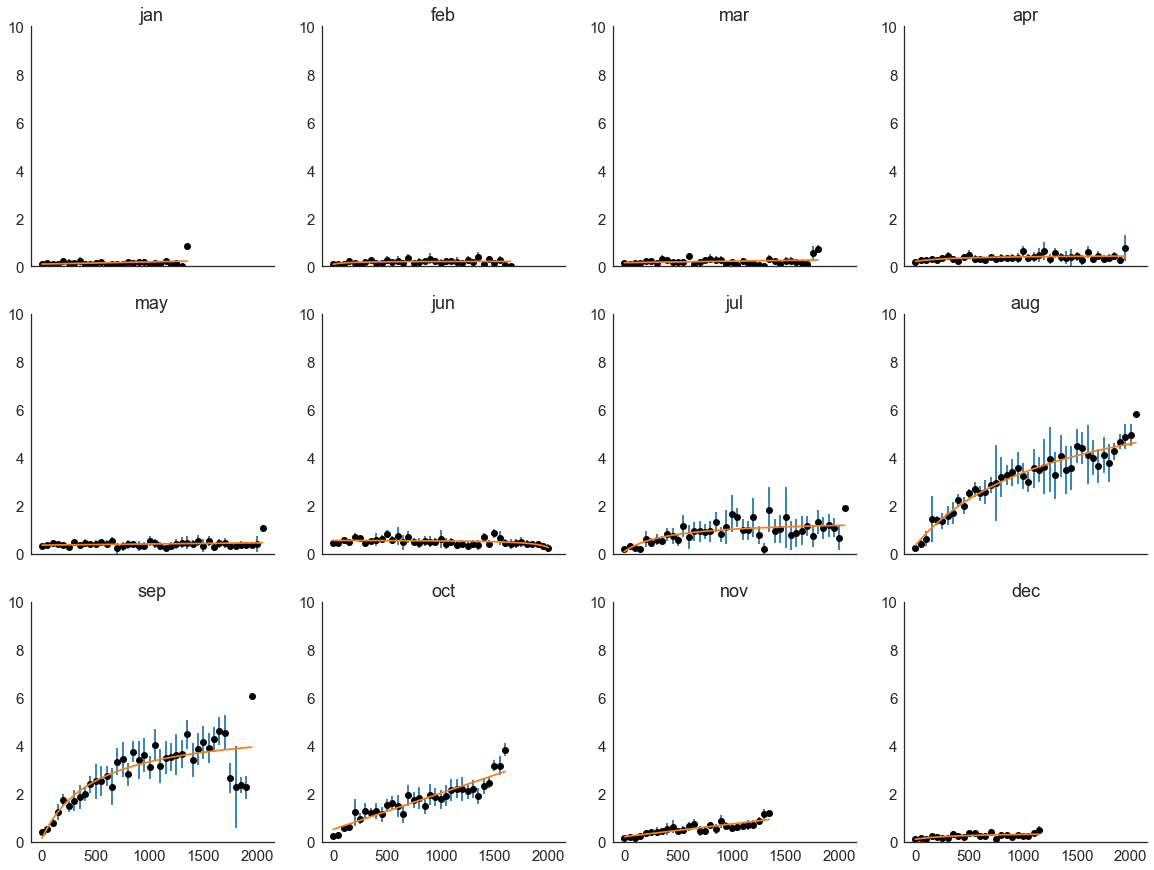

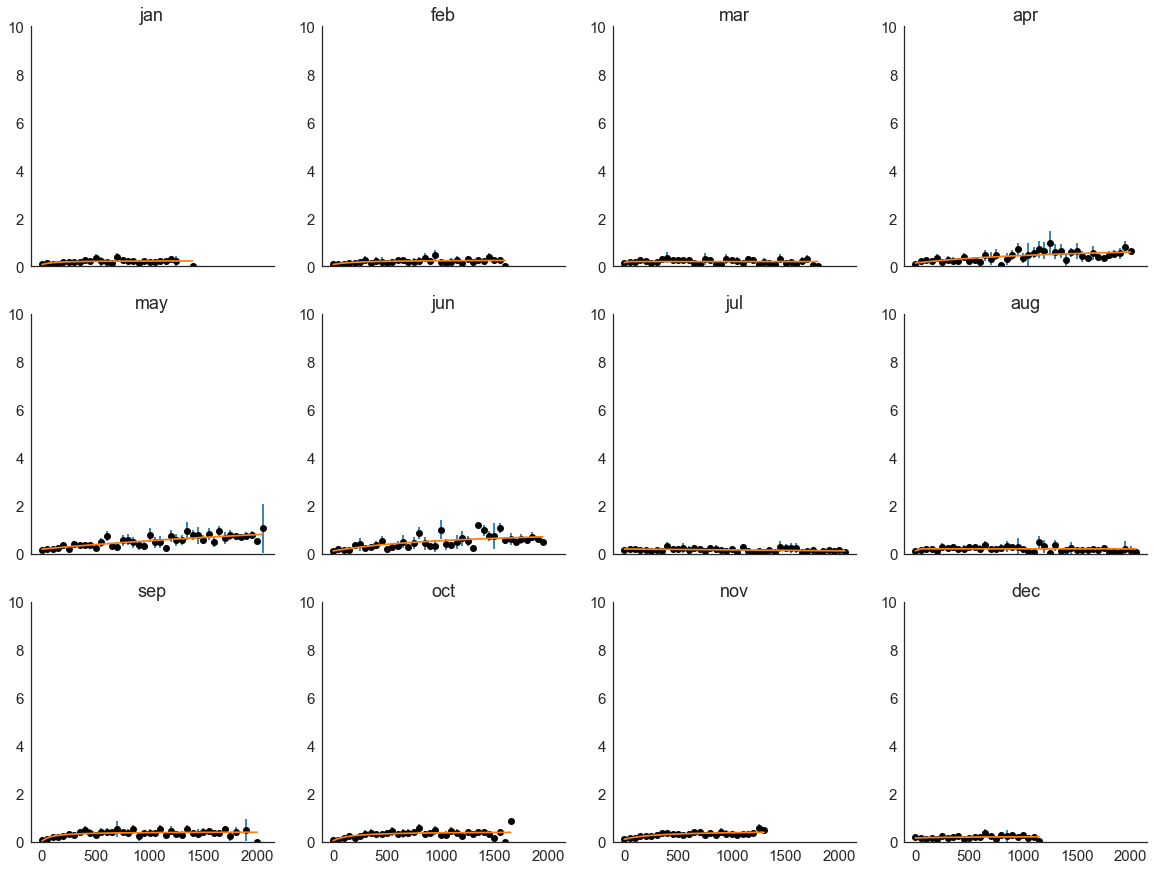

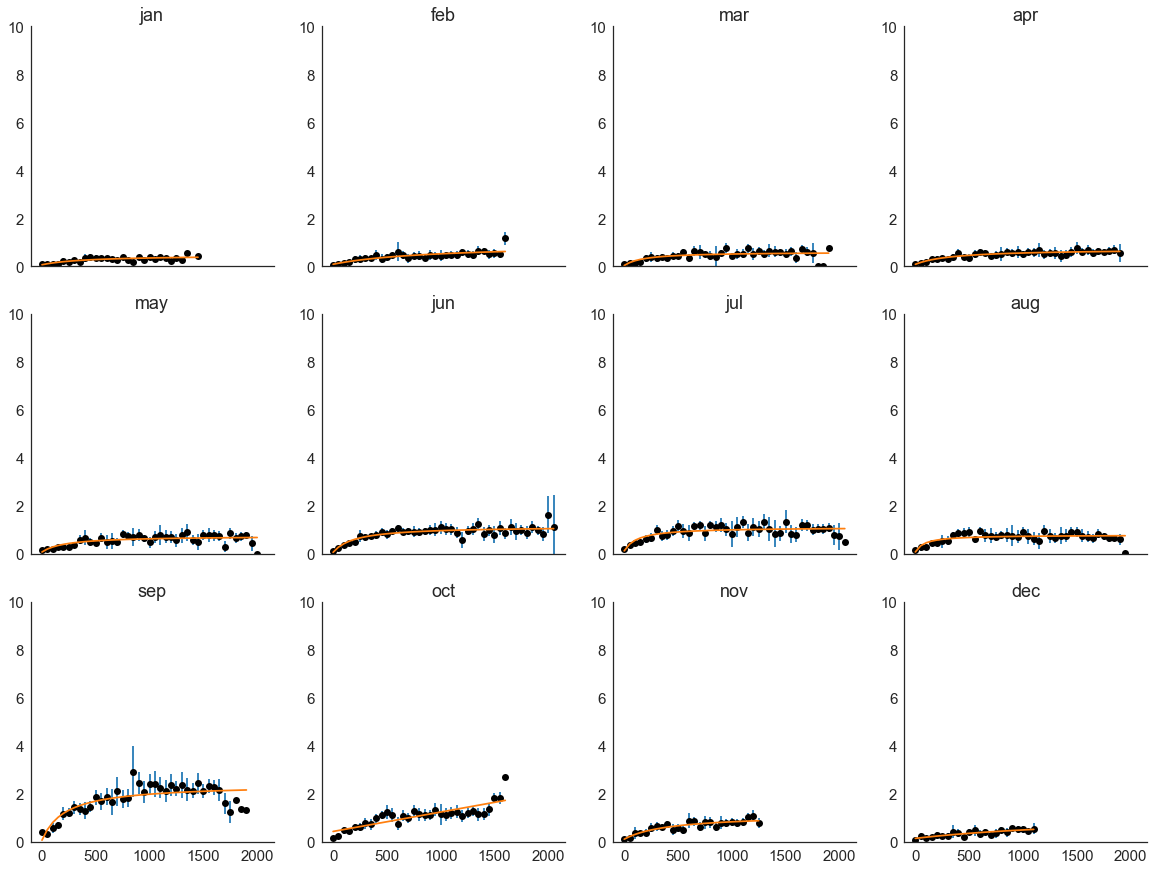

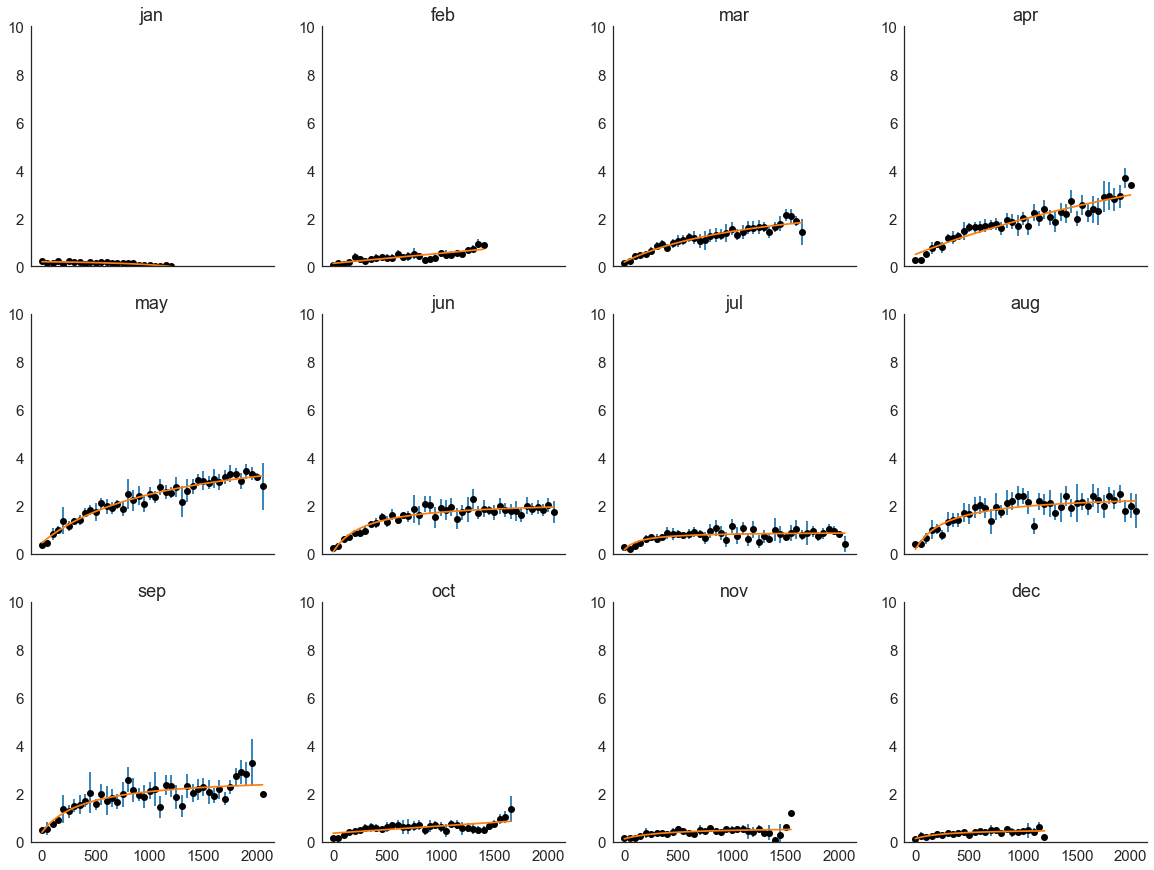

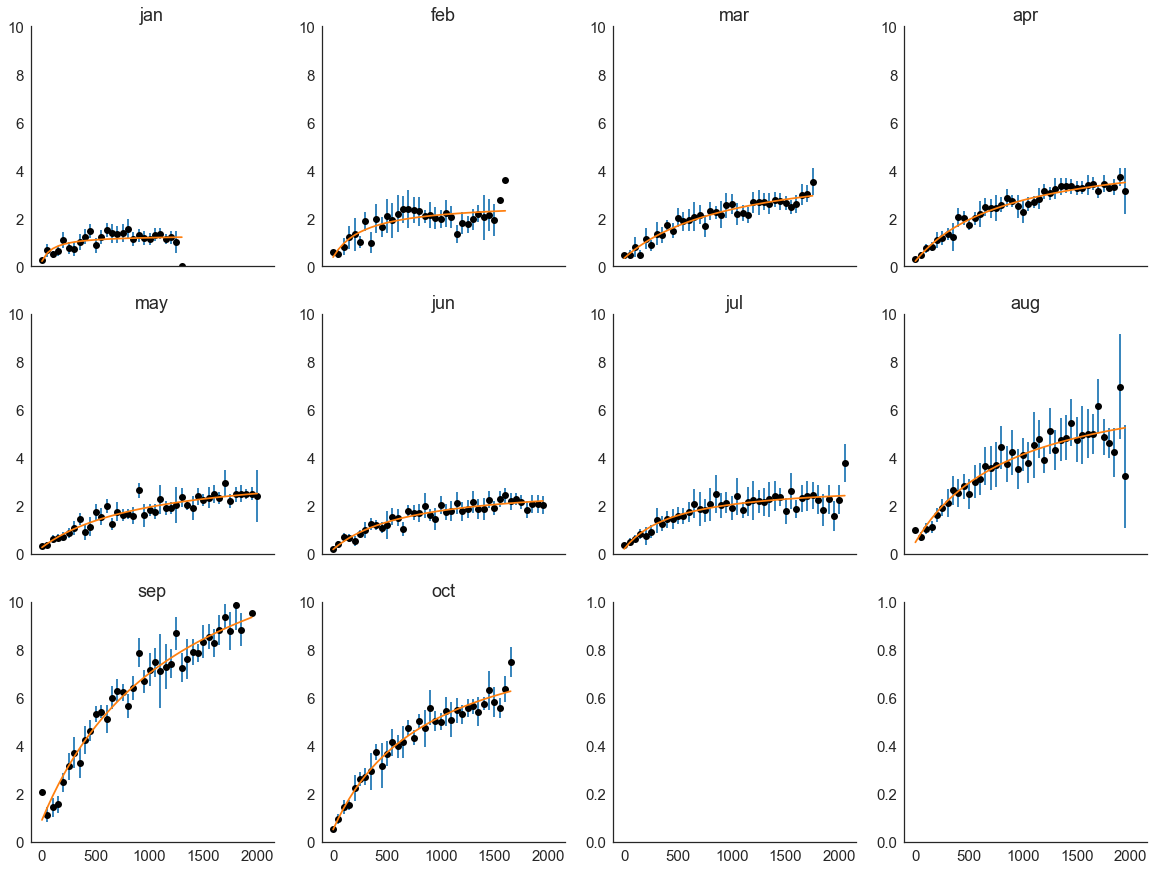

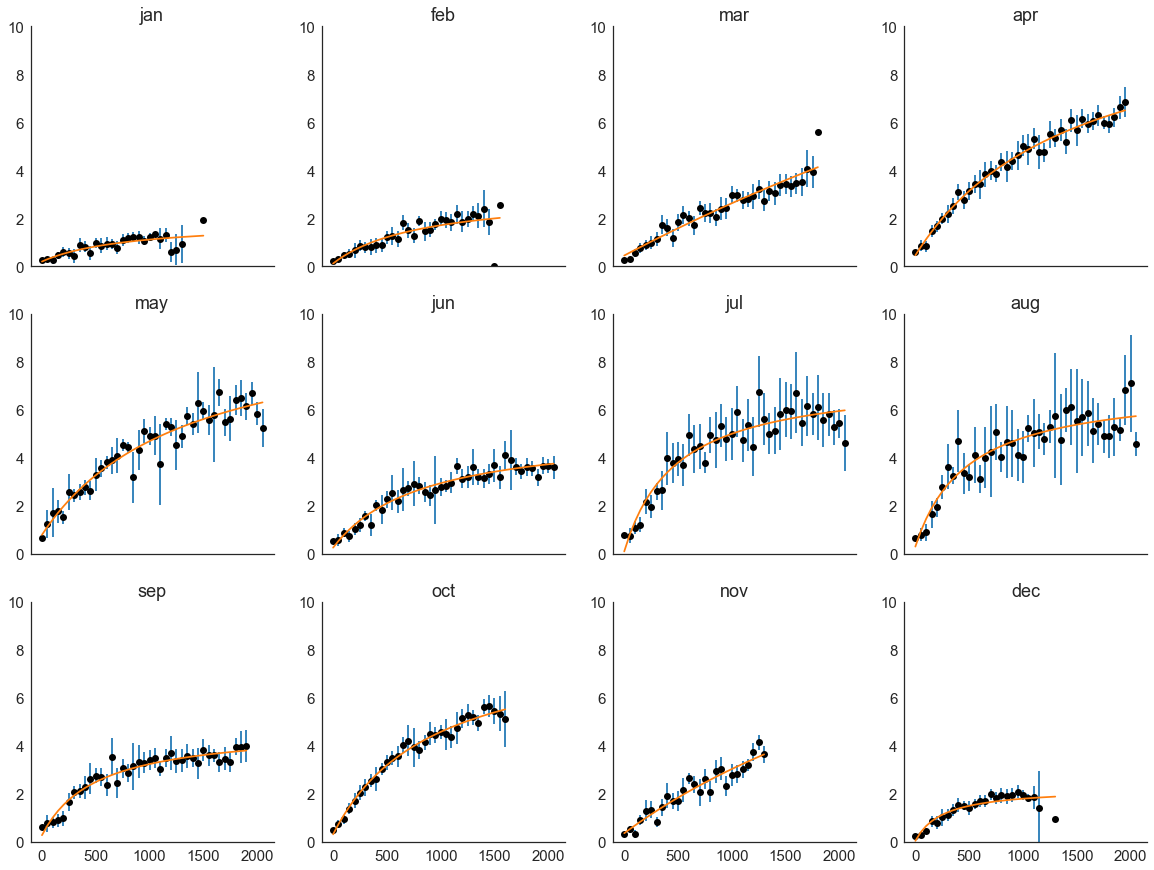

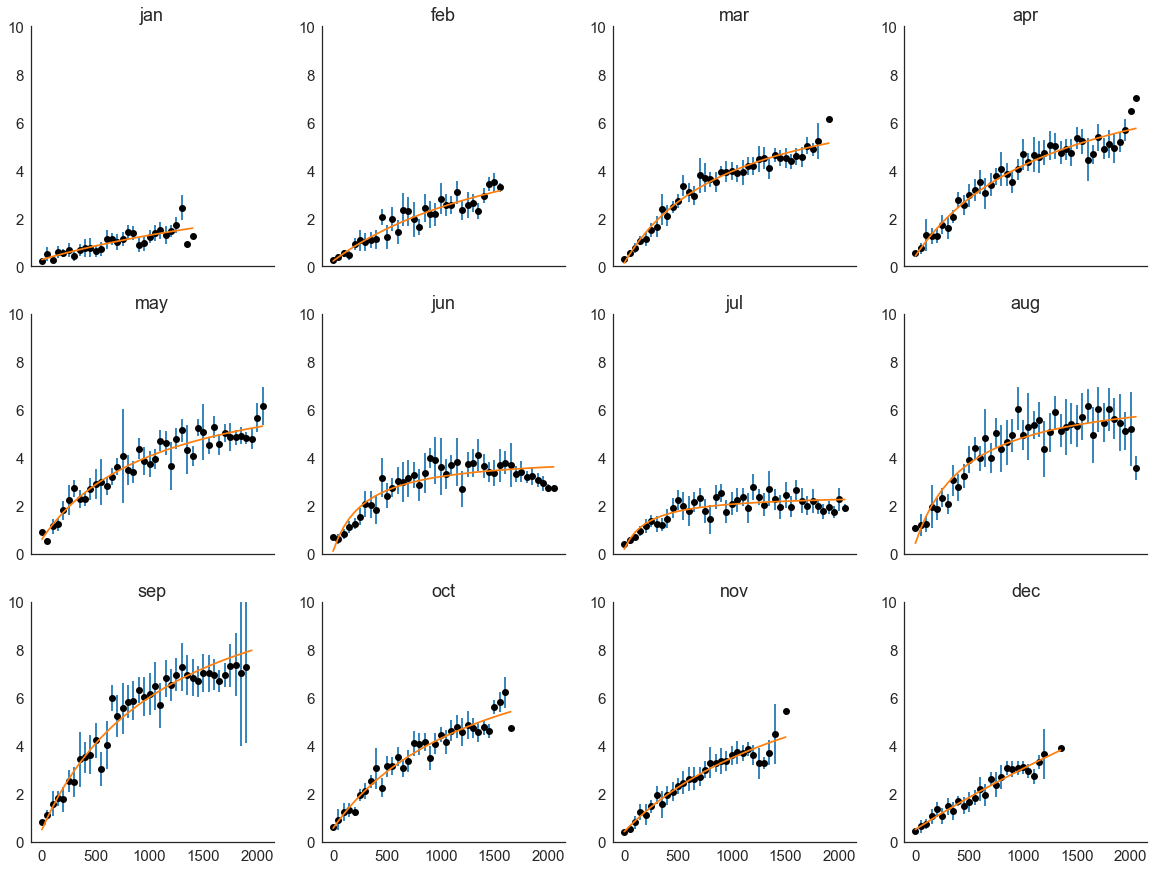

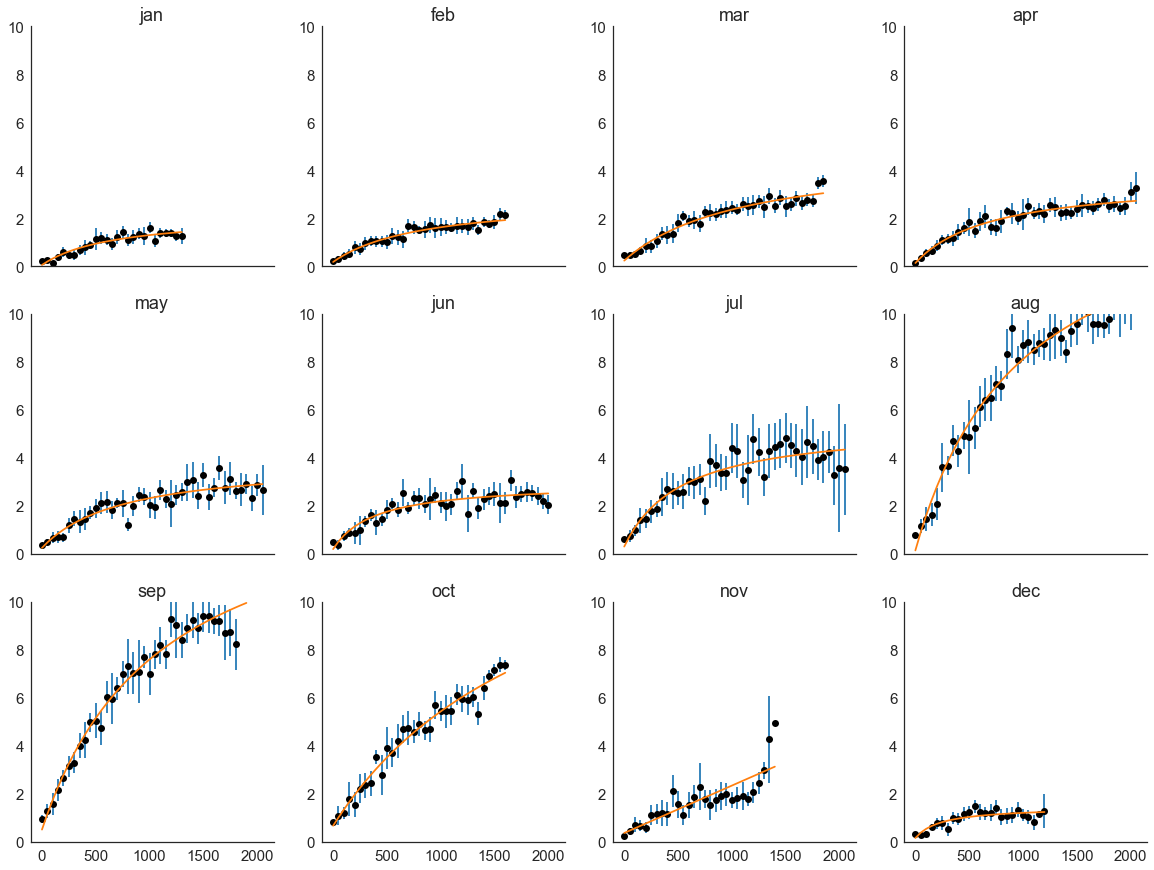

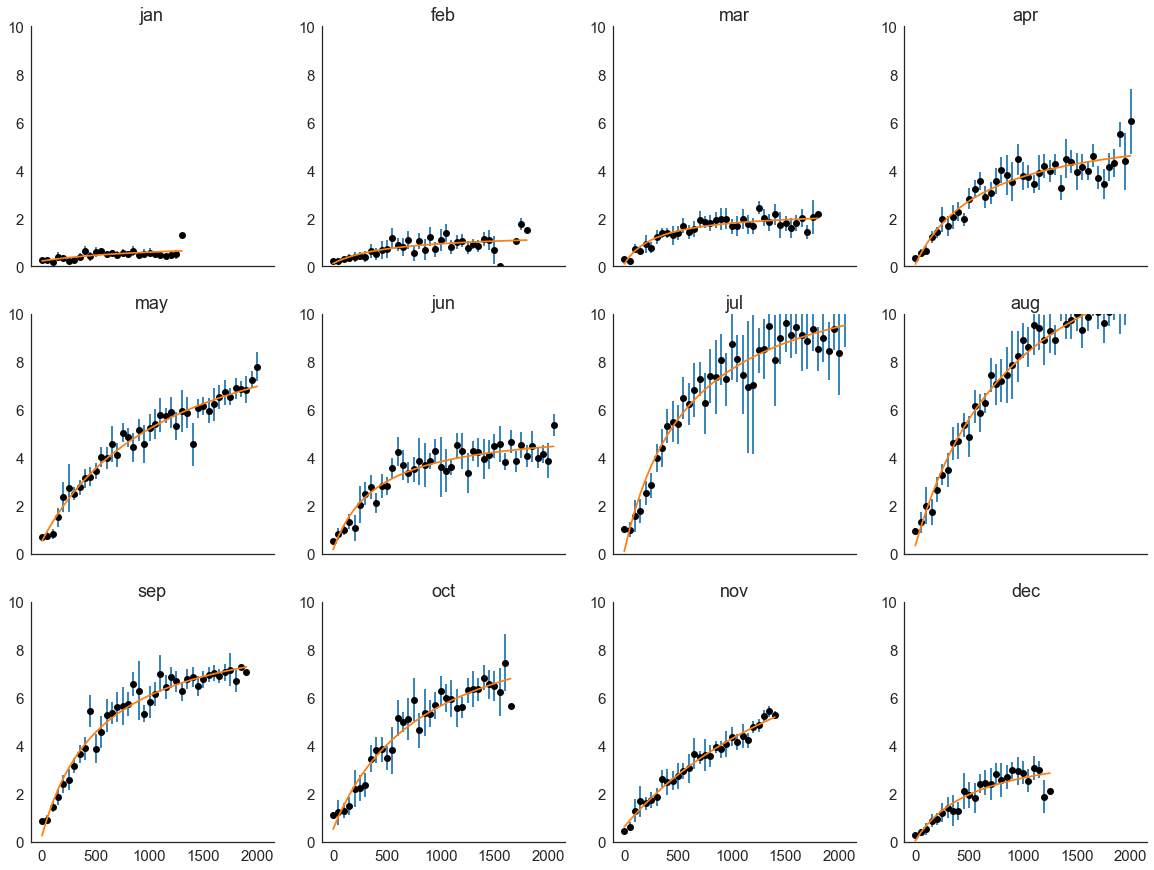

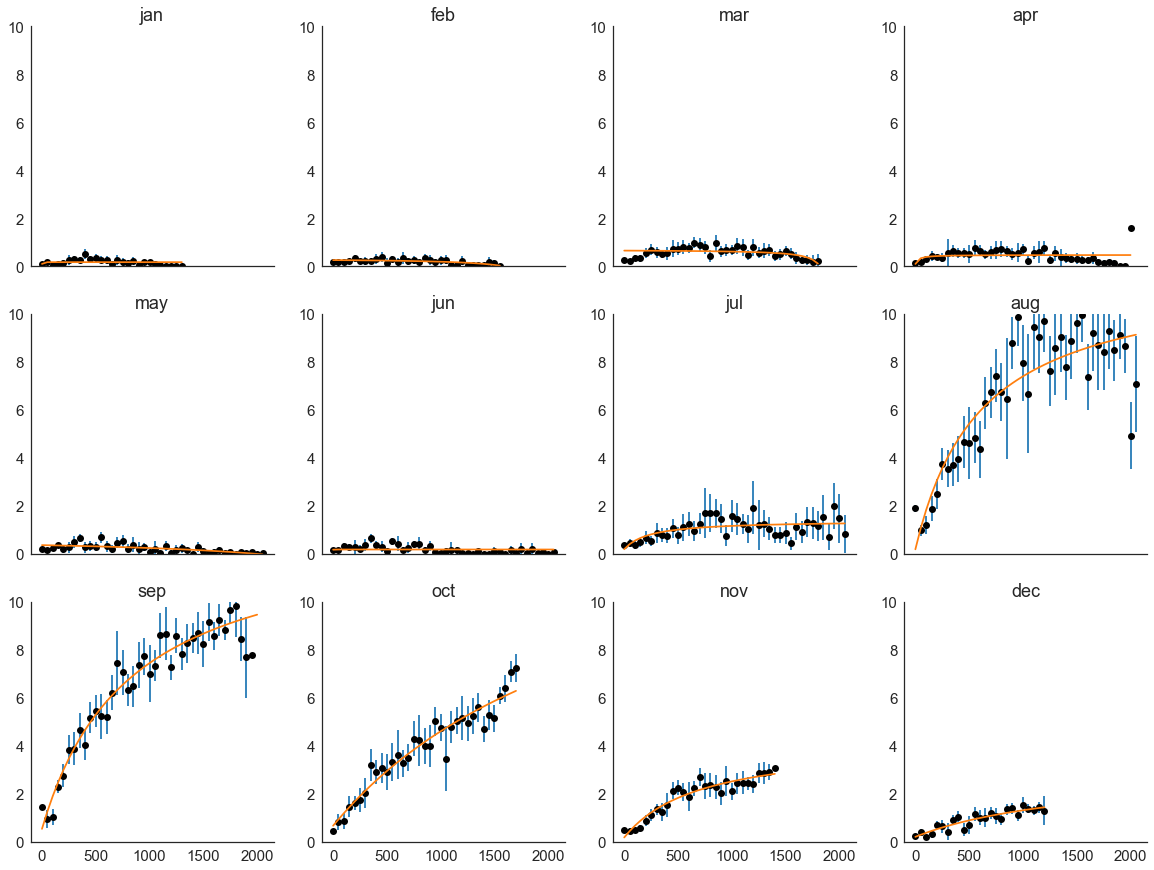

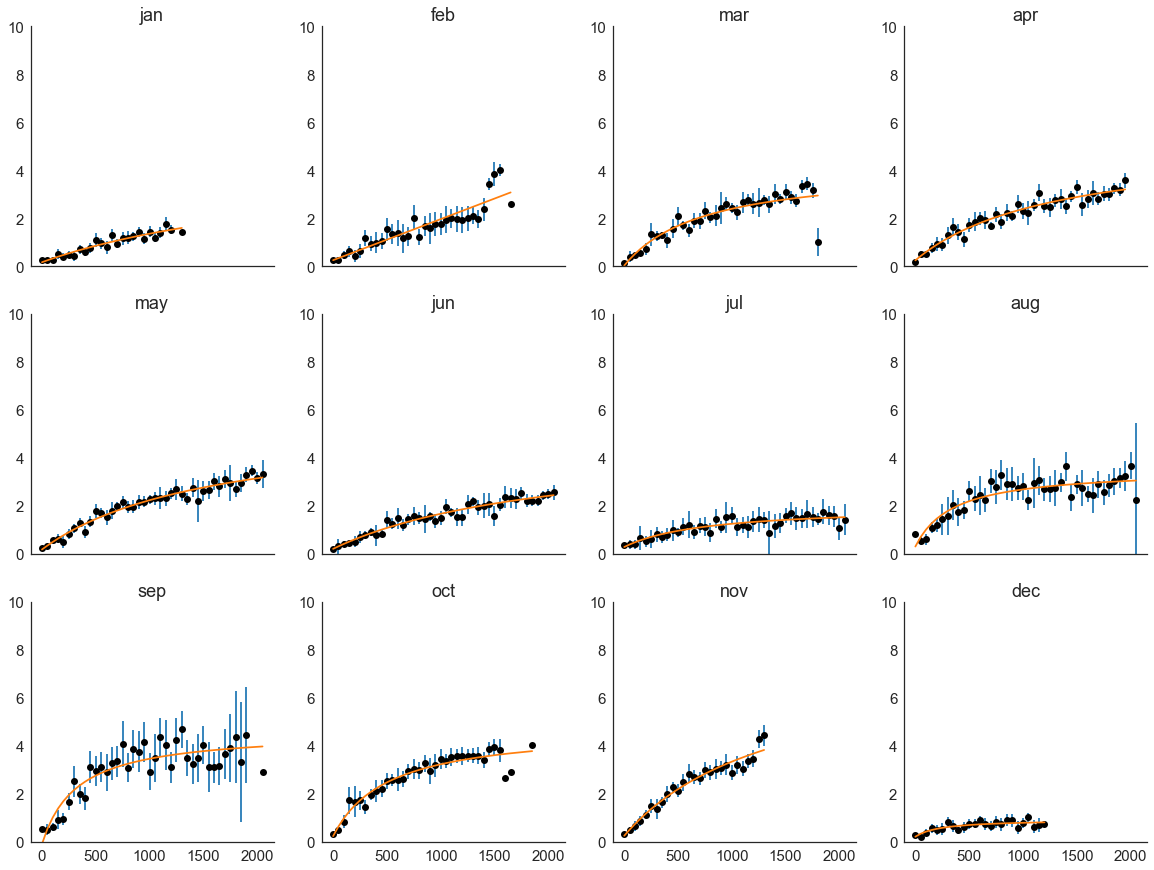

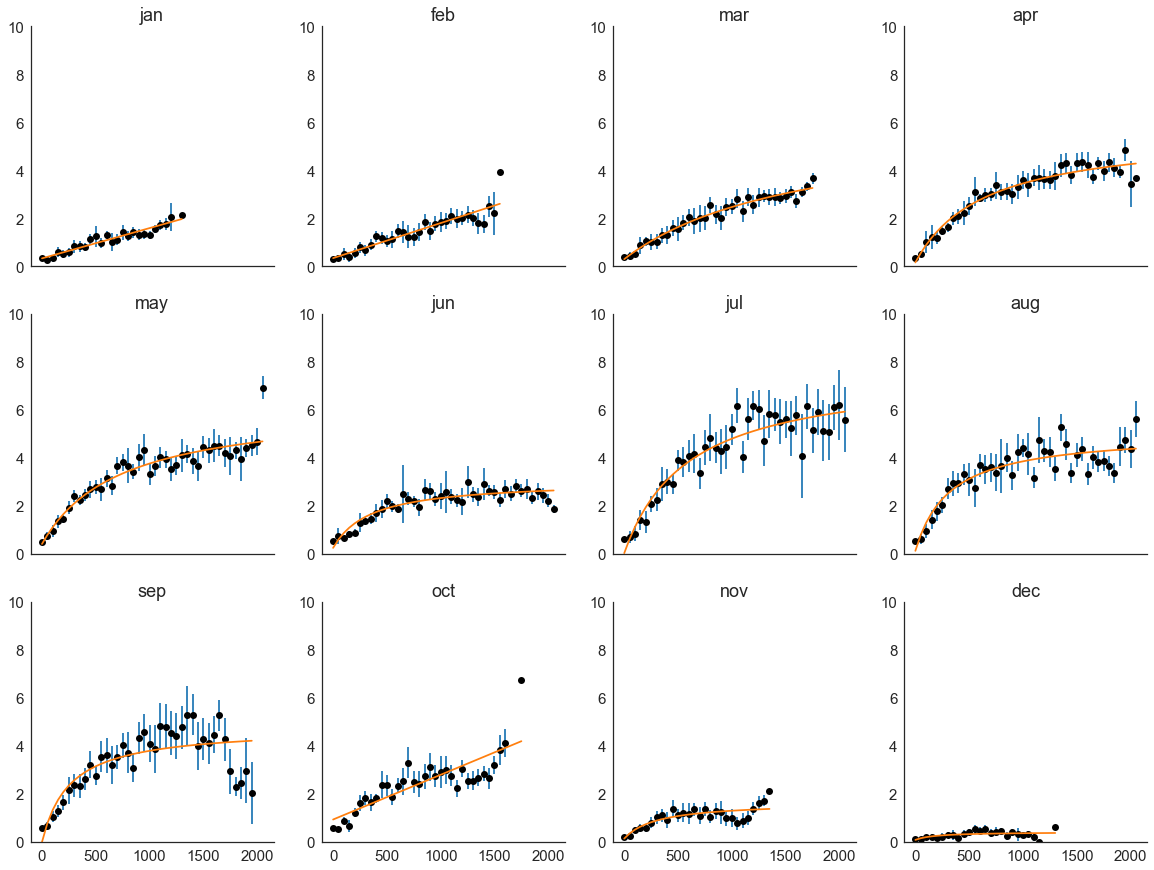

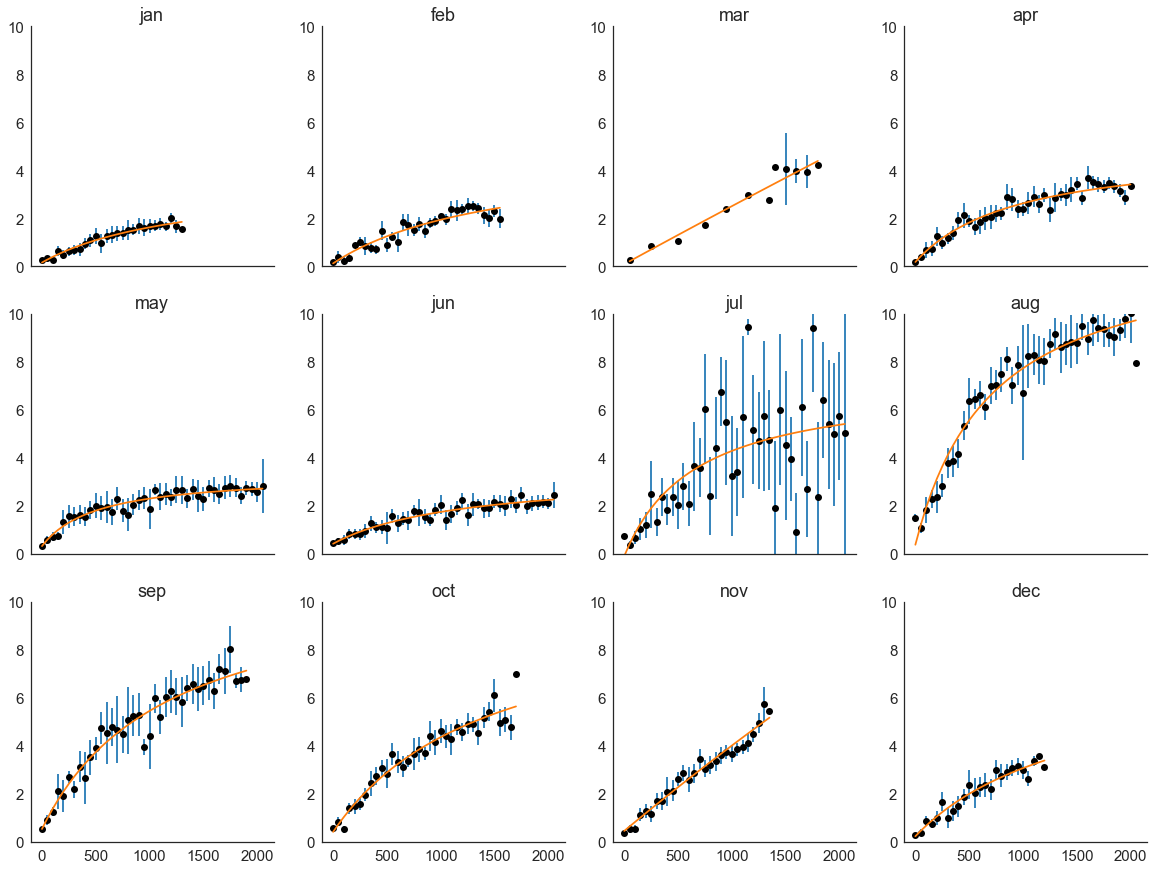

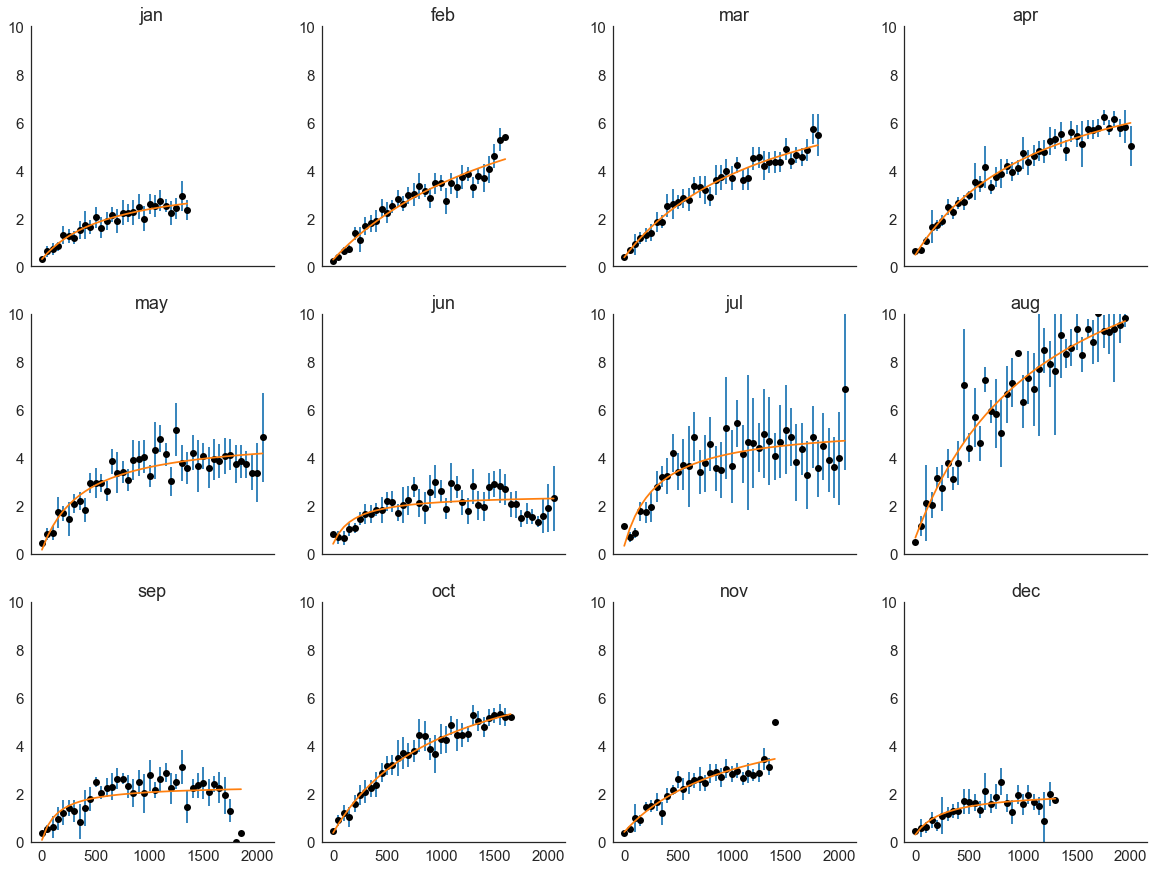

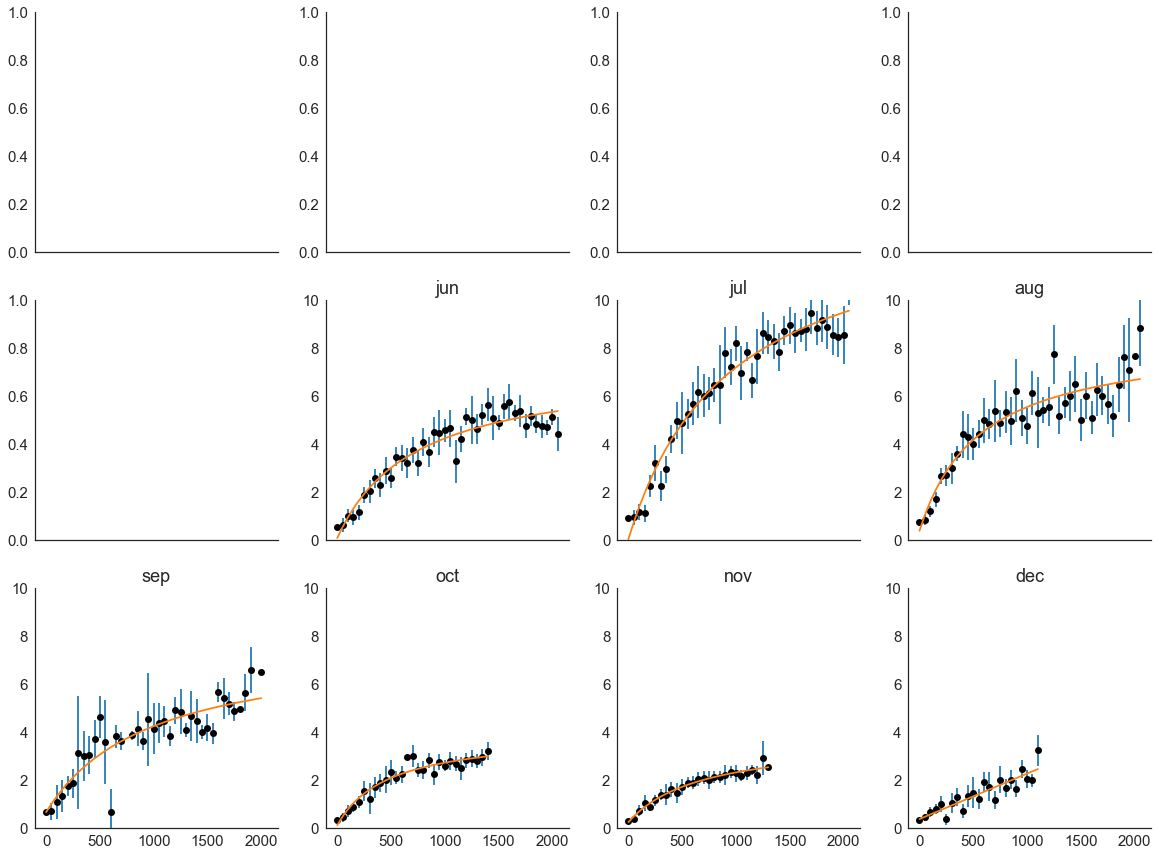

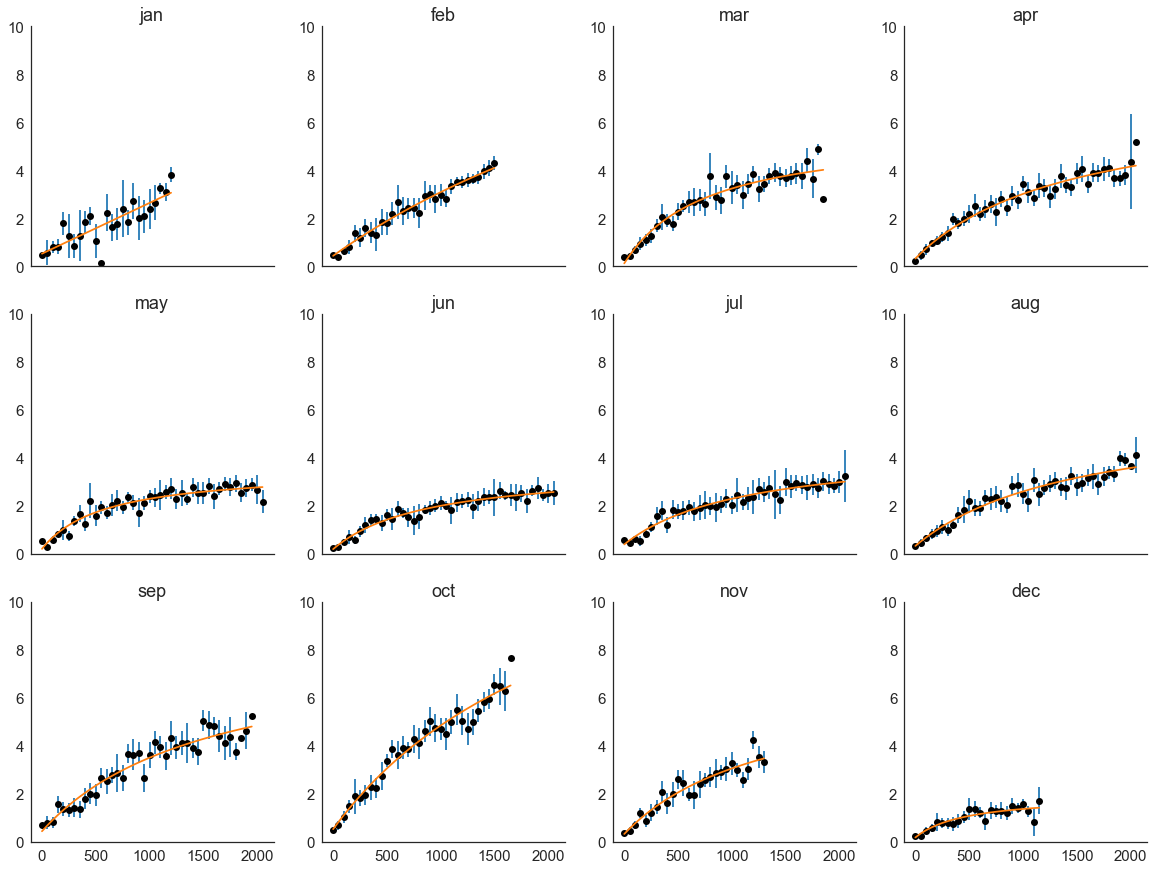

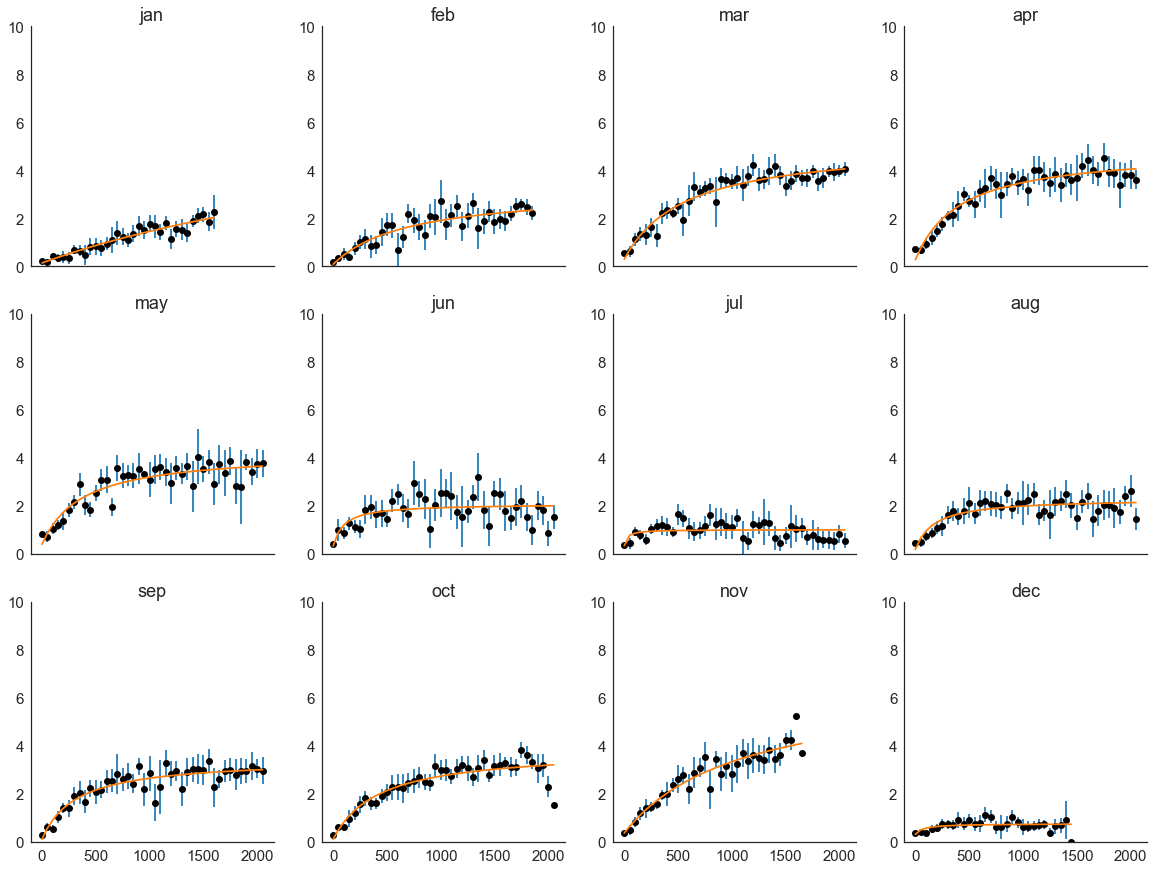

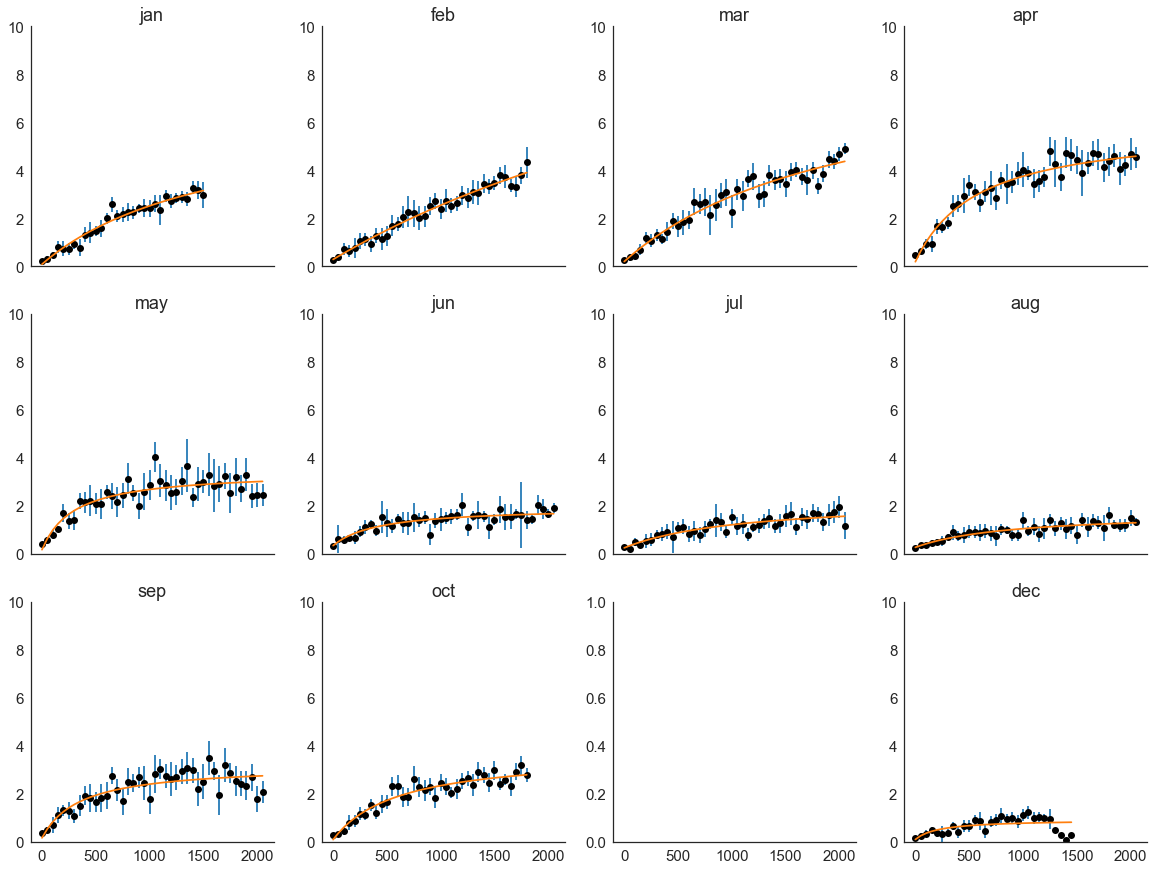

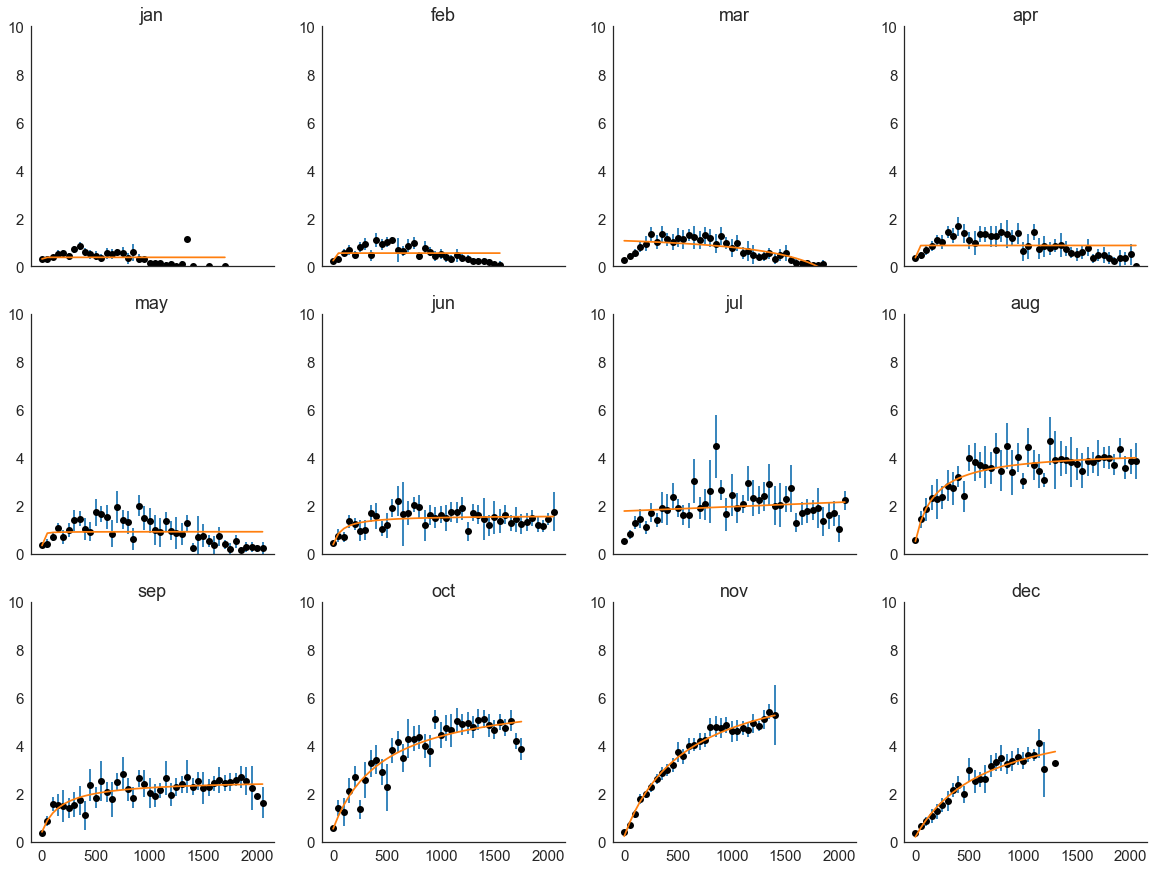

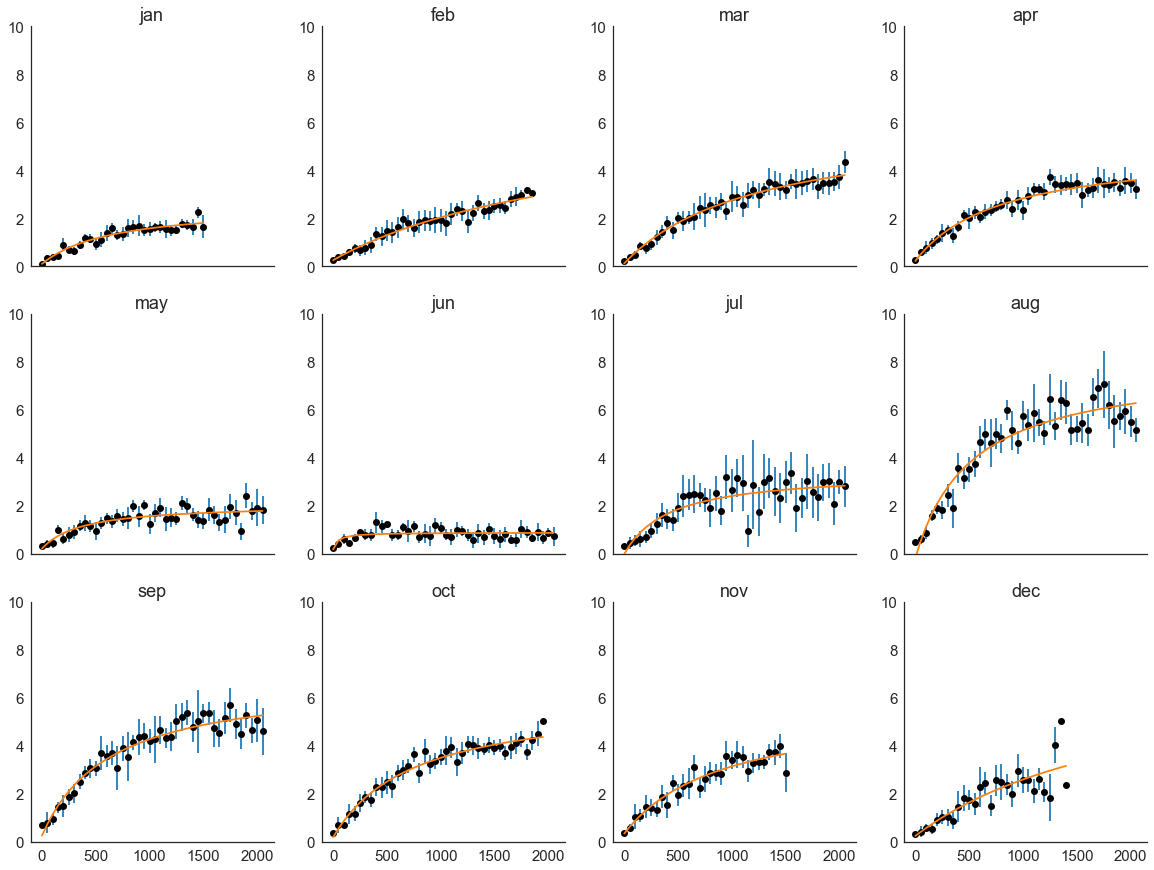

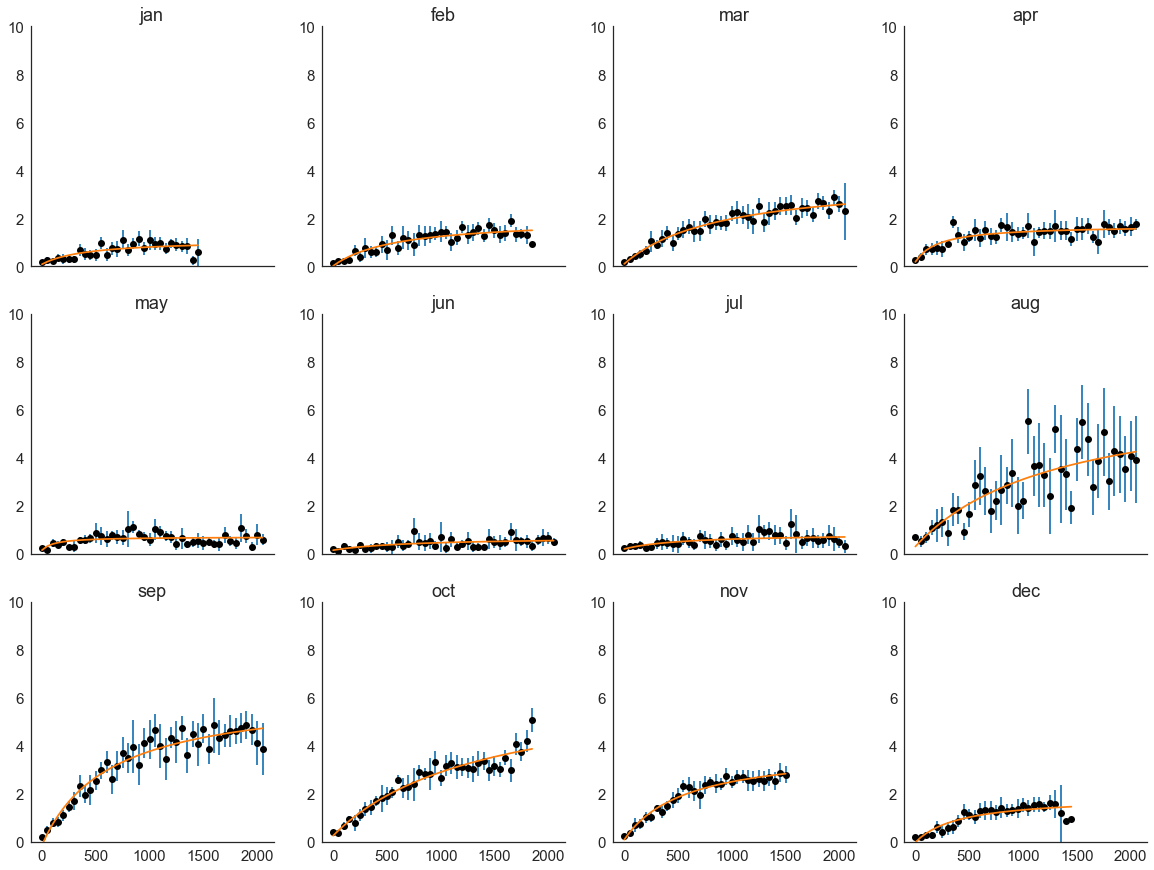

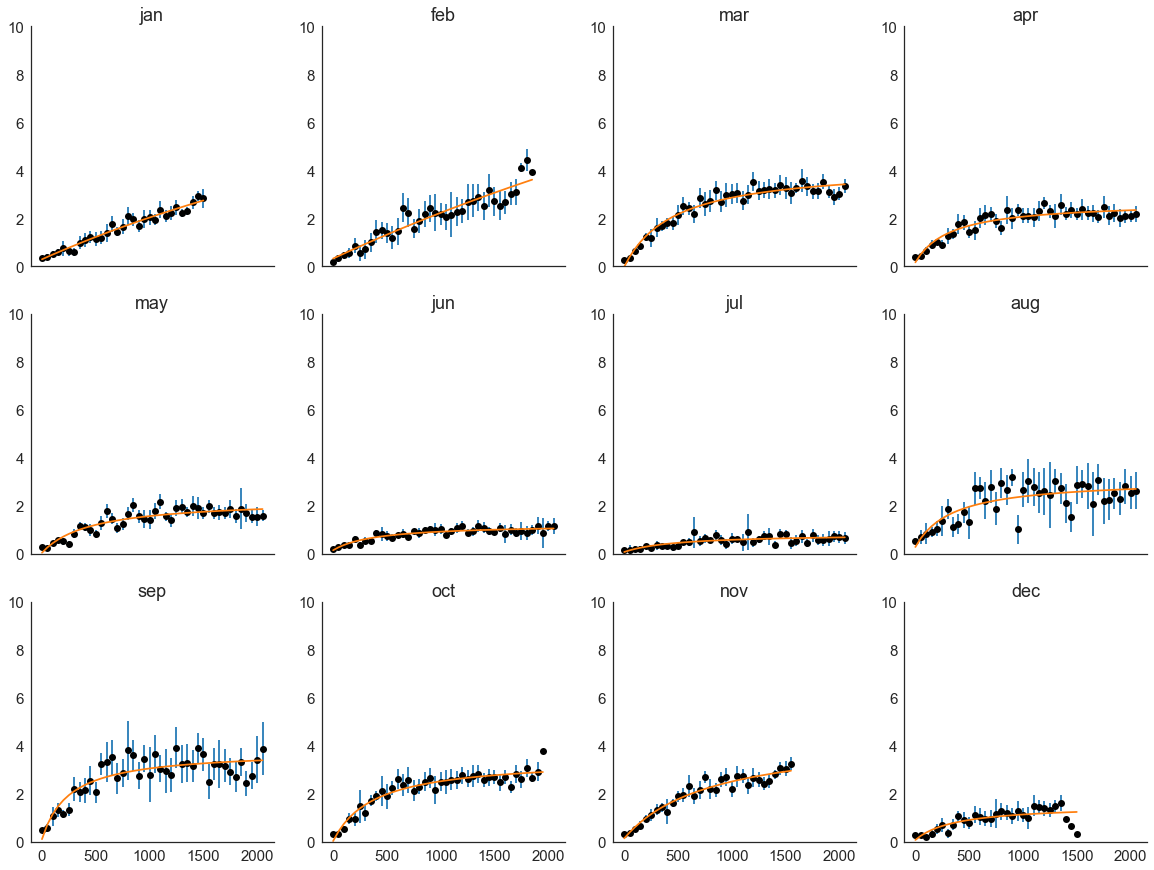

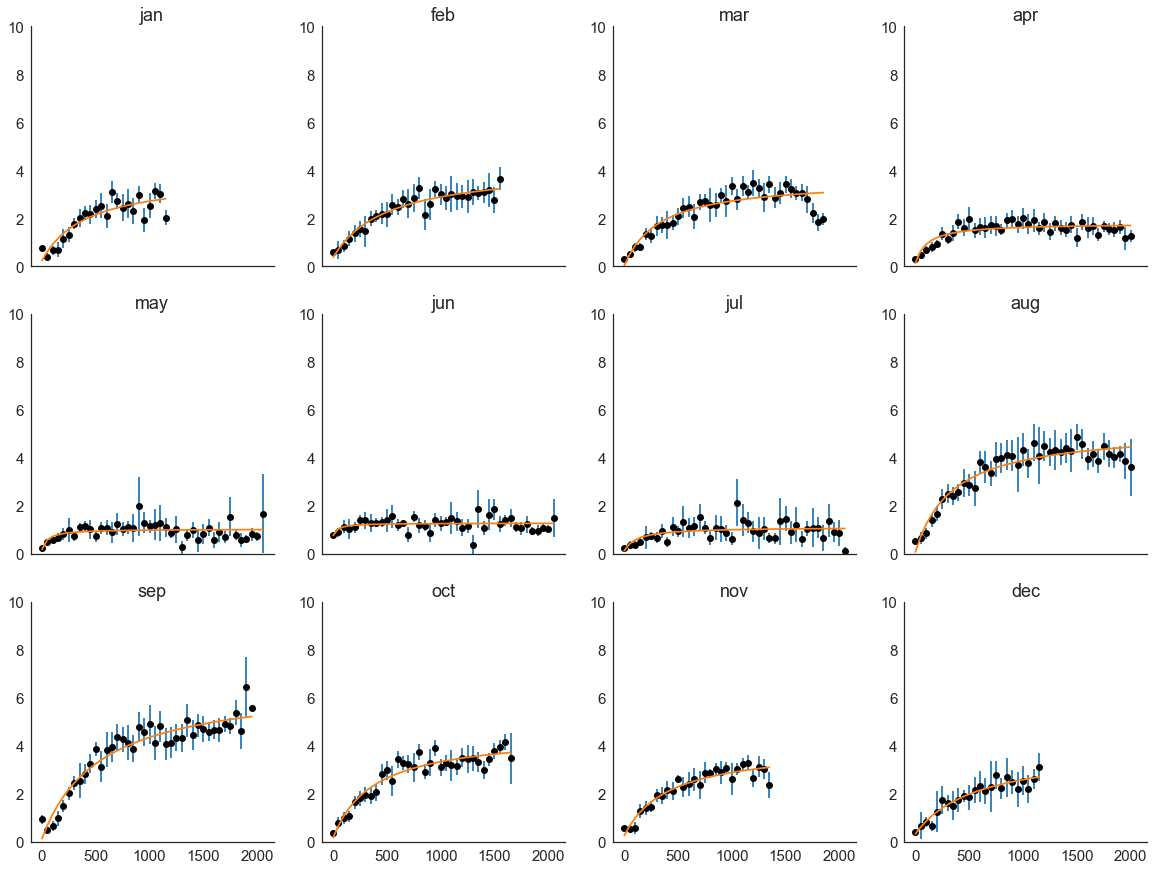

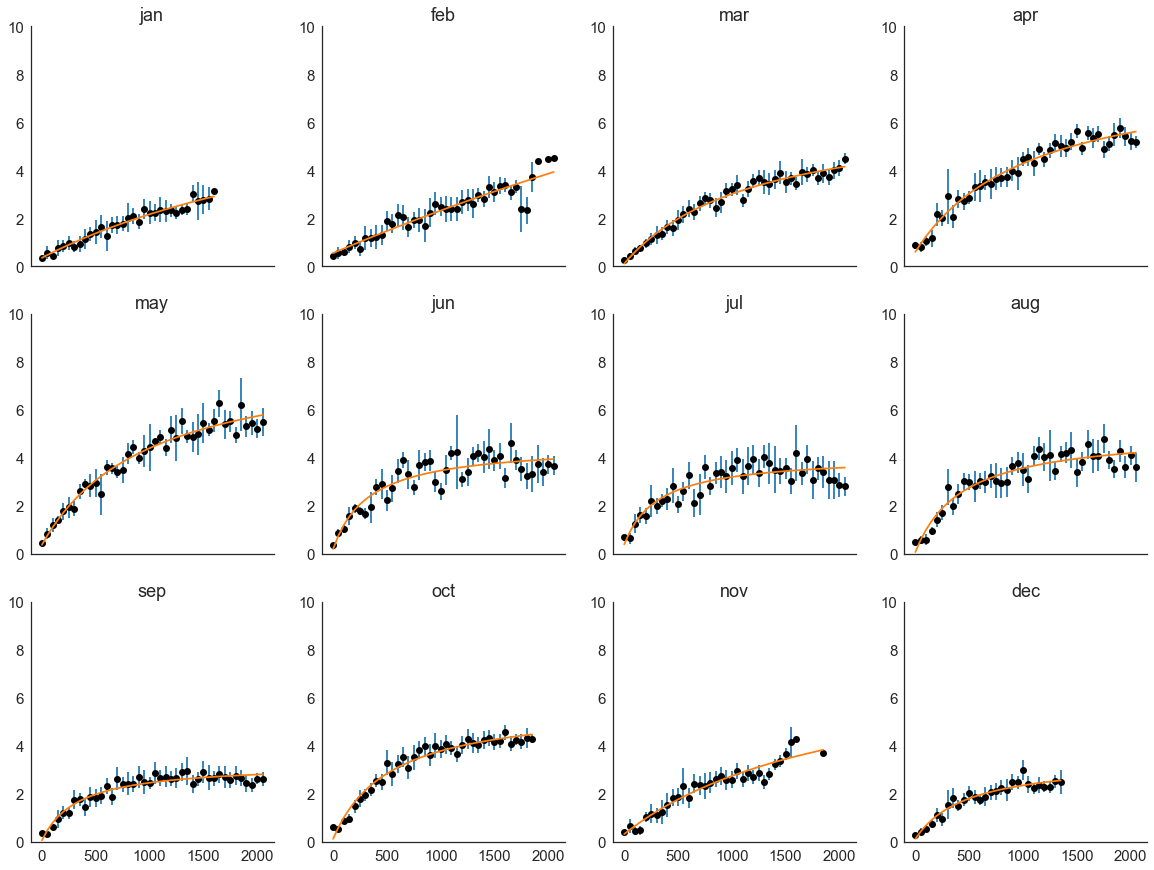

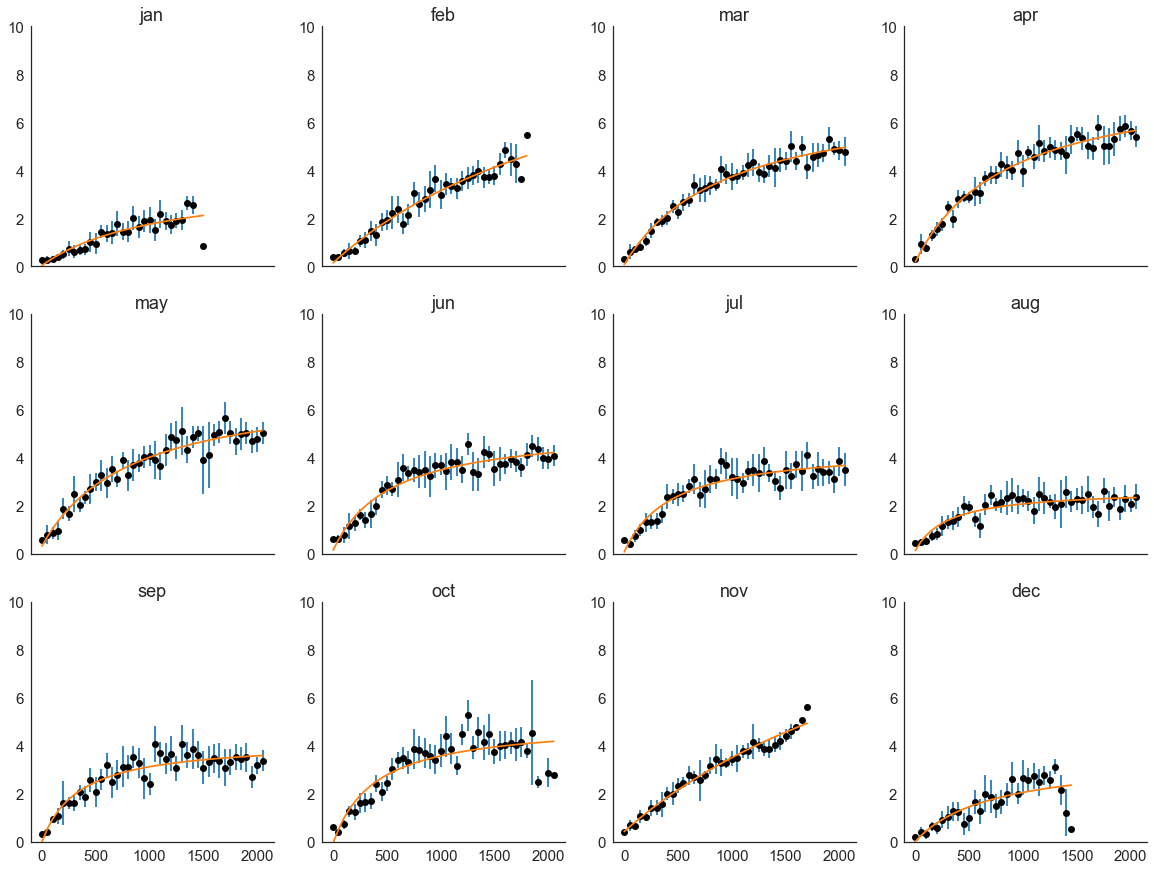

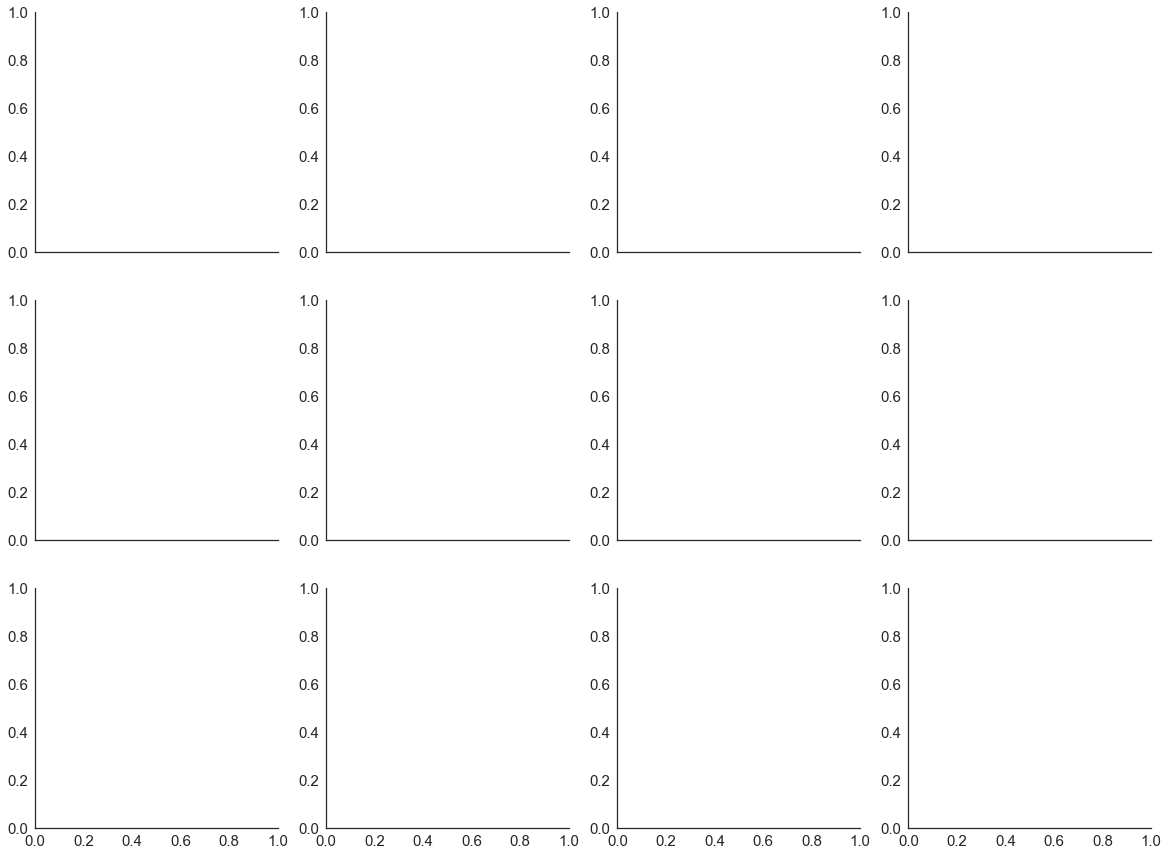

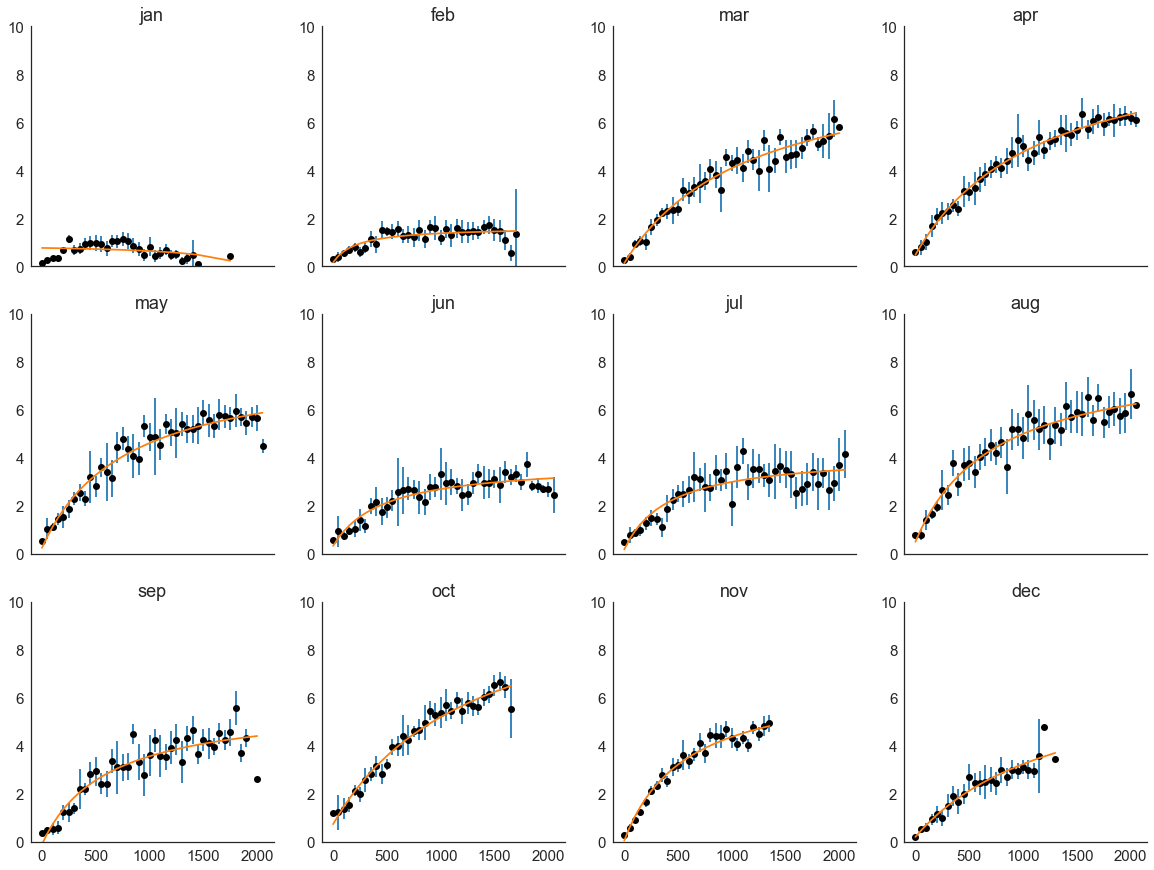

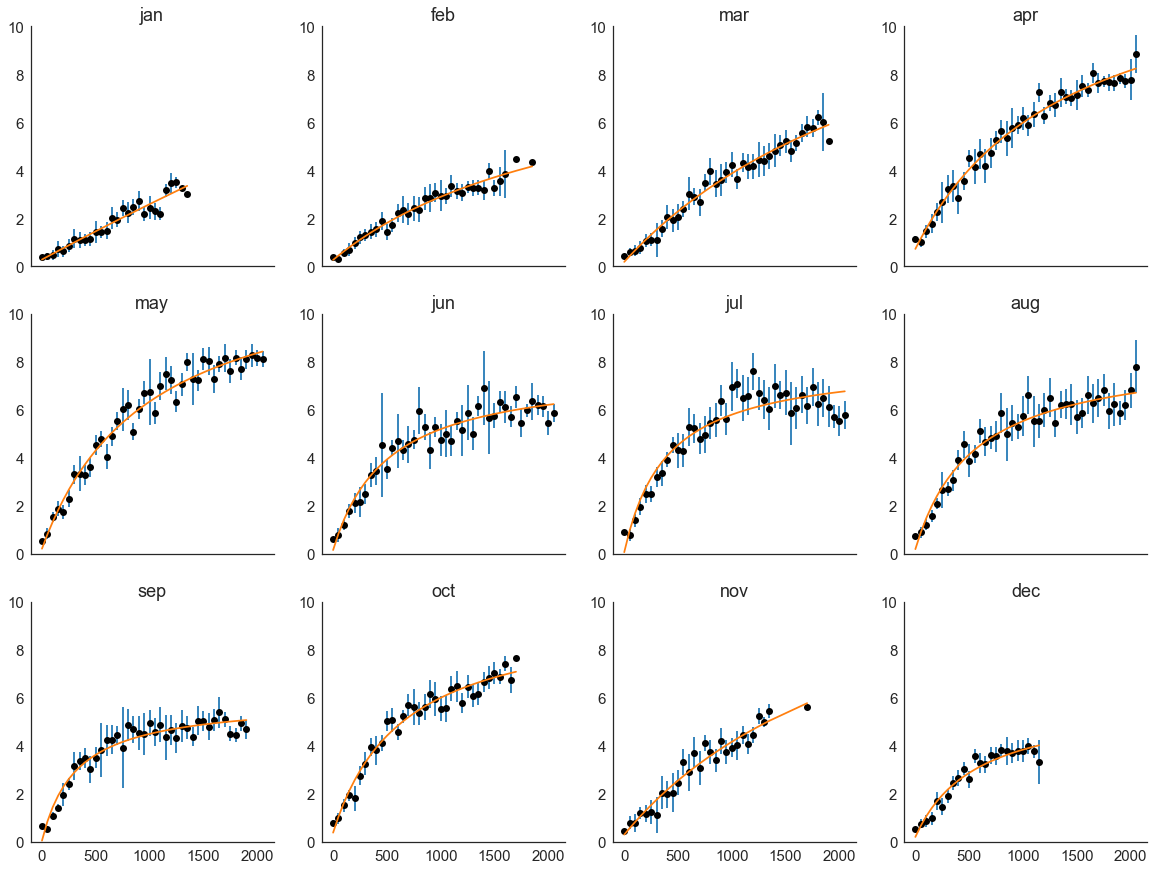

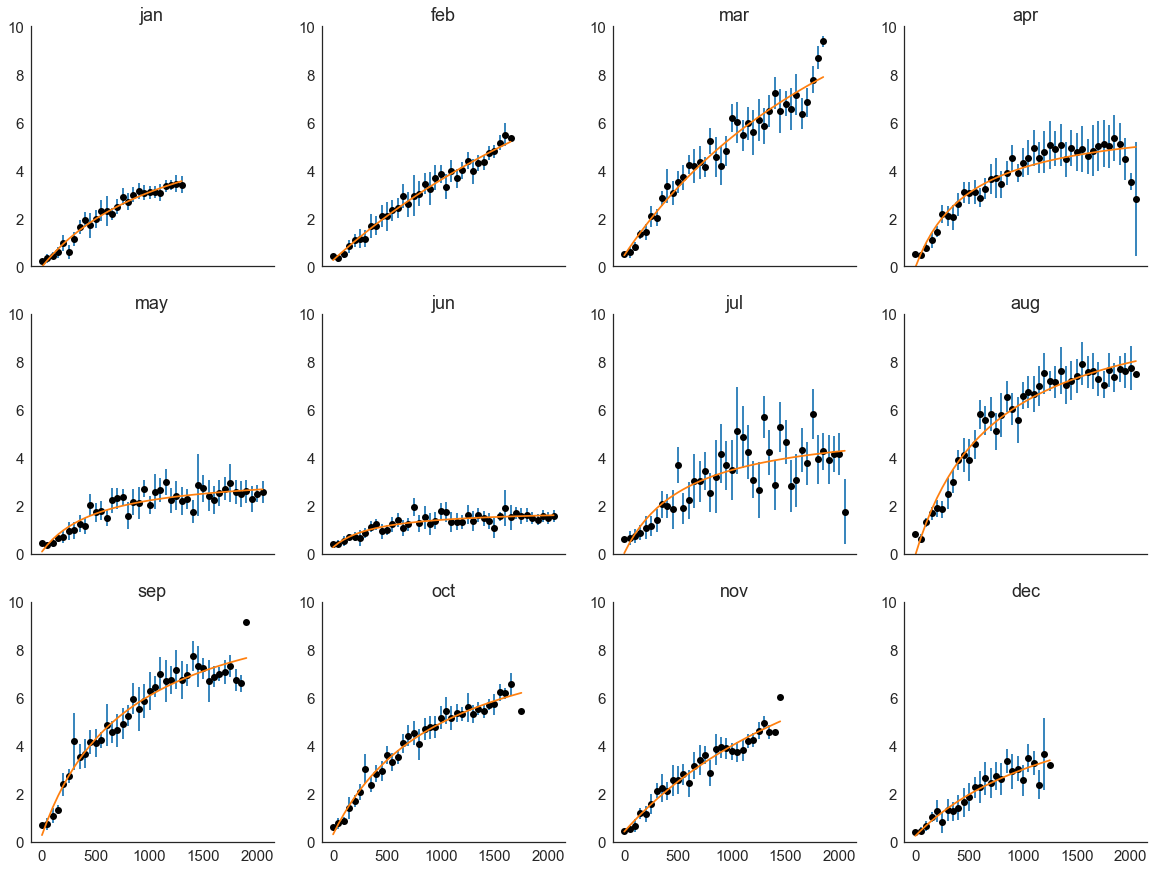

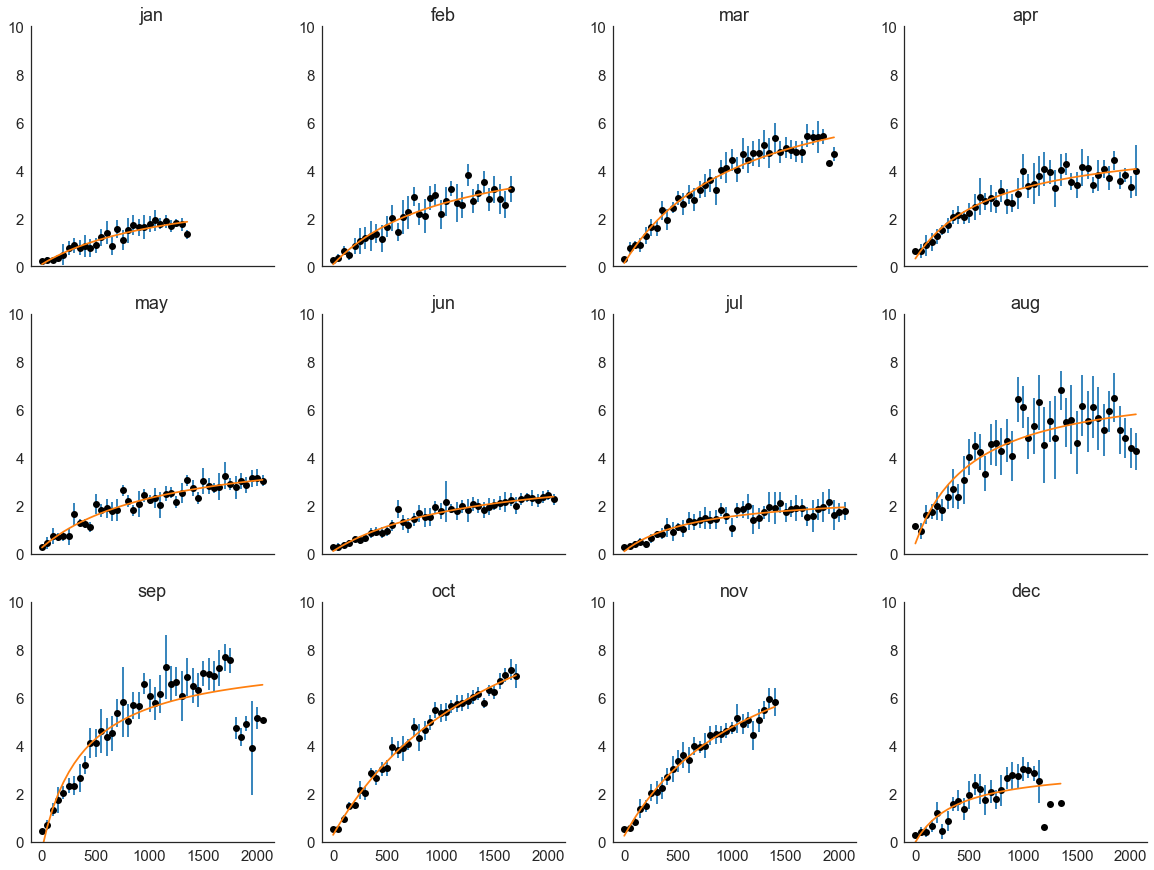

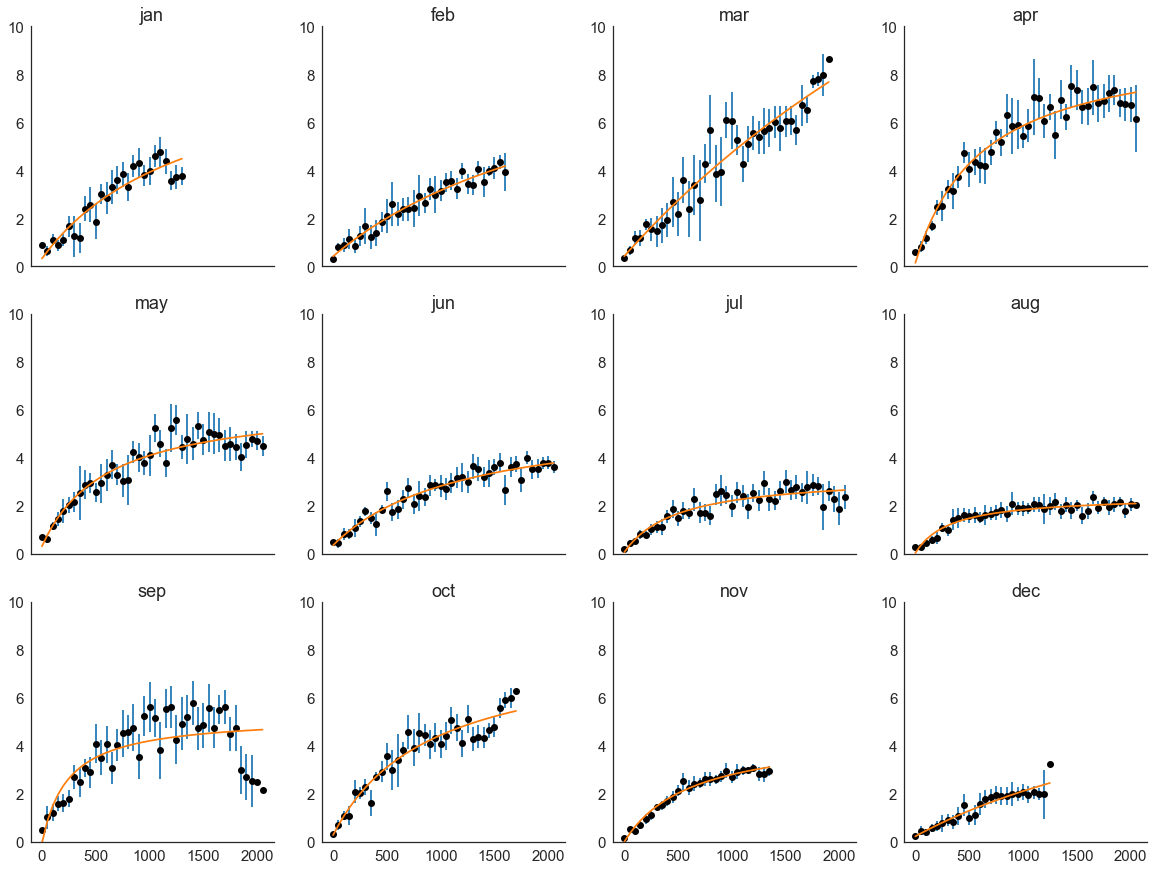

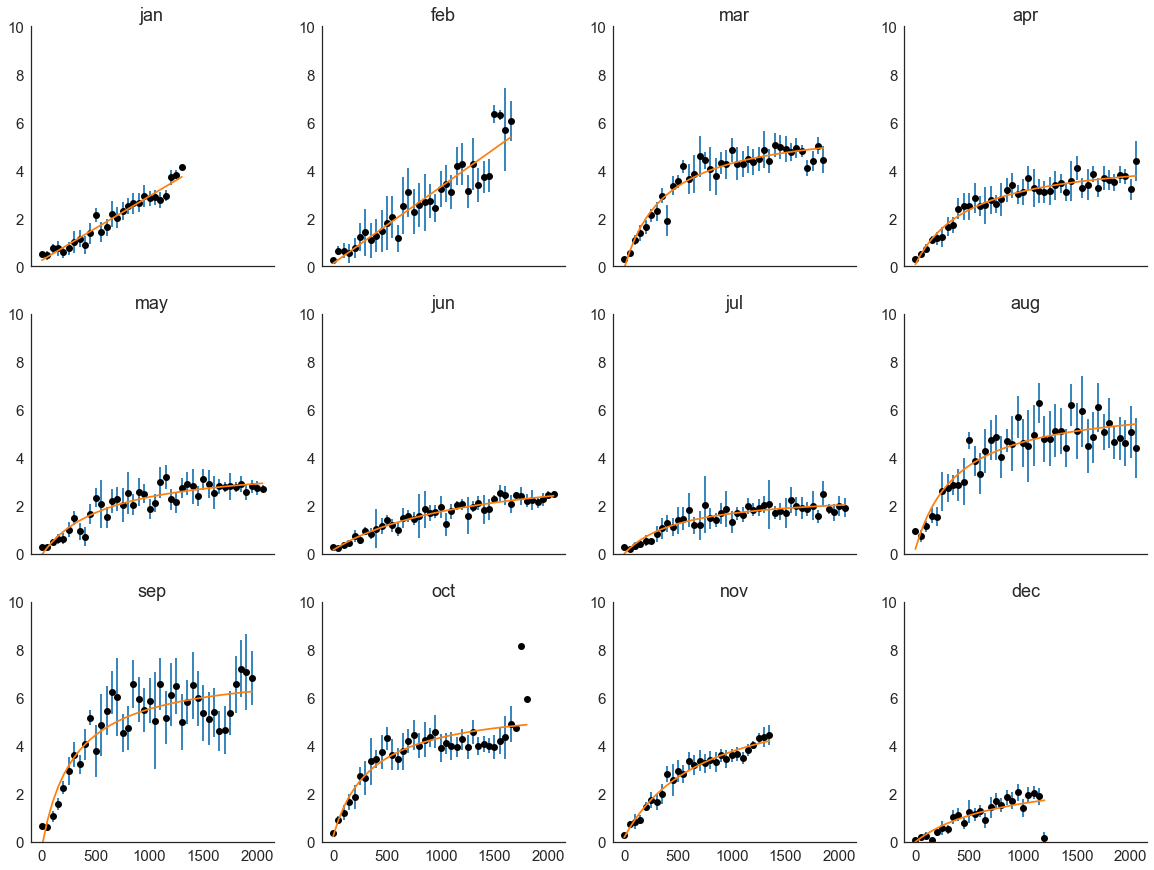

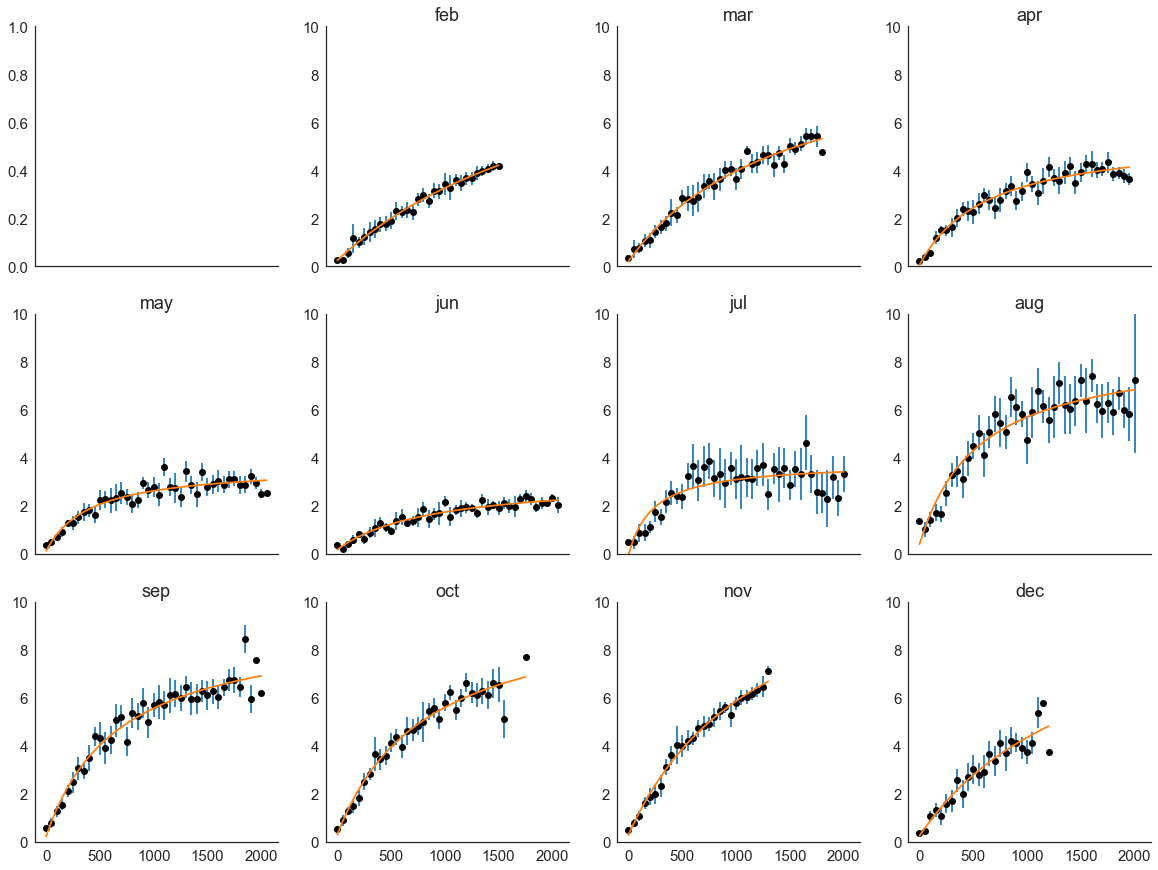

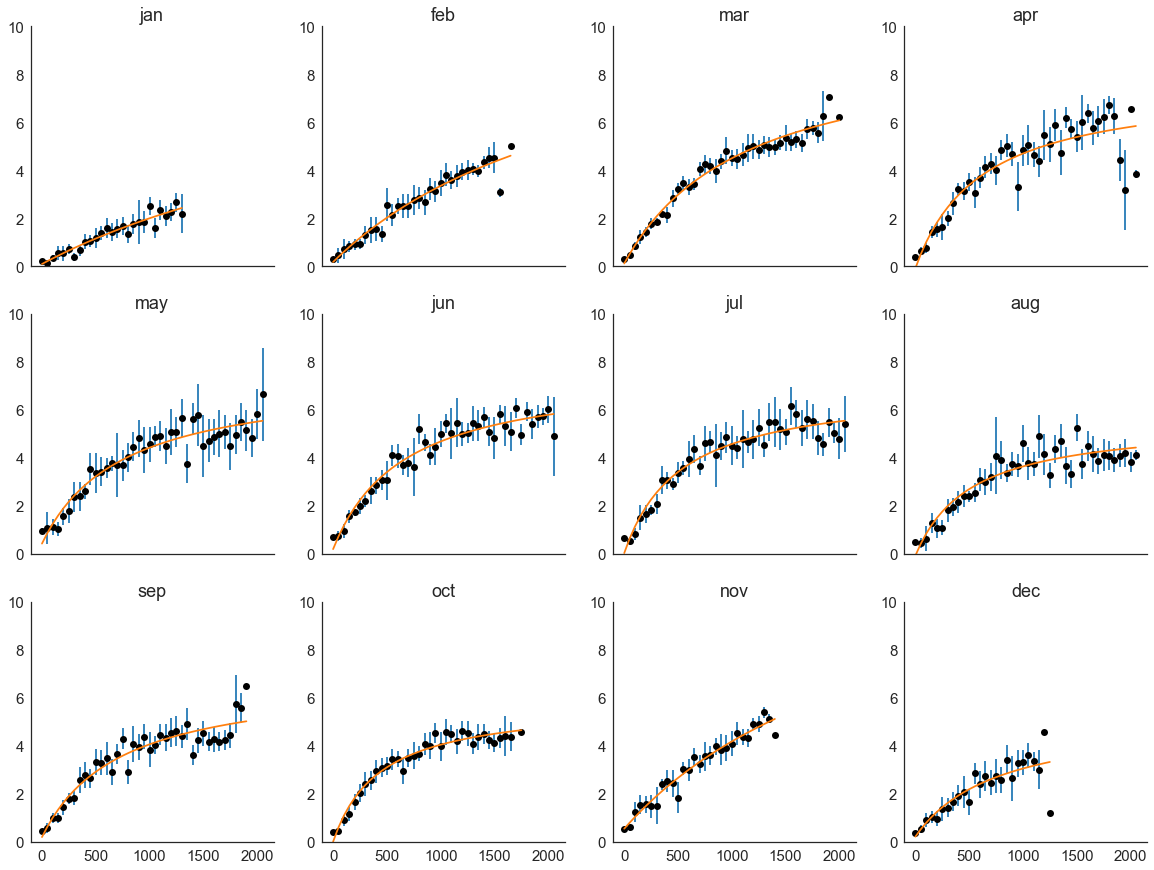

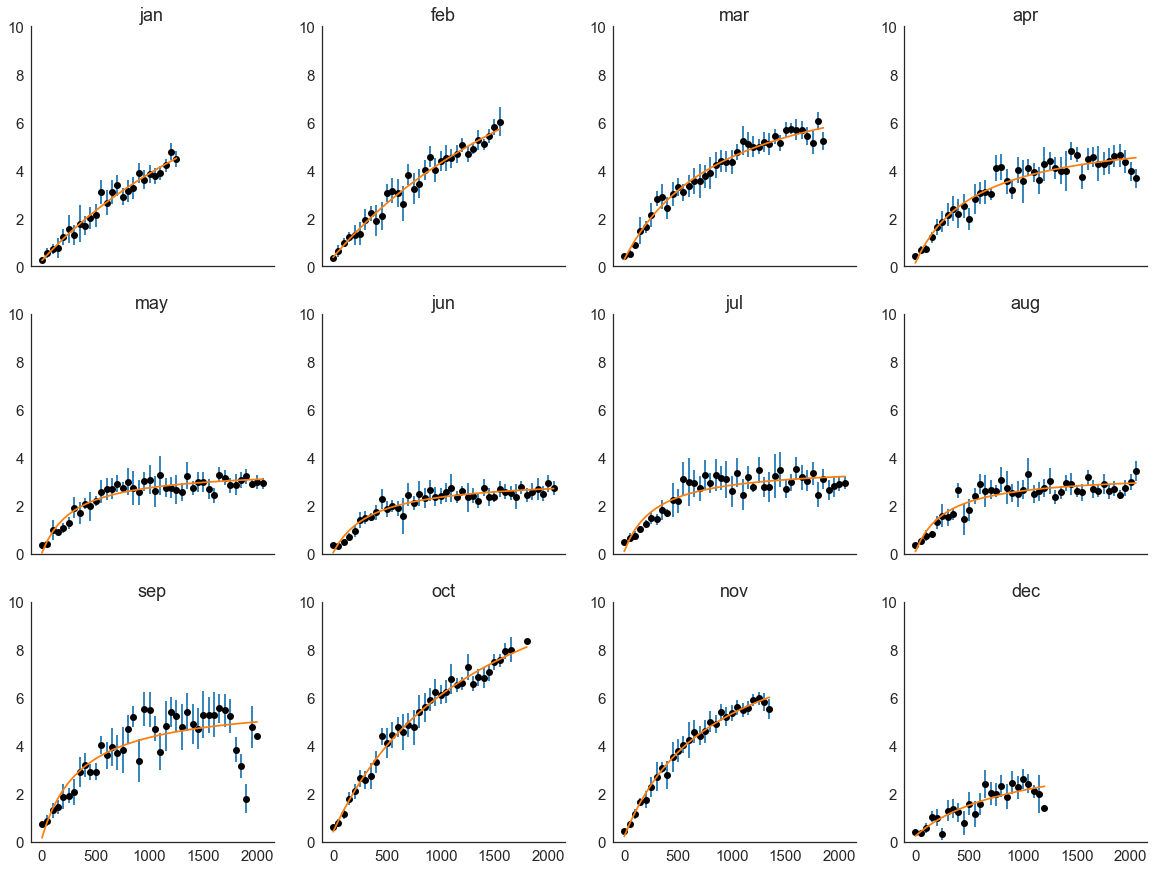

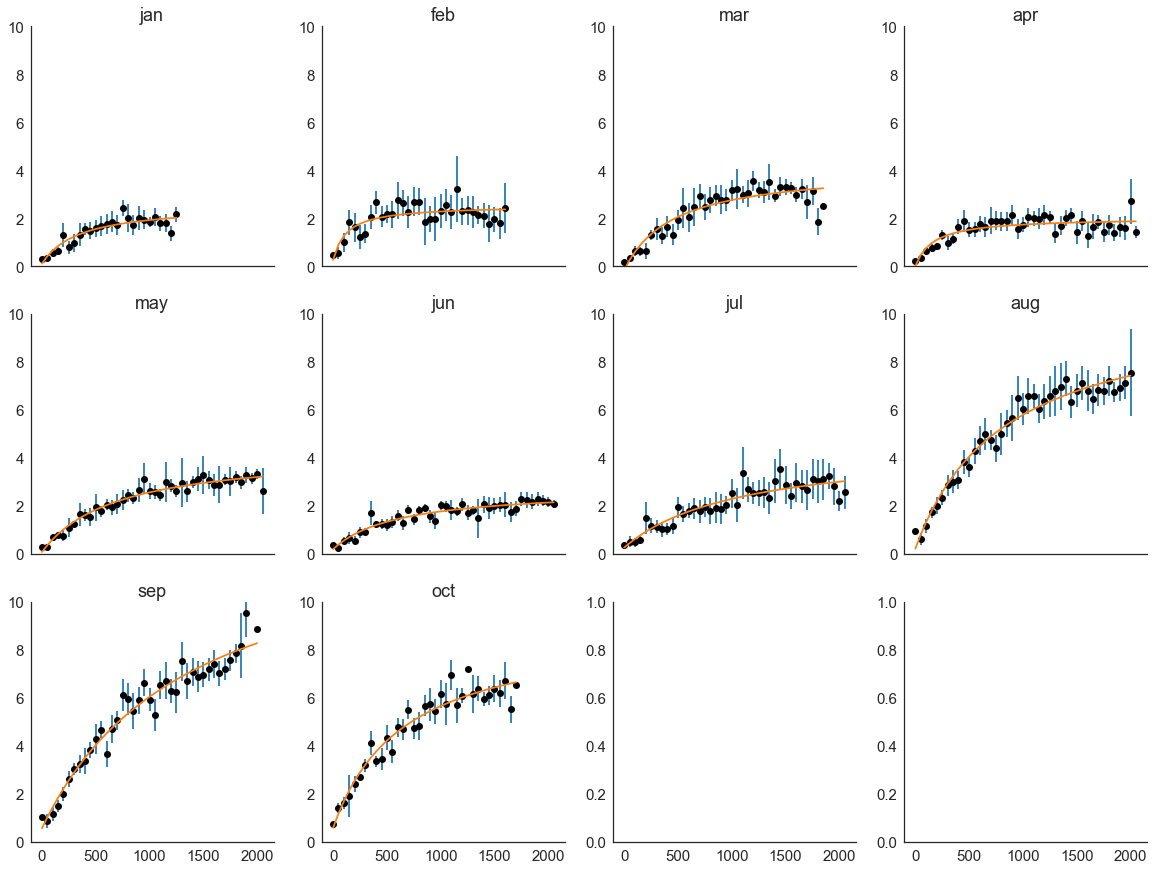

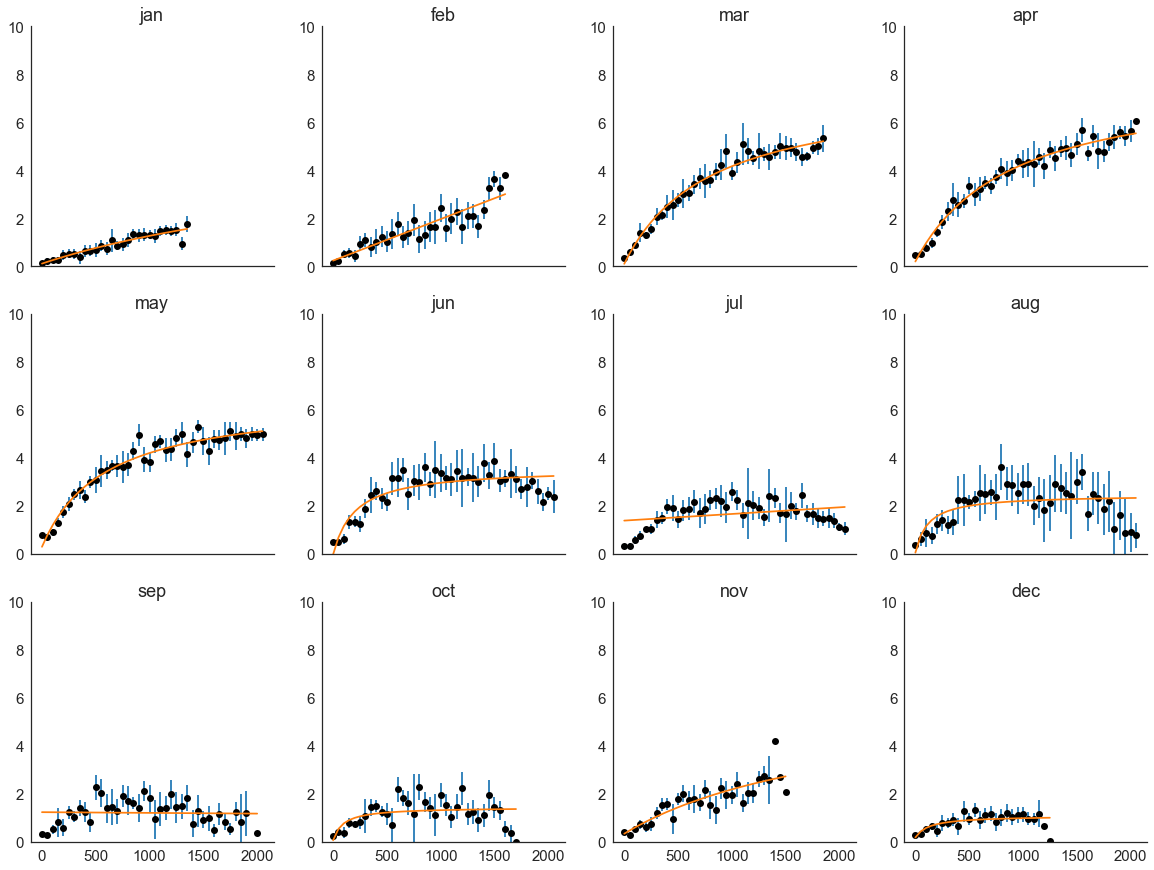

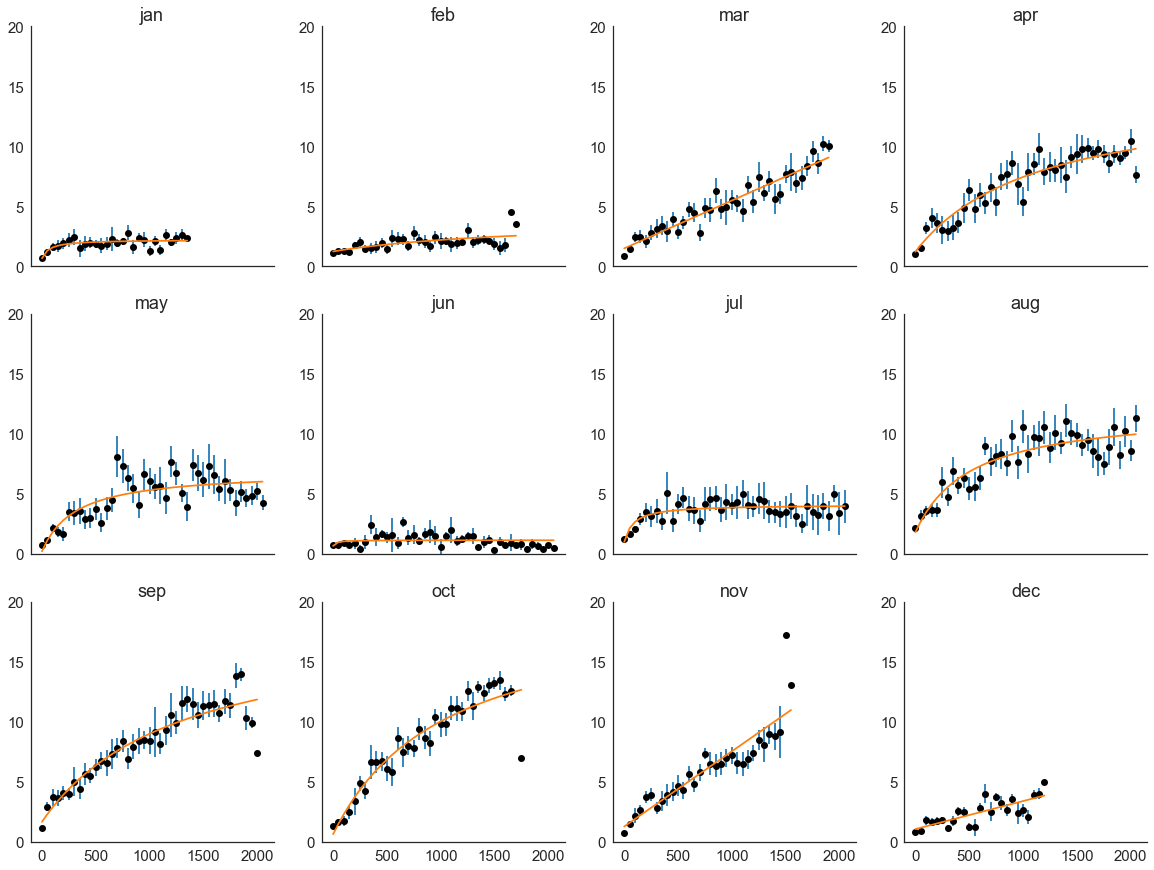

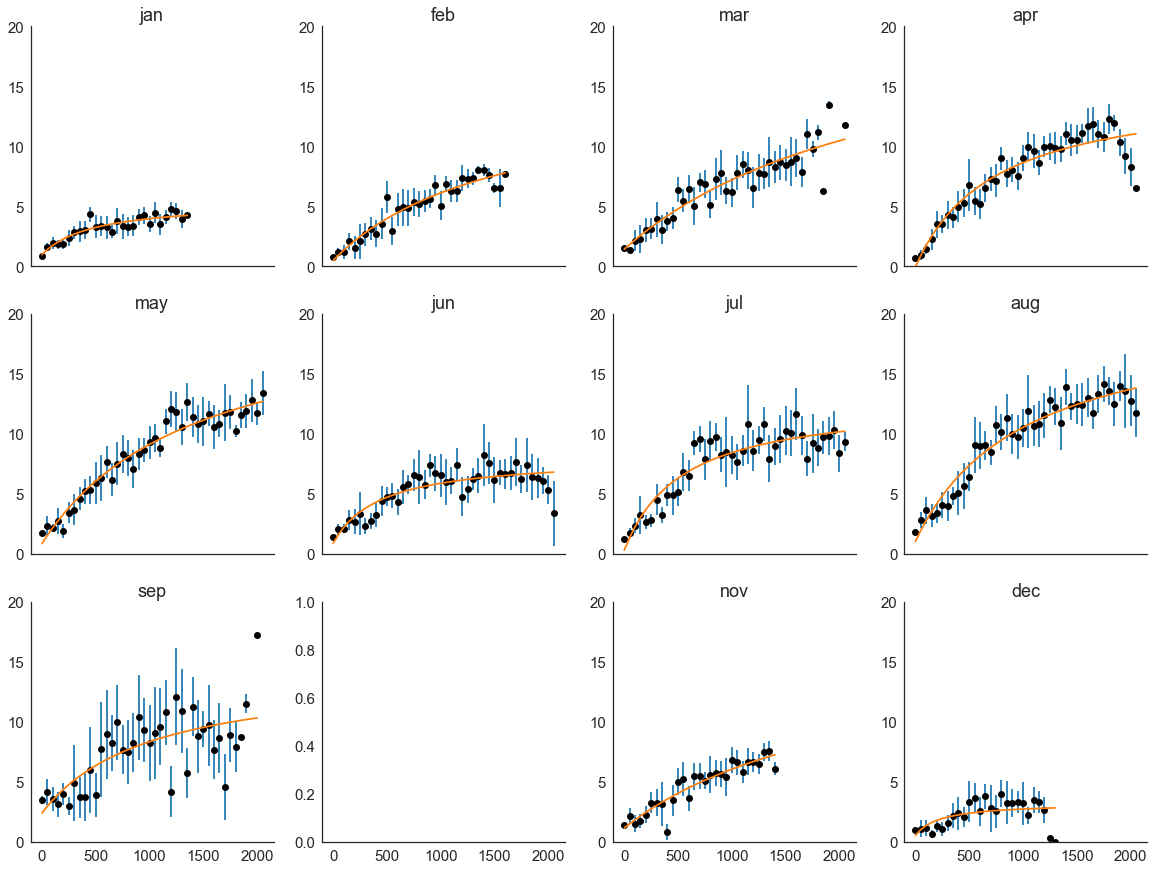

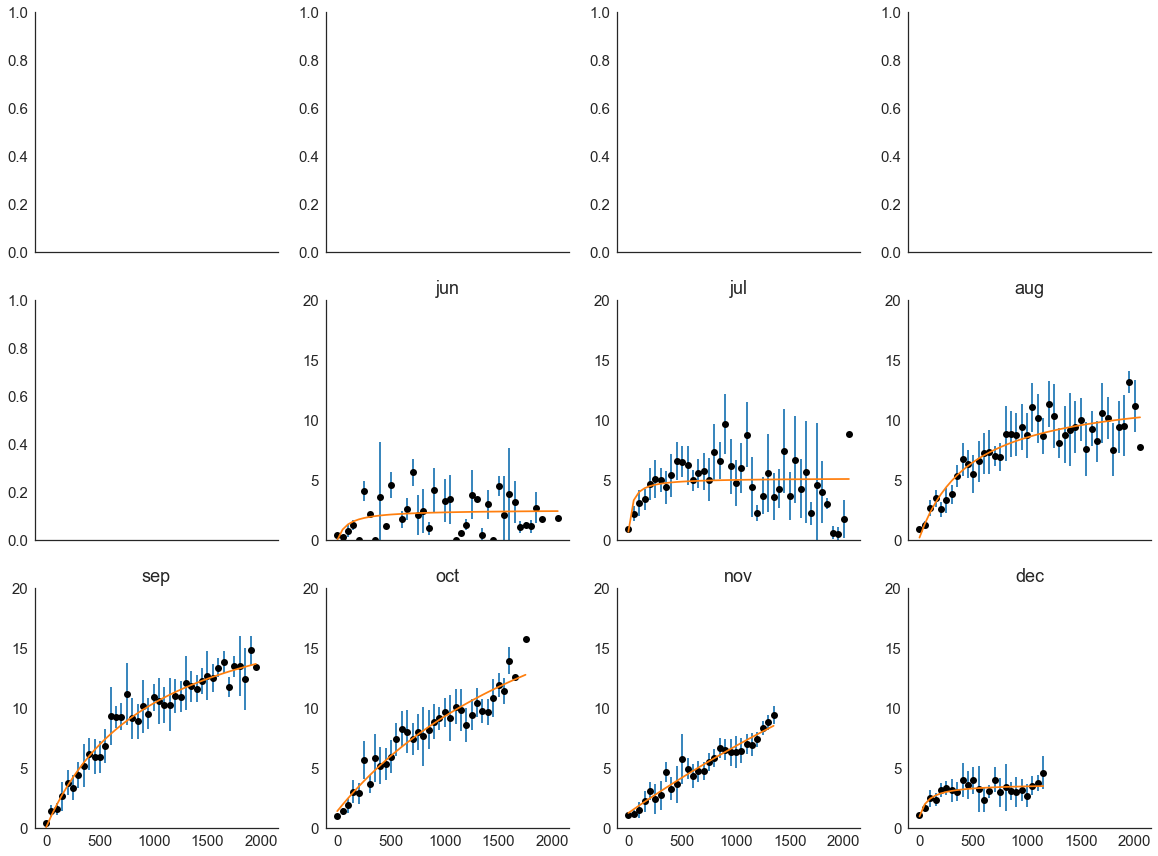

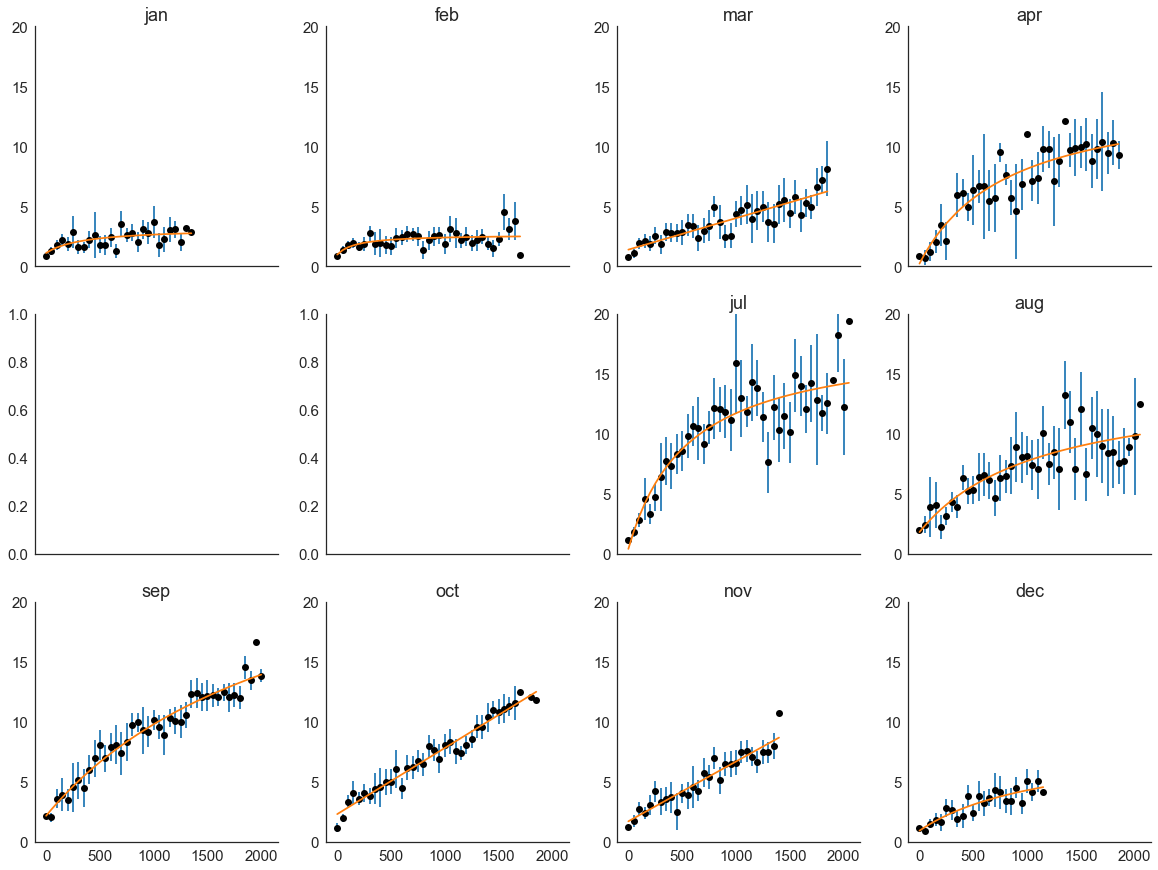

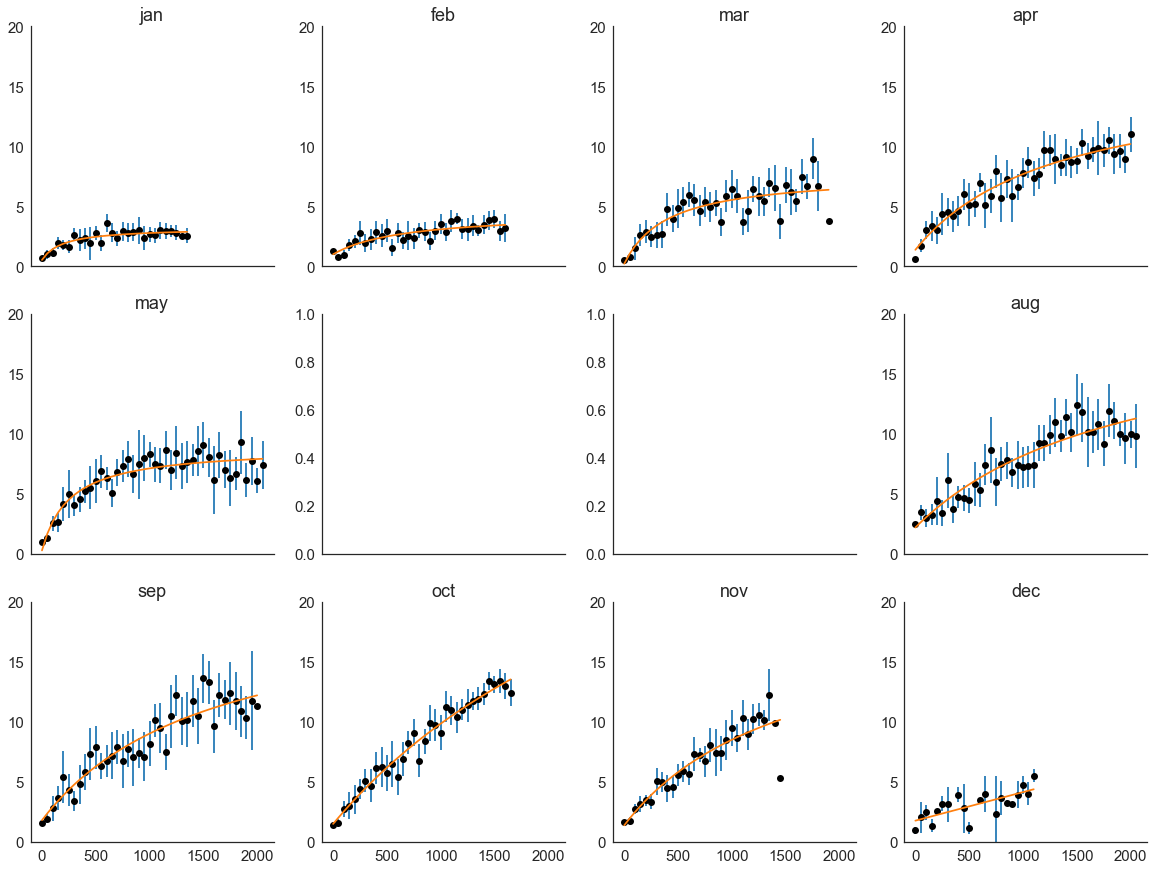

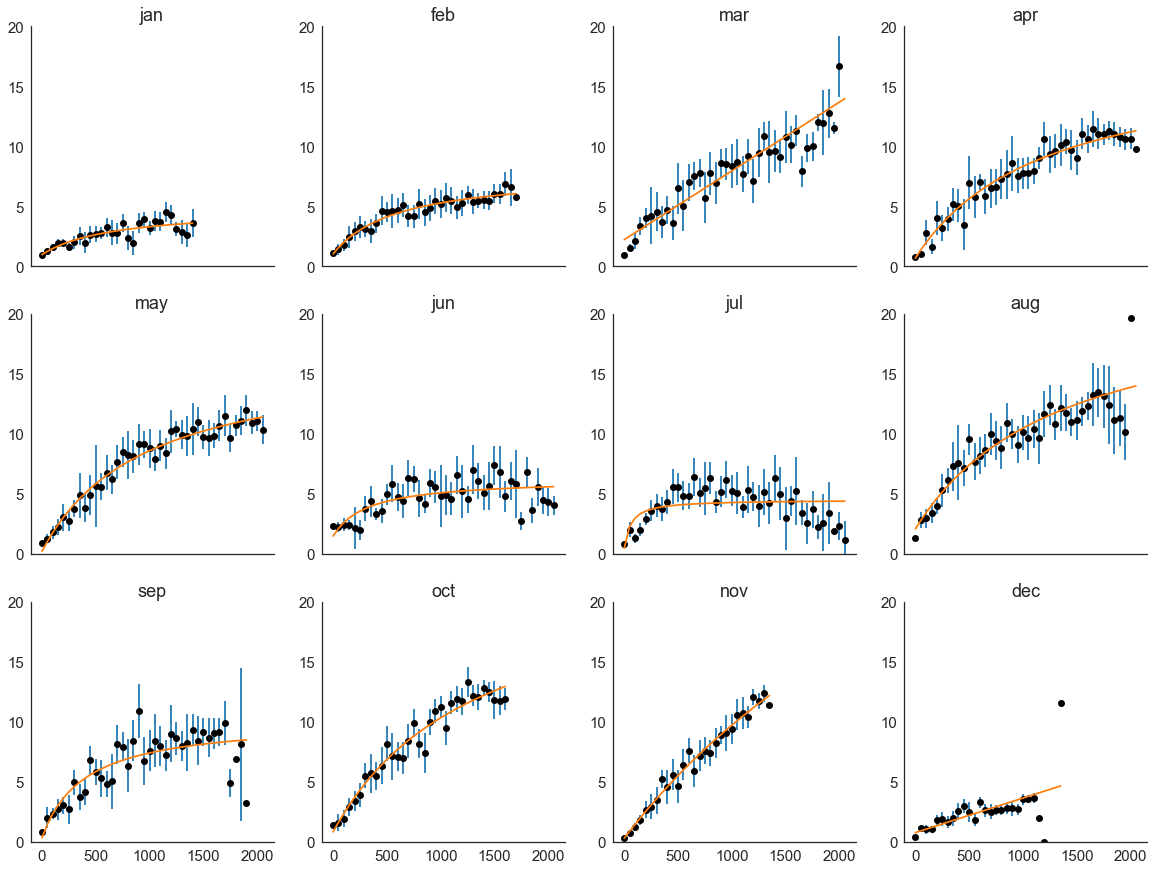

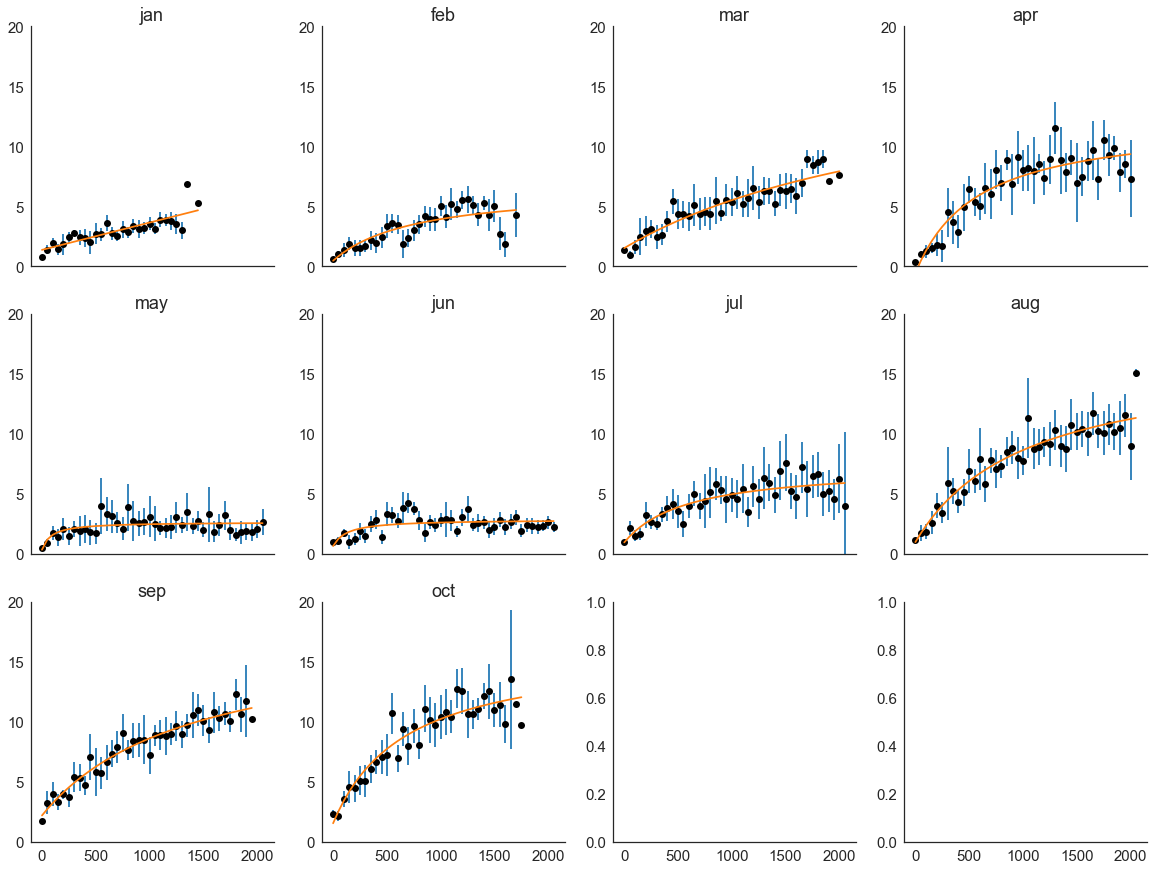

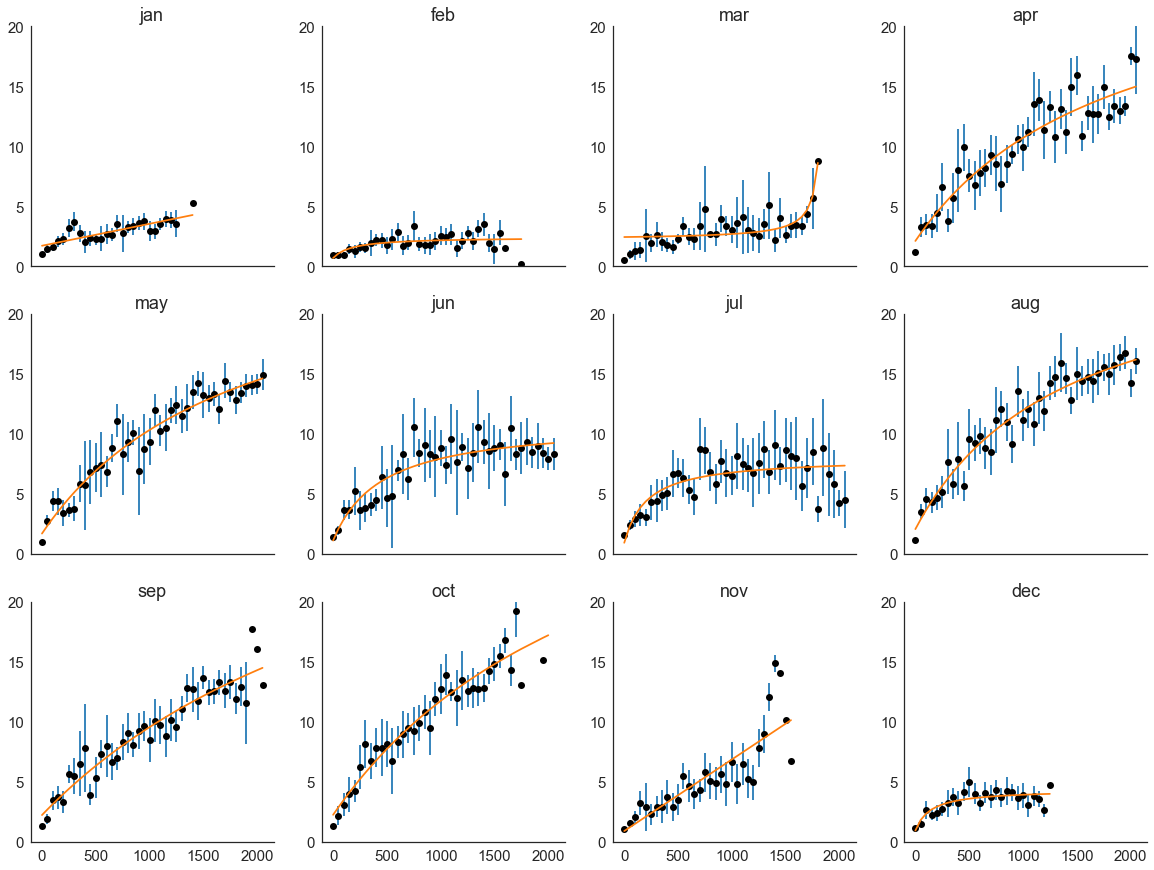

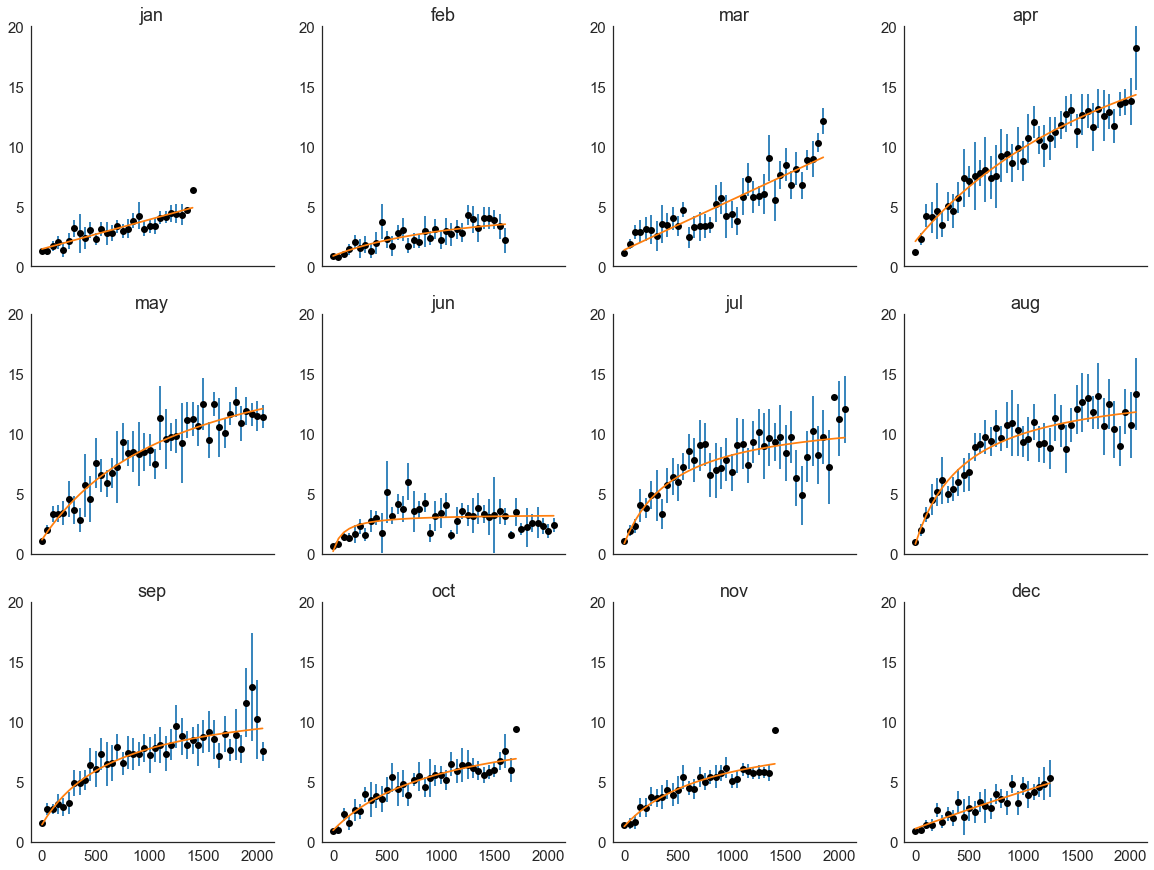

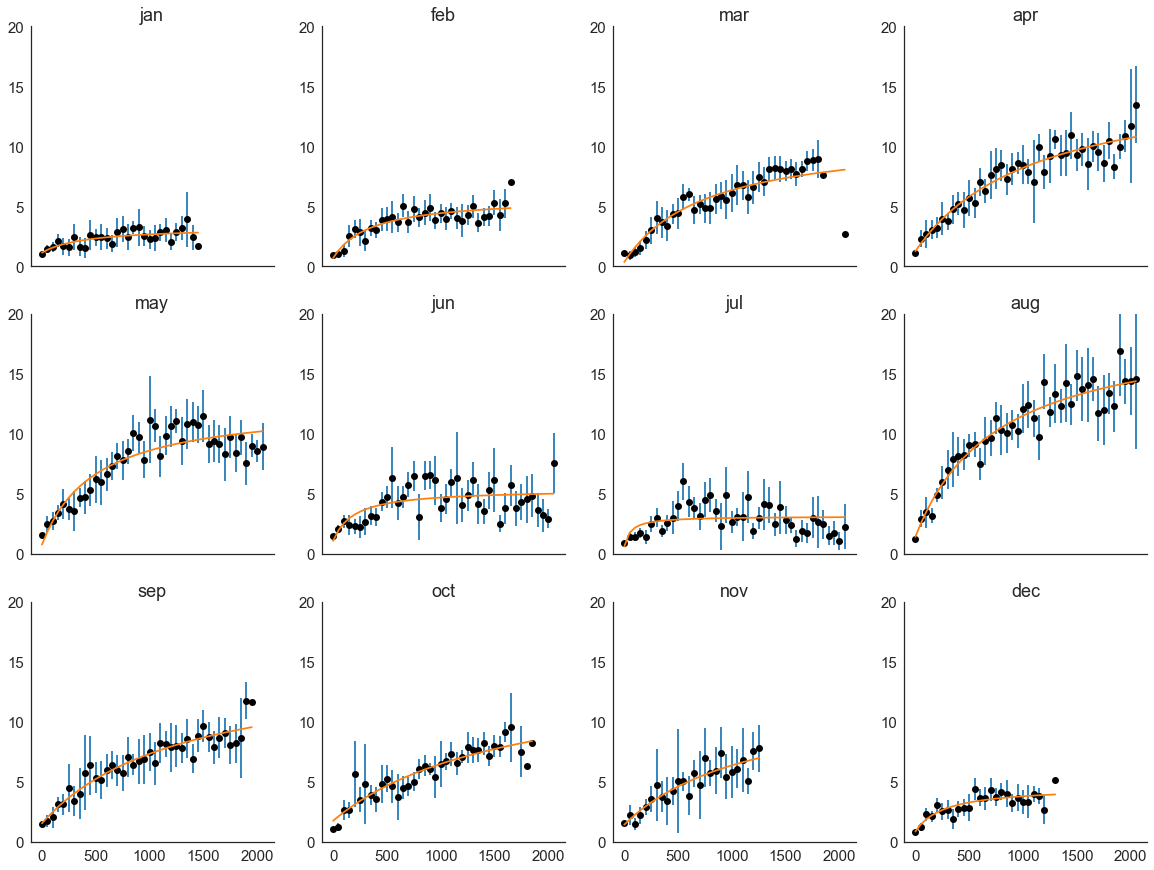

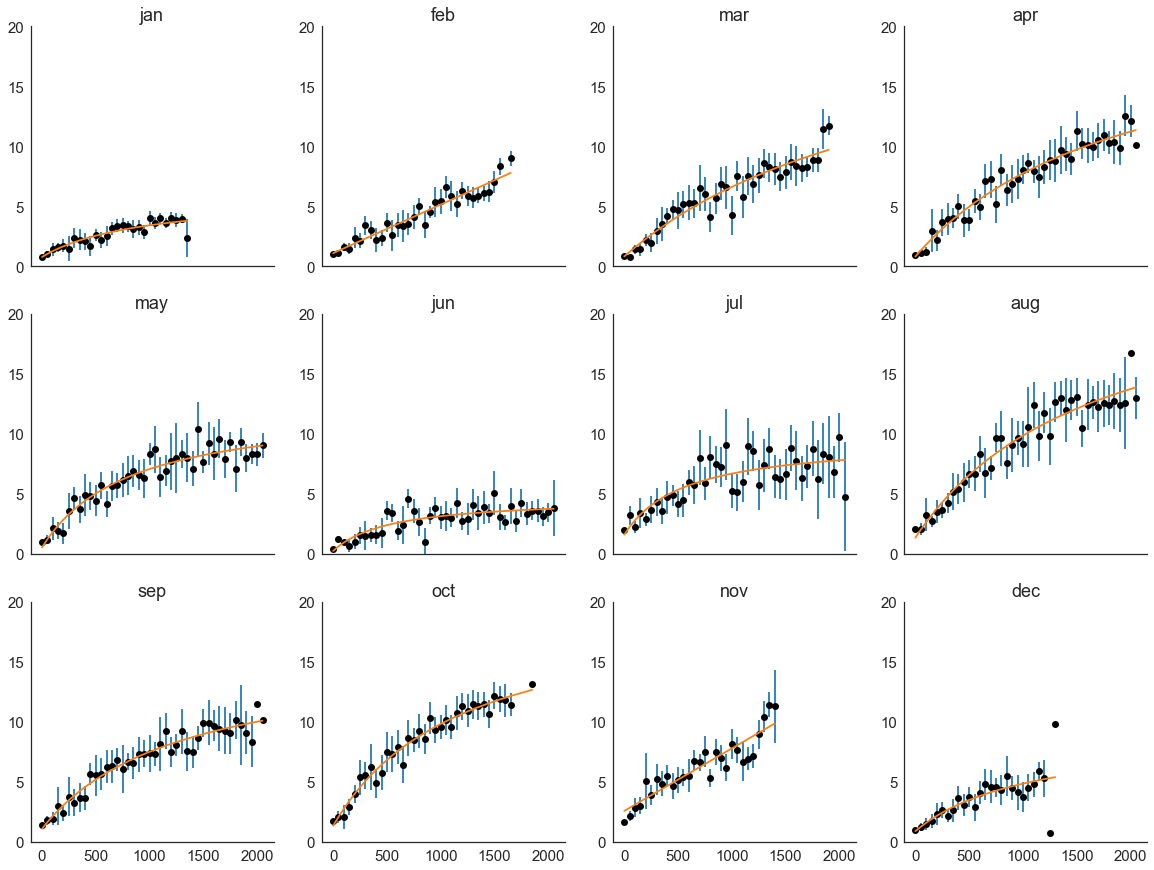

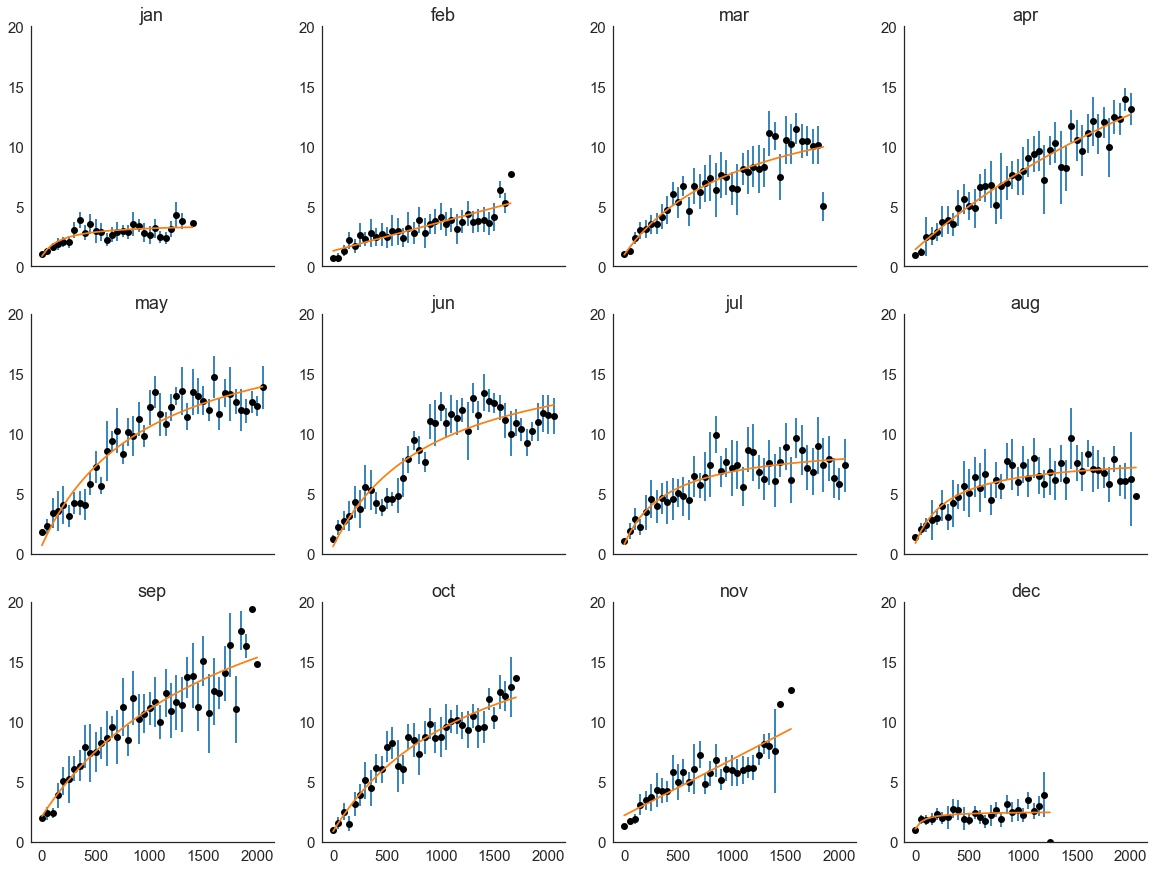

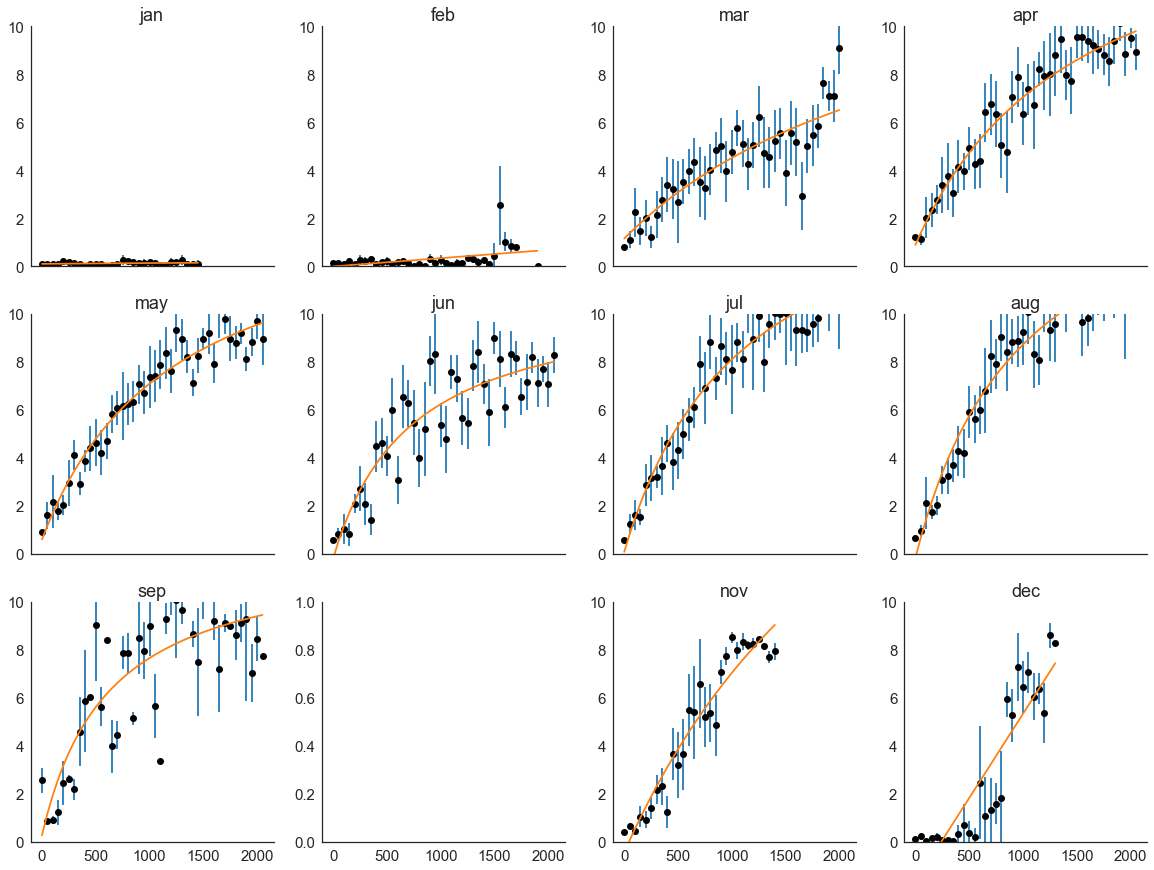

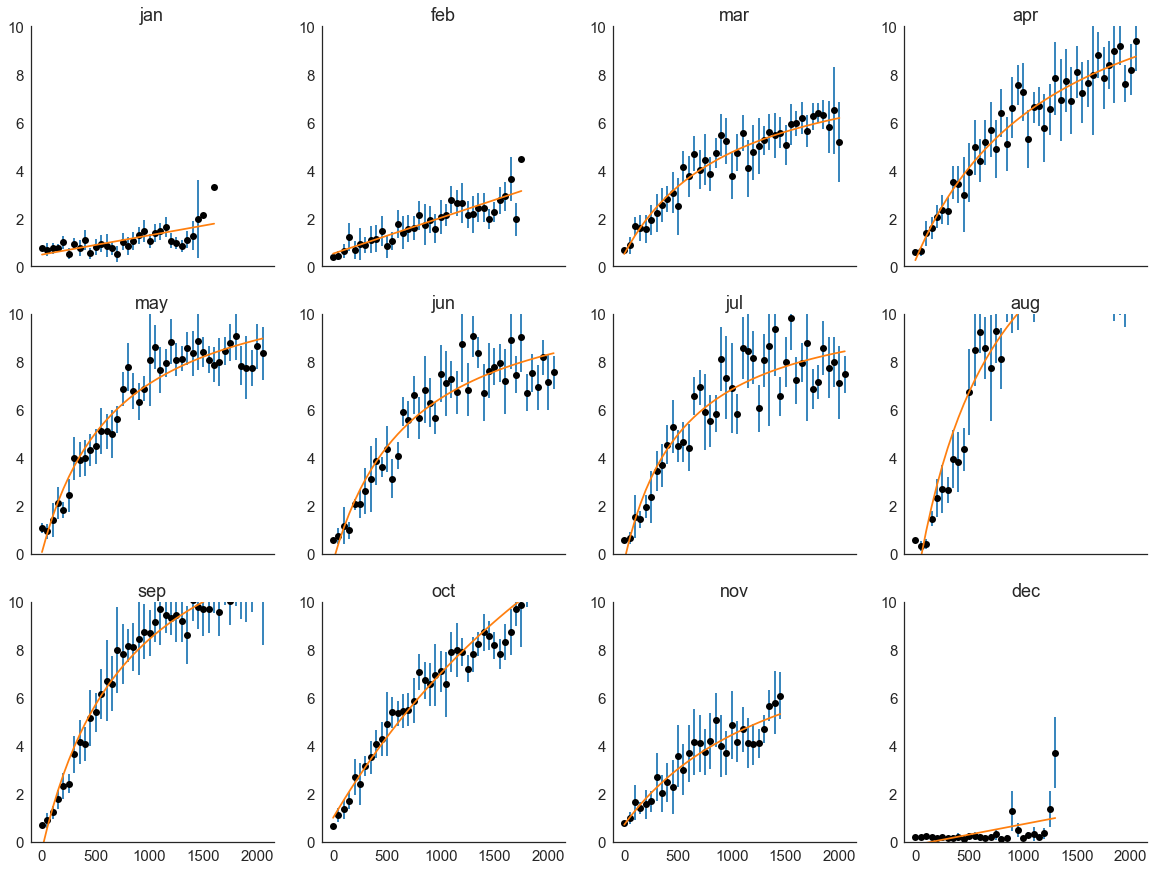

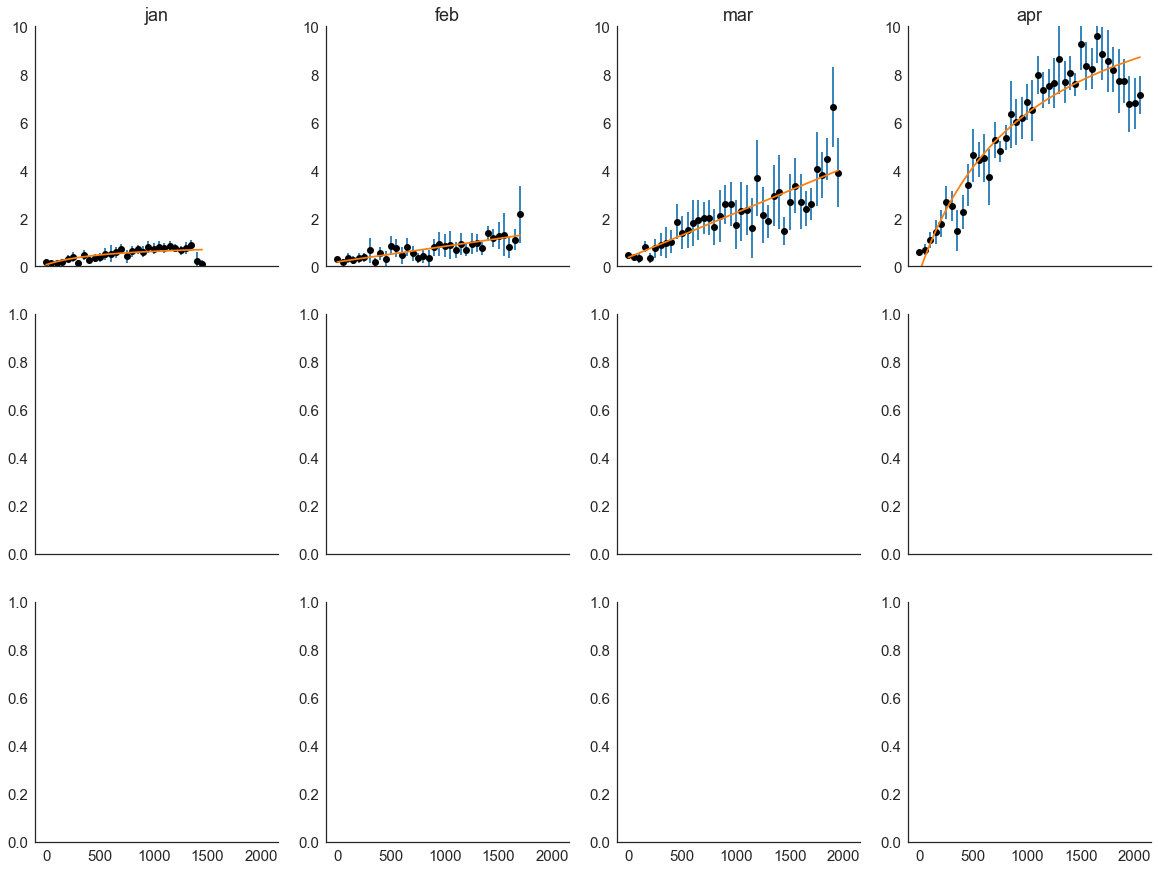

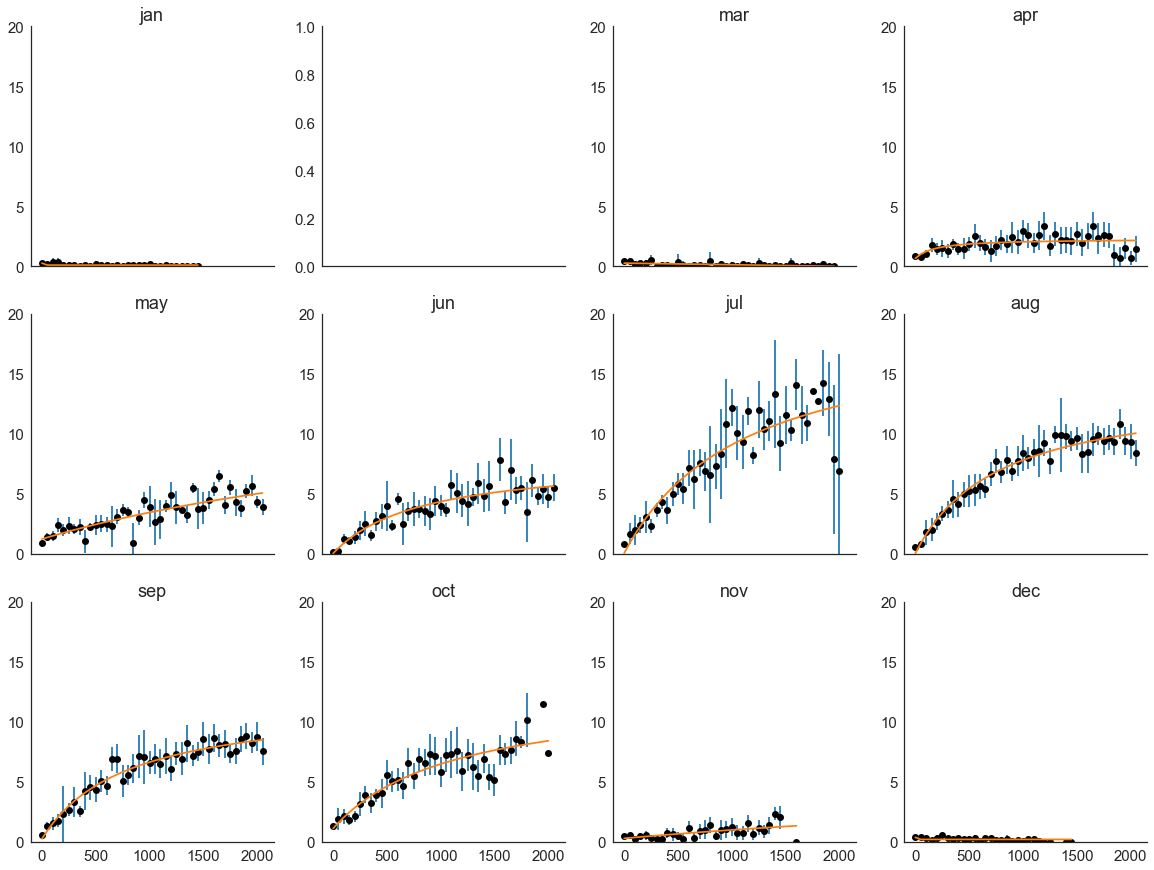

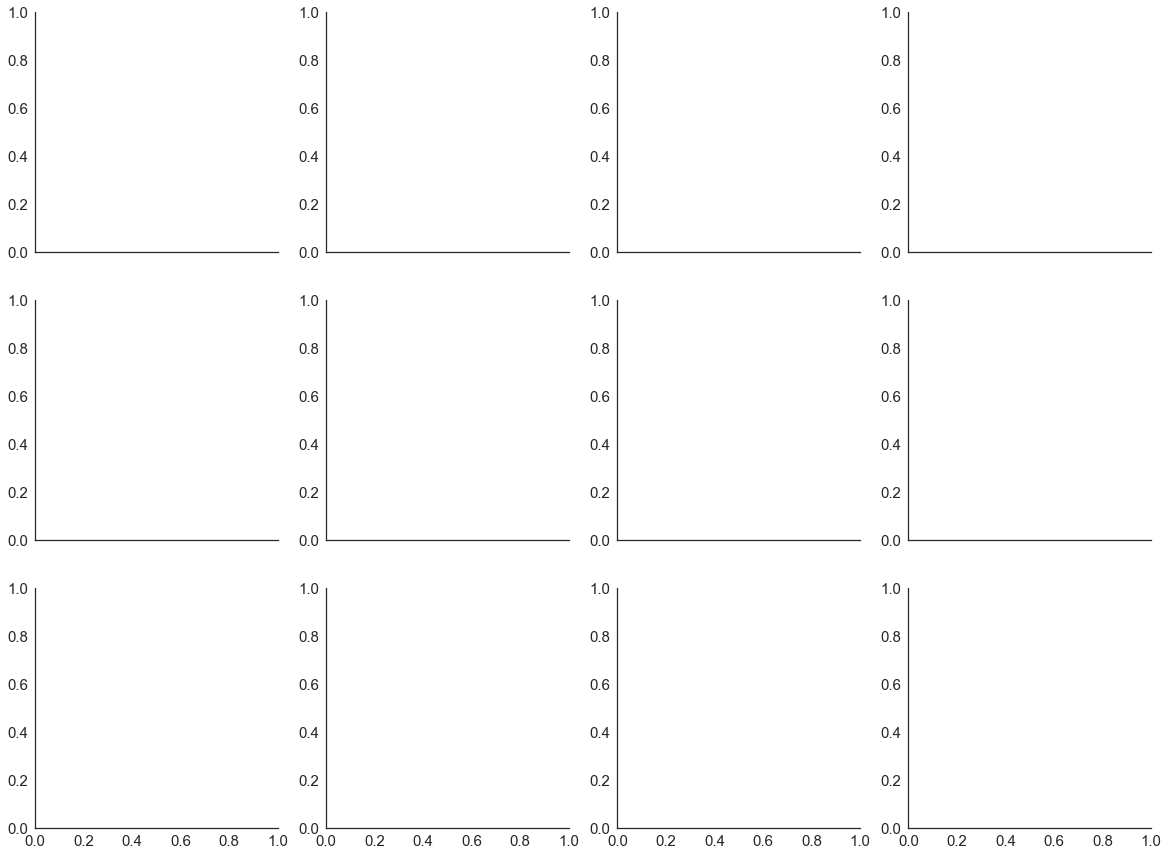

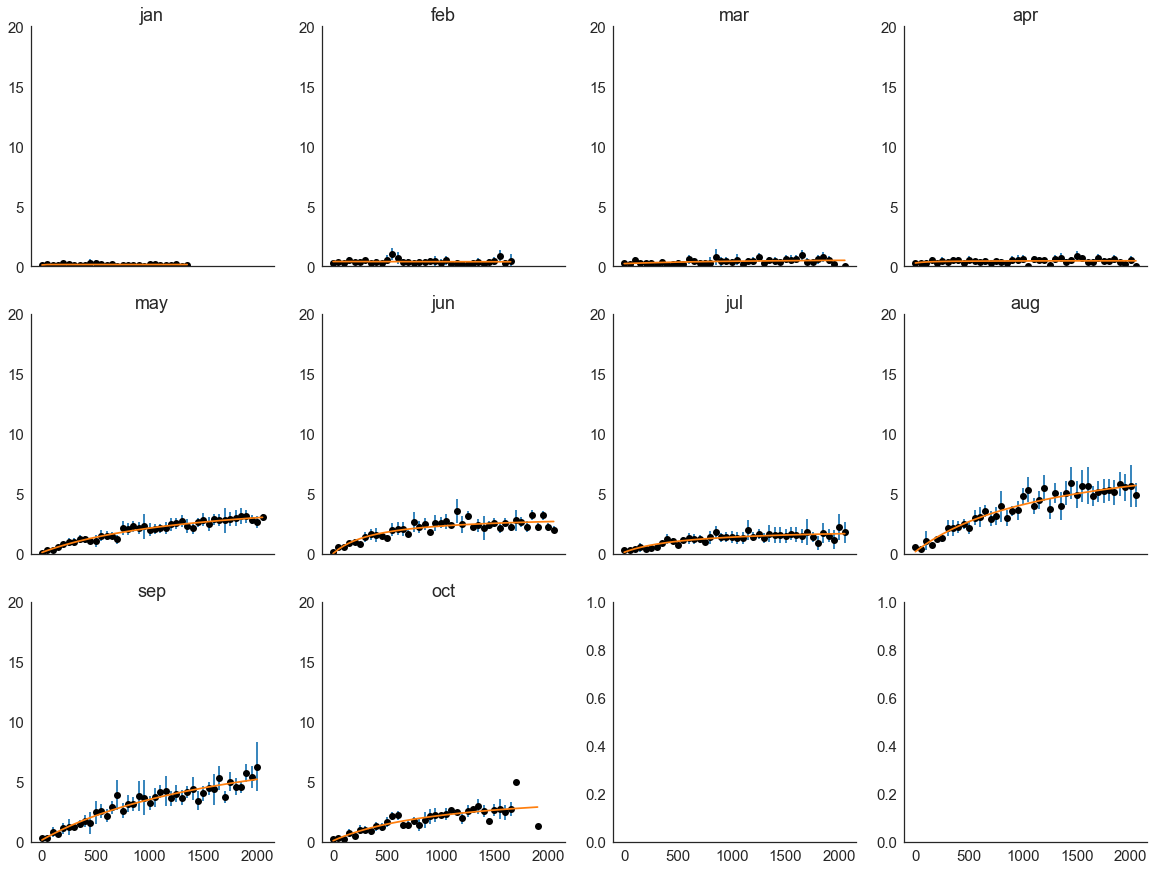

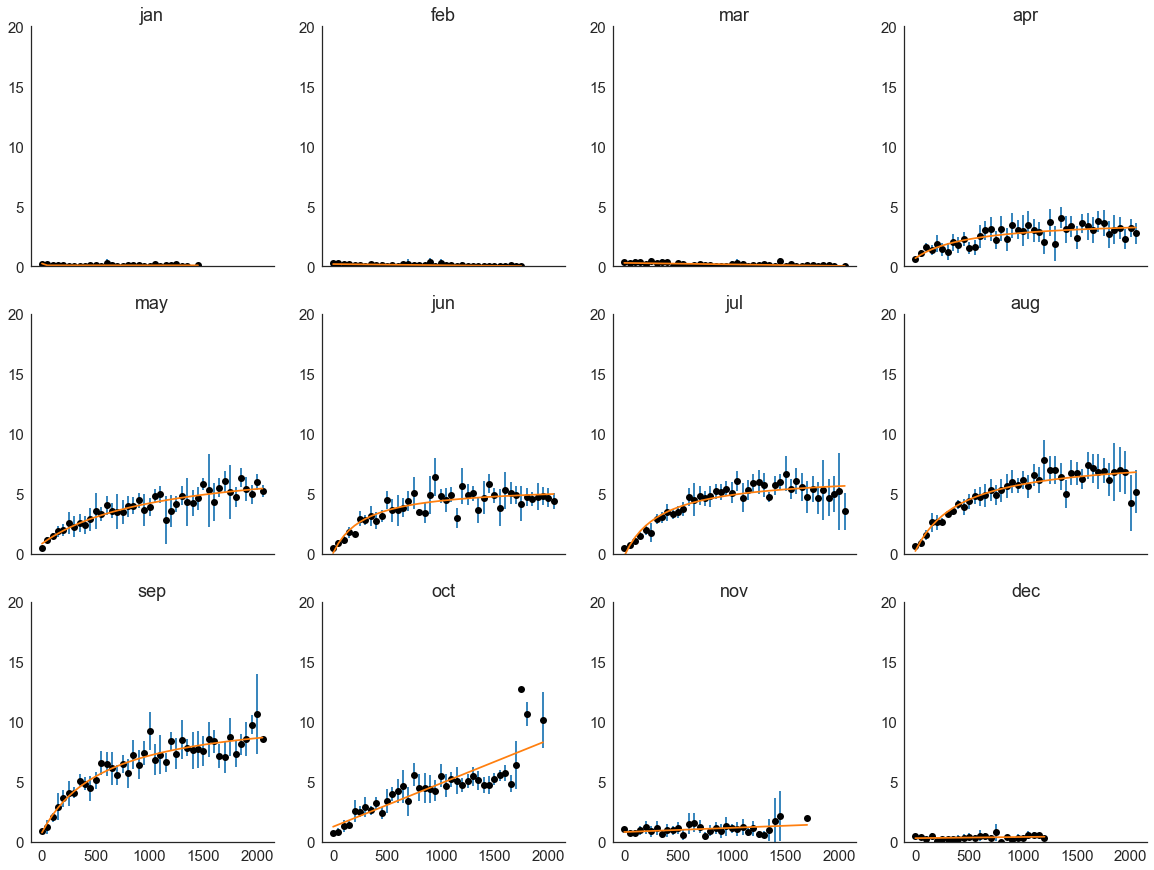

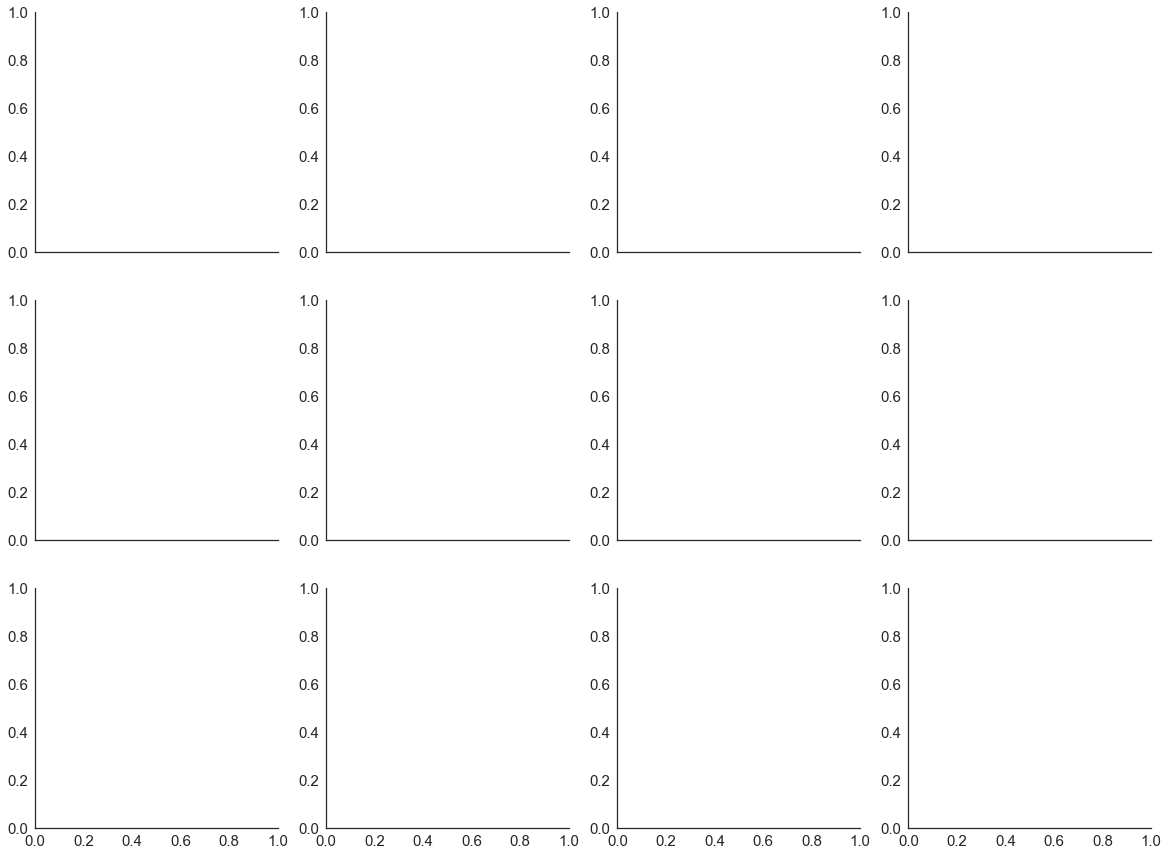

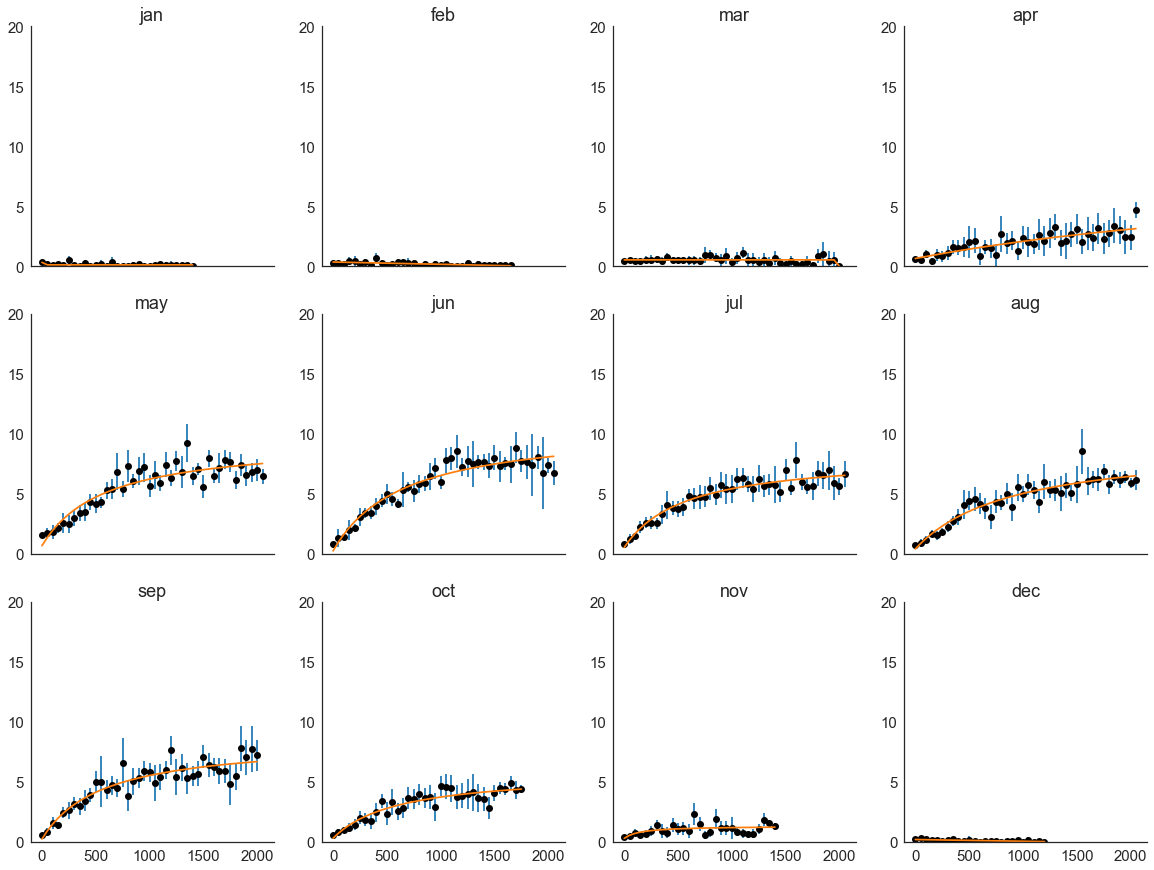

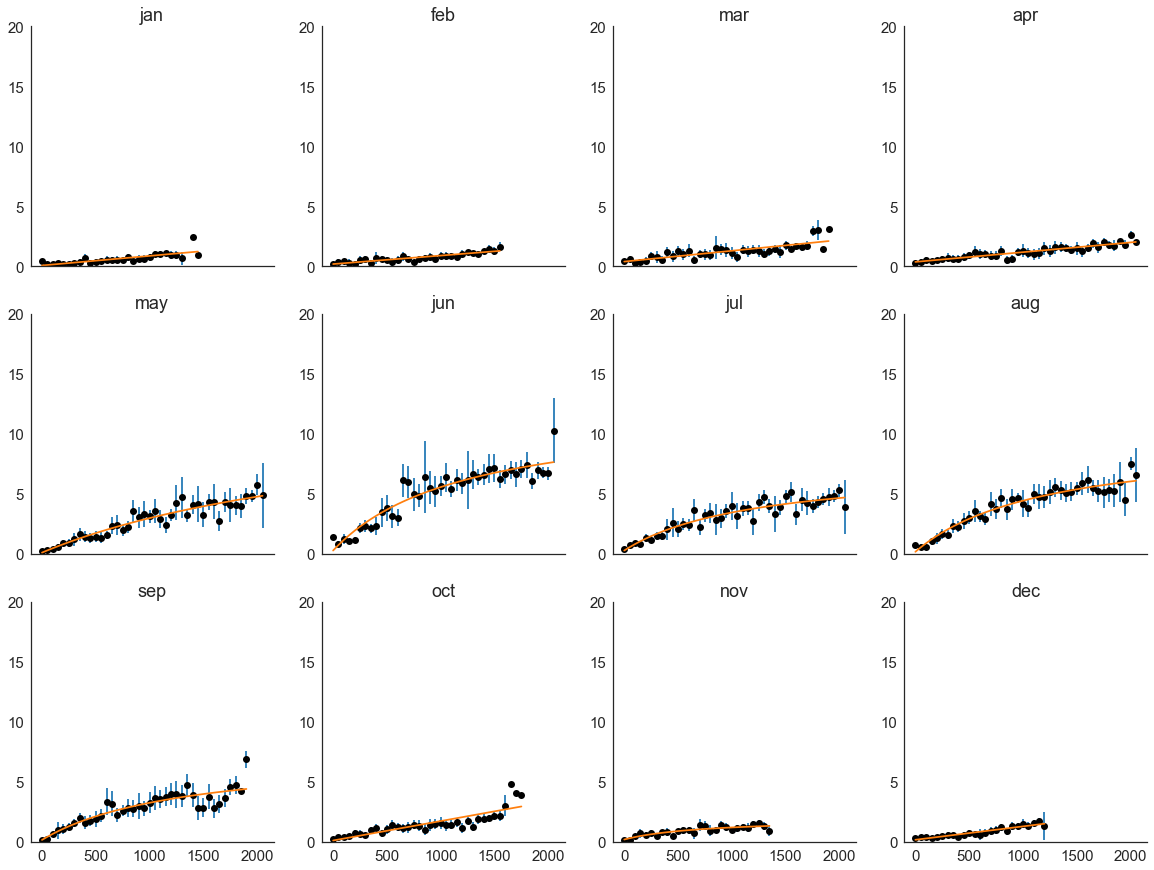

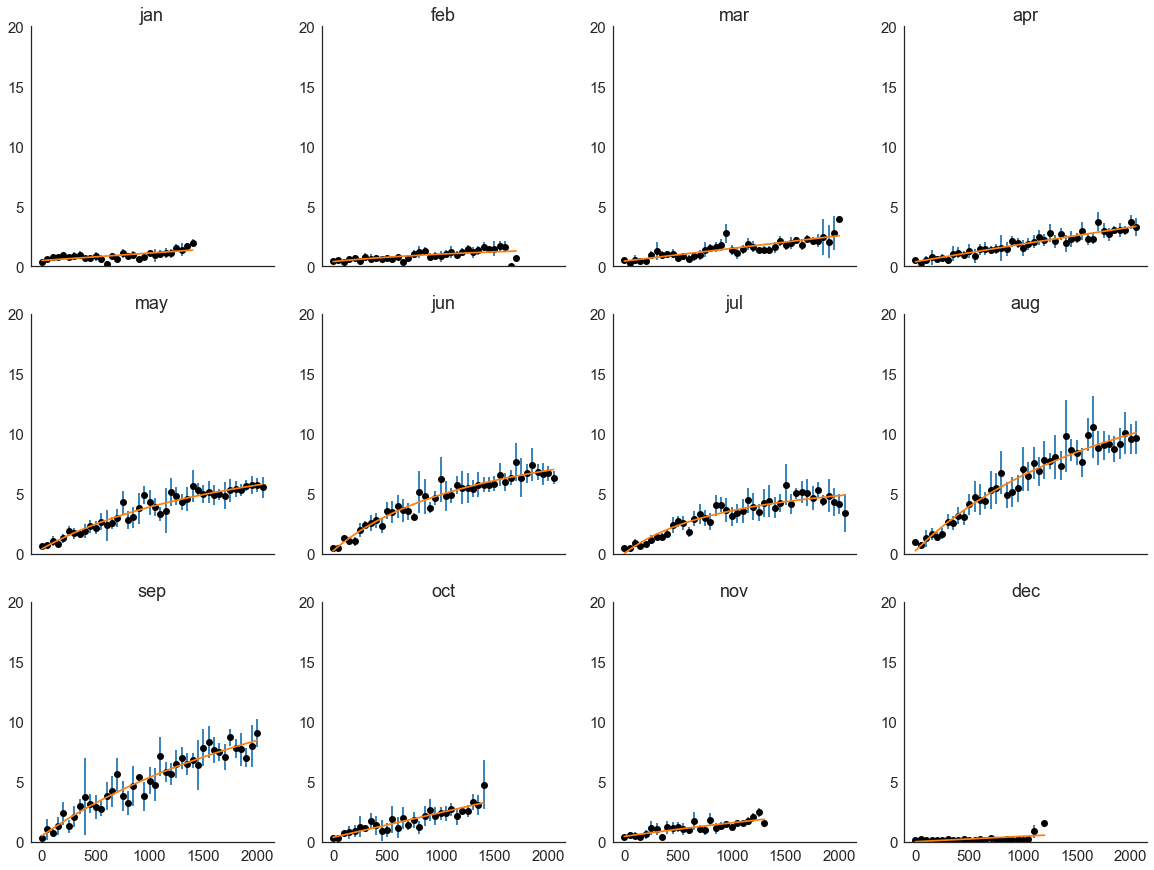

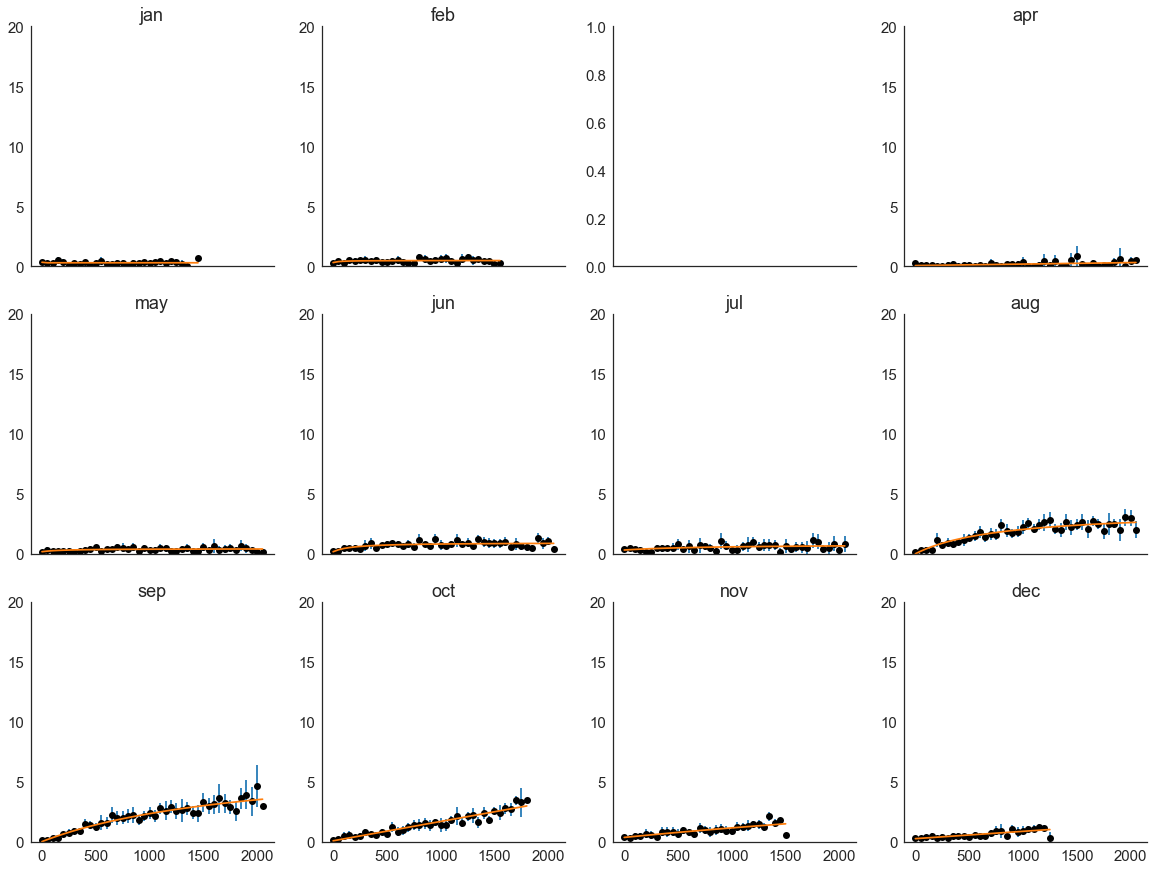

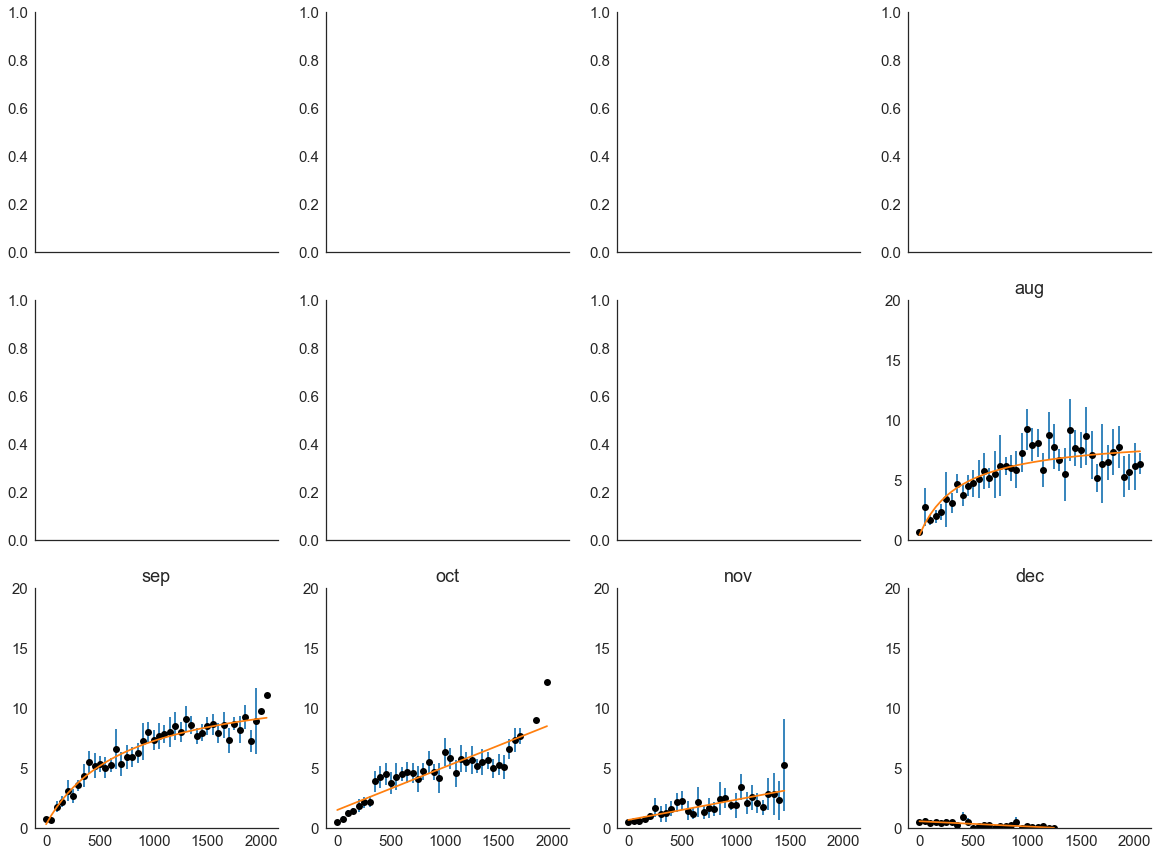

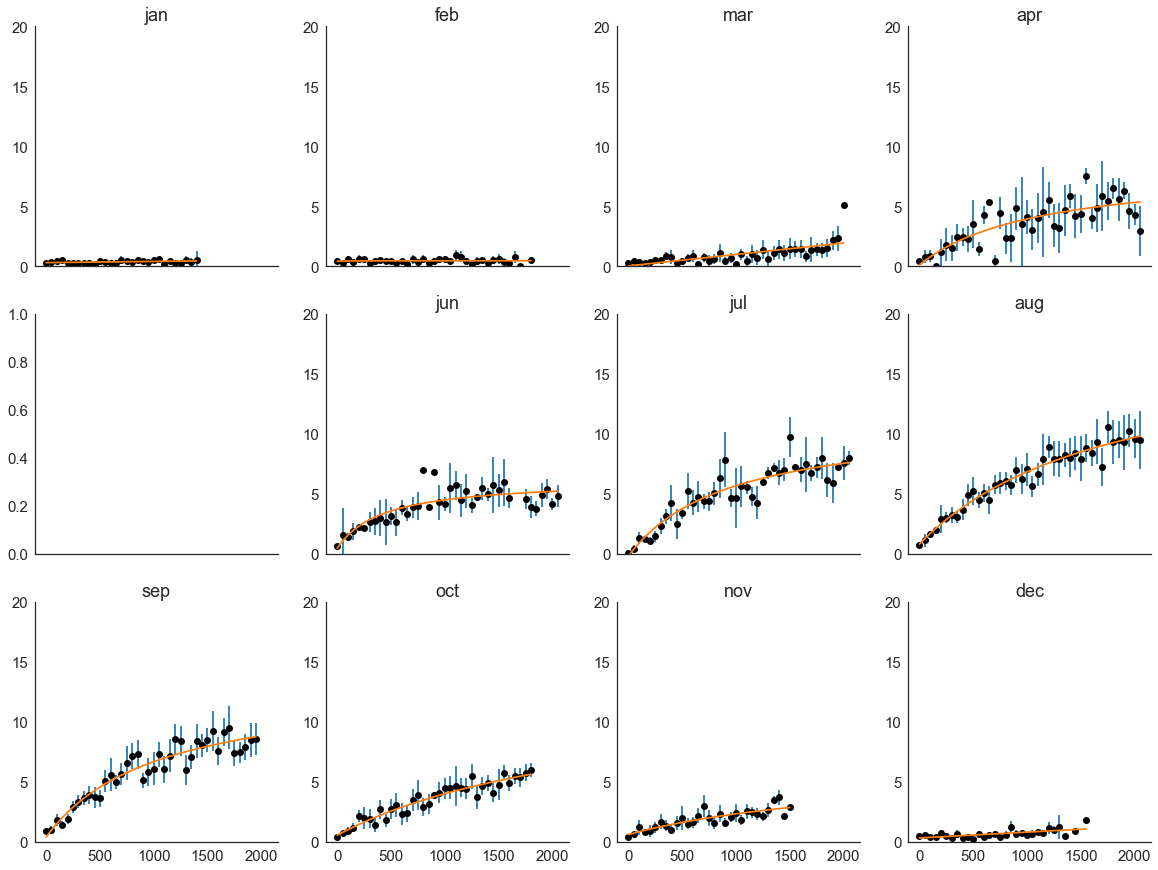

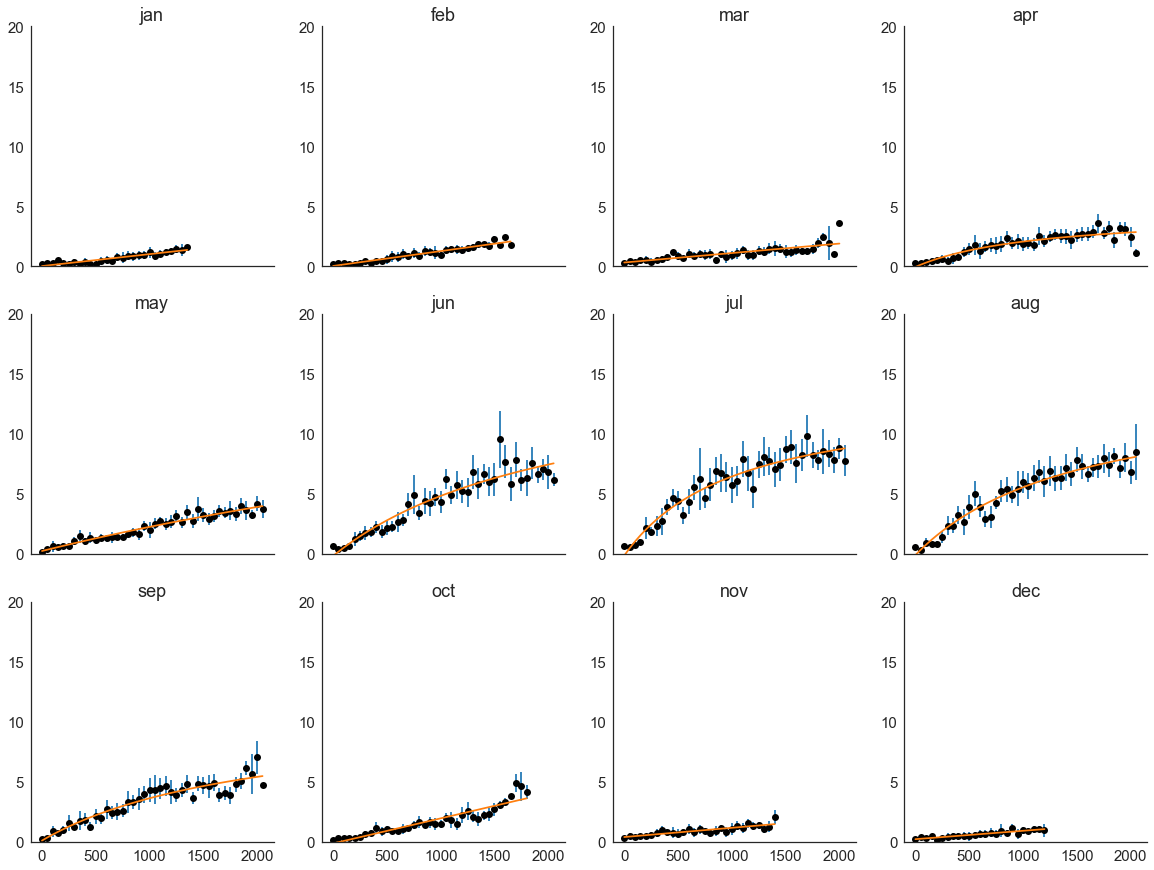

In [40]:
bin_range = np.arange(0,2200,50)
binBy = 'PPFD_IN'
toBin = 'GPP'
allParams = []
allRMSE = []
allRsquardes = []
sitenames = []
sitemonth = []
siteyear = []

for fluxSite in siteDFs:
    for year in fluxSite.year.unique():
        siteYear = fluxSite[(fluxSite.year == year) & (fluxSite.NIGHT_F == 0)]

        f, ((ax1, ax2, ax3, ax4), 
            (ax5, ax6, ax7, ax8), 
            (ax9, ax10, ax11, ax12)) = plt.subplots(3, 4, figsize = (20,15), sharex=True)
        axs = f.axes
        axsidx = 0

        for month in np.arange(1,13):
            monthYear = siteYear[siteYear.month == month]
            x_binned, y_binned, y_err = doBinning(monthYear, binBy, toBin, bin_range)
            fitx = np.array(x_binned)
            fity = np.array(y_binned)

            indices = np.logical_not(np.logical_or(np.isnan(fitx), np.isnan(fity)))
            fitx = fitx[indices]
            fity = fity[indices]
            
            if len(fity) > 0:
                yModel, RMSE, Rsquared, paramEstimates = doCurveFitting(fitx, fity)
                allParams.append(paramEstimates.tolist())
                allRMSE.append(RMSE)
                allRsquardes.append(Rsquared)
                sitenames.append(siteYear.SiteName[0])
                sitemonth.append(month)
                siteyear.append(year)
            
                # set plot axis and add data to the plots
                ax = axs[axsidx]
                ax.plot(x_binned, y_binned, 'ok')
                ax.errorbar(x_binned, y_binned, yerr=y_err, fmt = 'o', ms = 0)
                ax.plot(fitx, yModel, '-')
                if (siteYear.SiteName[0] == 'US-Vcm') | (siteYear.SiteName[0] == 'US-Vcp'):
                    ax.set_ylim([0,20])
                else:
                    ax.set_ylim([0,10])

                ax.set_title(monthLabs[axsidx])
                axsidx += 1
            else:
                axsidx += 1
               

        sns.despine()
        sns.set_style('white')
        sns.set_context('notebook', font_scale = 1.5)
        plt.savefig(siteYear.SiteName[0] + '_' + str(year) + 'monthlyLRC.tif')

### We can use a model to quantify how much the initial slope, and asymptote of the curves are changing
as each of these parameters have an ecological interpretation. The initial slope is telling us how much C is moving into the ecosystem because of photosynthesis <i><b>when light is not limiting</b></i>. In these light saturated systems, light limitation is a rare situation -- but certainly as the sun is rising, most vegetation will experience a period where increments of additional light result in a commensurate increase in C uptake. The slope of that curve is directly proportional to the light use efficiency of the ecosystem, eLUE.

We can look at the list of parameter coefficients that resulted in the curve fits above and take a look at how they vary over time.

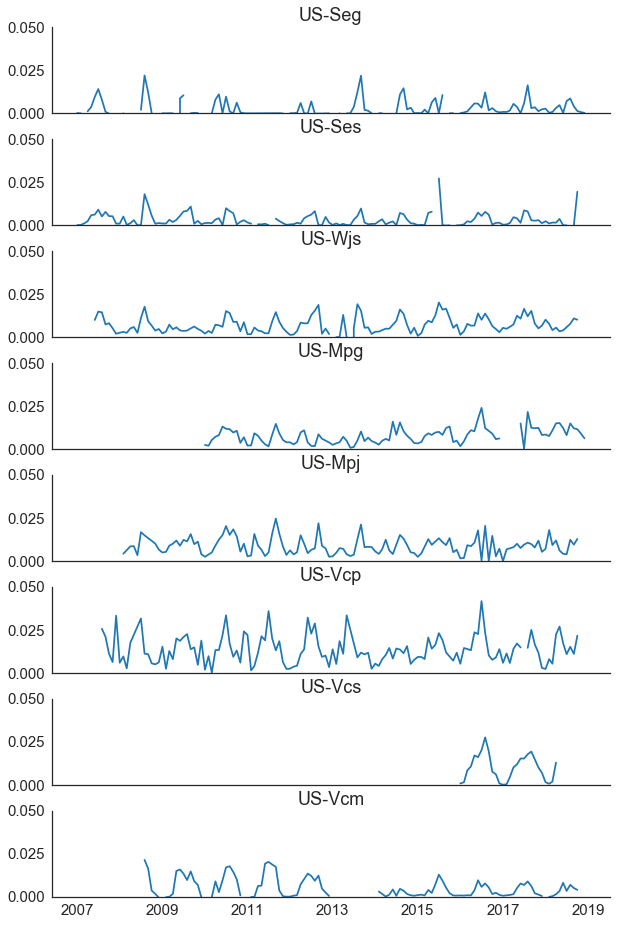

In [100]:
alphas = np.array(allParams)[:,0]
betas = np.array(allParams)[:,1]
gammas = np.array(allParams)[:,2]
alphas[alphas > 0.05] = np.nan
paramDF = pd.DataFrame(dict(site = sitenames, year = siteyear, 
                  month = sitemonth, alpha = alphas,
                 beta = betas, gamma = gammas, RMSE = allRMSE,
                 r2 = allRsquardes))

paramDF.index = pd.to_datetime((paramDF.year*100+paramDF.month*1).apply(str),format='%Y%m')
paramDF = paramDF.sort_index()
f, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8, 1, figsize = (10,16), sharex=True)
plt.subplots_adjust(hspace = 0.3)
axs = f.axes
idx = 0
for site in siteNames:
    ax = axs[idx]
    thisSite = paramDF[paramDF.site == site]
    ax.plot(thisSite.alpha)
    ax.set_ylim([0, 0.05])
    ax.set_title(site)
    idx += 1
sns.despine()